# Loan Approval Prediction

**Problem statement:** 
- The goal is to build a classification model to predict loan_status (whether a loan will default or not) based on applicant demographic details, financial data, and loan-specific features. This model could help financial institutions identify high-risk loans and mitigate potential losses by making more informed lending decisions.

**Data Description**

The dataset contains the following features:
* id (int64) – Unique identifier for each record.
* person_age (int64) – Age of the individual.
* person_income (int64) – Annual income of the individual.
* person_home_ownership (object) – Type of home ownership (e.g., "RENT", "OWN").
* person_emp_length (float64) – Length of employment (in years).
* loan_intent (object) – Purpose of the loan (e.g., "EDUCATION", "MEDICAL").
* loan_grade (object) – Grade assigned to the loan (e.g., "A", "B").
* loan_amnt (int64) – Amount of the loan.
* loan_int_rate (float64) – Interest rate of the loan.
* loan_percent_income (float64) – Proportion of income that the loan represents.
* cb_person_default_on_file (object) – Whether the individual has any defaults on file (e.g., "Y" for yes, "N" for no).
* cb_person_cred_hist_length (int64) – Length of the individual's credit history.
* loan_status (int64) – Status of the loan (likely binary: 0 for not defaulted, 1 for defaulted).

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
plt.rcParams['figure.figsize']=[15,8]

In [4]:
from scipy import stats as st
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.feature_selection import RFE

from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import roc_curve, roc_auc_score

## Load the CSV files

In [5]:
train = pd.read_csv("train.csv")
train.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0  
4                         N                           3            0

In [6]:
train.shape

(58645, 13)

In [7]:
train.drop('id', axis=1, inplace=True)

In [8]:
test = pd.read_csv("test.csv")
test.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                           2  
1                 0.10                         Y                           4  
2                 0.13                         Y                           2  
3                 0.14                         N                           7  
4                 0.15                         Y                           4

In [9]:
test.shape

(39098, 12)

In [10]:
test.drop('id', axis=1, inplace=True)

## Merge train and test csv files

In [11]:
df = pd.concat([train,test],axis =0,ignore_index=True,sort=False)
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          37          35000                  RENT                0.0   
1          22          56000                   OWN                6.0   
2          29          28800                   OWN                8.0   
3          30          70000                  RENT               14.0   
4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14          0.0  
1                         N                           2          0.0  
2                         N                          10          0.0  
3                         N                           5          0.0  
4                         N                           3          0.0

In [12]:
df.shape

(97743, 12)

## Understanding the data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97743 entries, 0 to 97742
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  97743 non-null  int64  
 1   person_income               97743 non-null  int64  
 2   person_home_ownership       97743 non-null  object 
 3   person_emp_length           97743 non-null  float64
 4   loan_intent                 97743 non-null  object 
 5   loan_grade                  97743 non-null  object 
 6   loan_amnt                   97743 non-null  int64  
 7   loan_int_rate               97743 non-null  float64
 8   loan_percent_income         97743 non-null  float64
 9   cb_person_default_on_file   97743 non-null  object 
 10  cb_person_cred_hist_length  97743 non-null  int64  
 11  loan_status                 58645 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 8.9+ MB


**Inference**
* The combined dataset, formed by concatenating the training and testing data, contains 97,743 rows and 13 columns.
* The training data consists of 58,645 rows and 13 columns.
* The testing data consists of 39,098 rows and 12 columns (missing the target column).
* The dataset includes 9 integer columns and 4 categorical (object) columns.
* The missing values in the loan_status column correspond to the target variable, which is absent in the testing data. The goal is to predict the loan status in the testing set after building the model.

## Checking duplicate values

In [14]:
df.duplicated().sum()

0

**Inference**
* There are no duplicate values present in the dataset.

## Check for anamolies

##### person_home_ownership

In [15]:
df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [16]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        50874
MORTGAGE    41507
OWN          5194
OTHER         168
Name: count, dtype: int64

##### loan_intent

In [17]:
df['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [18]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            20347
MEDICAL              18381
PERSONAL             16831
VENTURE              16643
DEBTCONSOLIDATION    15048
HOMEIMPROVEMENT      10493
Name: count, dtype: int64

##### loan_grade

In [19]:
df['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [20]:
df['loan_grade'].value_counts()

loan_grade
A    34989
B    34004
C    18496
D     8303
E     1646
F      254
G       51
Name: count, dtype: int64

##### cb_person_default_on_file

In [21]:
df['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [22]:
df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    83170
Y    14573
Name: count, dtype: int64

##### loan_status

In [23]:
df['loan_status'] = df['loan_status'].astype('object')

In [24]:
df['loan_status'].unique()

array([0.0, 1.0, nan], dtype=object)

## Separating numeric and categoric

In [25]:
num = df.select_dtypes(include=np.number).columns.to_list()
cat = df.select_dtypes(exclude=np.number).columns.to_list()

In [26]:
num

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [27]:
cat

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'loan_status']

## Basic Analysis

In [28]:
df[num].describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  97743.000000   9.774300e+04       97743.000000  97743.000000   
mean      27.557227   6.405189e+04           4.695436   9231.120663   
std        6.033008   3.794080e+04           3.923469   5568.786009   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   4.200000e+04           2.000000   5000.000000   
50%       26.000000   5.800000e+04           4.000000   8000.000000   
75%       30.000000   7.574400e+04           7.000000  12000.000000   
max      123.000000   1.900000e+06         123.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  
count   97743.000000         97743.000000                97743.000000  
mean       10.671211             0.159372                    5.820417  
std         3.028910             0.091668                    4.046423  
min         5.420000             0.000000                    2.000000  
25%         7.880000             0.090000                    3.000000  
50%        10.750000             0.140000                    4.000000  
75%        12.990000             0.210000                    8.000000  
max        23.220000             0.830000                   30.000000

**Inference**
* The maximum age in the person_age column is 123, which seems unusually high for a loan prediction dataset. This should be further visualized and examined for potential data anomalies.

In [29]:
df[cat].describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file  \
count                  97743       97743      97743                     97743   
unique                     4           6          7                         2   
top                     RENT   EDUCATION          A                         N   
freq                   50874       20347      34989                     83170   

        loan_status  
count       58645.0  
unique          2.0  
top             0.0  
freq        50295.0

**Inference**
* The person_home_ownership column has 4 unique values, with the majority of individuals living in rented properties.
* The loan_intent column contains 6 unique values, and most loans are taken for education purposes.
* The loan_grade column has 7 unique values, with the majority of loans assigned an A grade.
* The cb_person_default_on_file column has 2 unique values, with most individuals having no defaults on file.
* The loan_status column has 2 unique values, with the majority of loans classified as not defaulted.

#### lets check age distribution

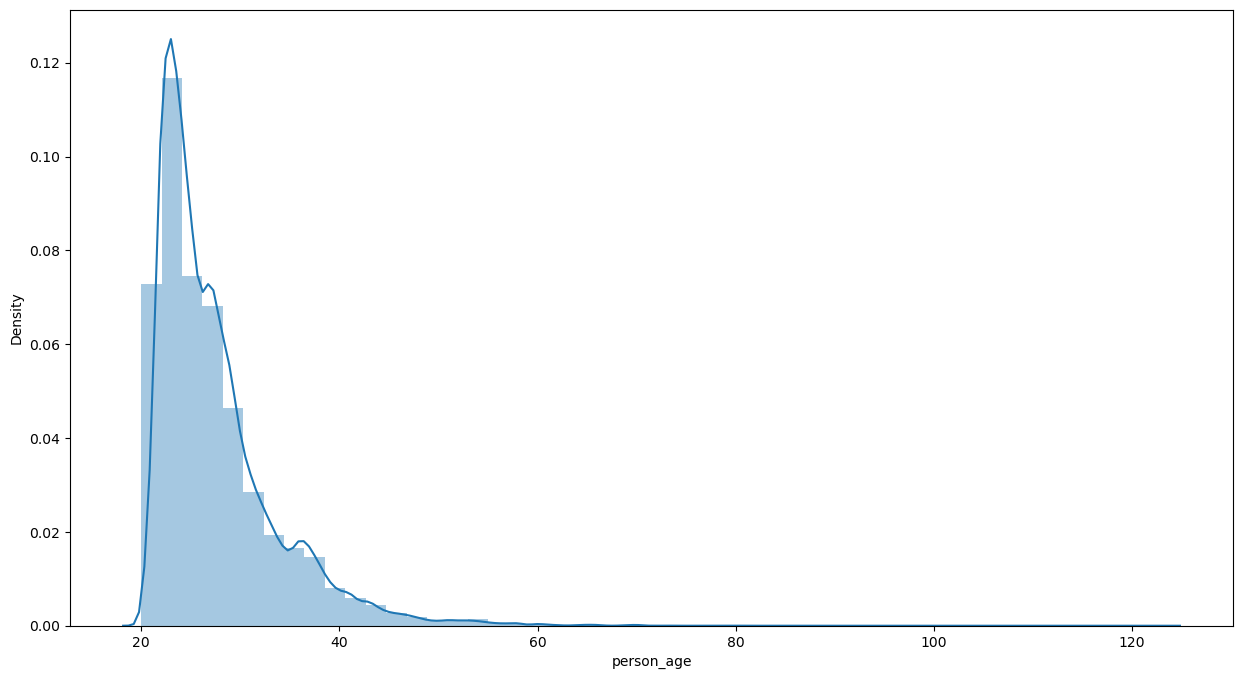

In [30]:
sns.distplot(df['person_age'])
plt.show()

In [31]:
df['person_age'].median()

26.0

In [32]:
df[(df['person_age']>80)|(df['person_age']<20)]

person_age  person_income person_home_ownership  person_emp_length  \
4962           84         108928              MORTGAGE                3.0   
6750           84          94800              MORTGAGE                2.0   
47336         123          36000              MORTGAGE                7.0   
90846          84          60000              MORTGAGE                0.0   
92469          94          56628                  RENT                2.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
4962   DEBTCONSOLIDATION          A       6000           7.51   
6750            PERSONAL          D      10000          14.09   
47336           PERSONAL          B       6700          10.75   
90846  DEBTCONSOLIDATION          A       2000           5.79   
92469            MEDICAL          E      16000          16.82   

       loan_percent_income cb_person_default_on_file  \
4962                  0.06                         N   
6750                  0.11                         N   
47336                 0.18                         N   
90846                 0.03                         N   
92469                 0.29                         Y   

       cb_person_cred_hist_length loan_status  
4962                           25         0.0  
6750                           22         0.0  
47336                           4         0.0  
90846                          25         NaN  
92469                          27         NaN

**Inference**
* The person_age column is normally distributed.
* Individuals over the age of 80 are taking out loans primarily for purposes such as mortgages or rent, and some of them are not defaulters.

## Checking Null values

In [33]:
import missingno as msno

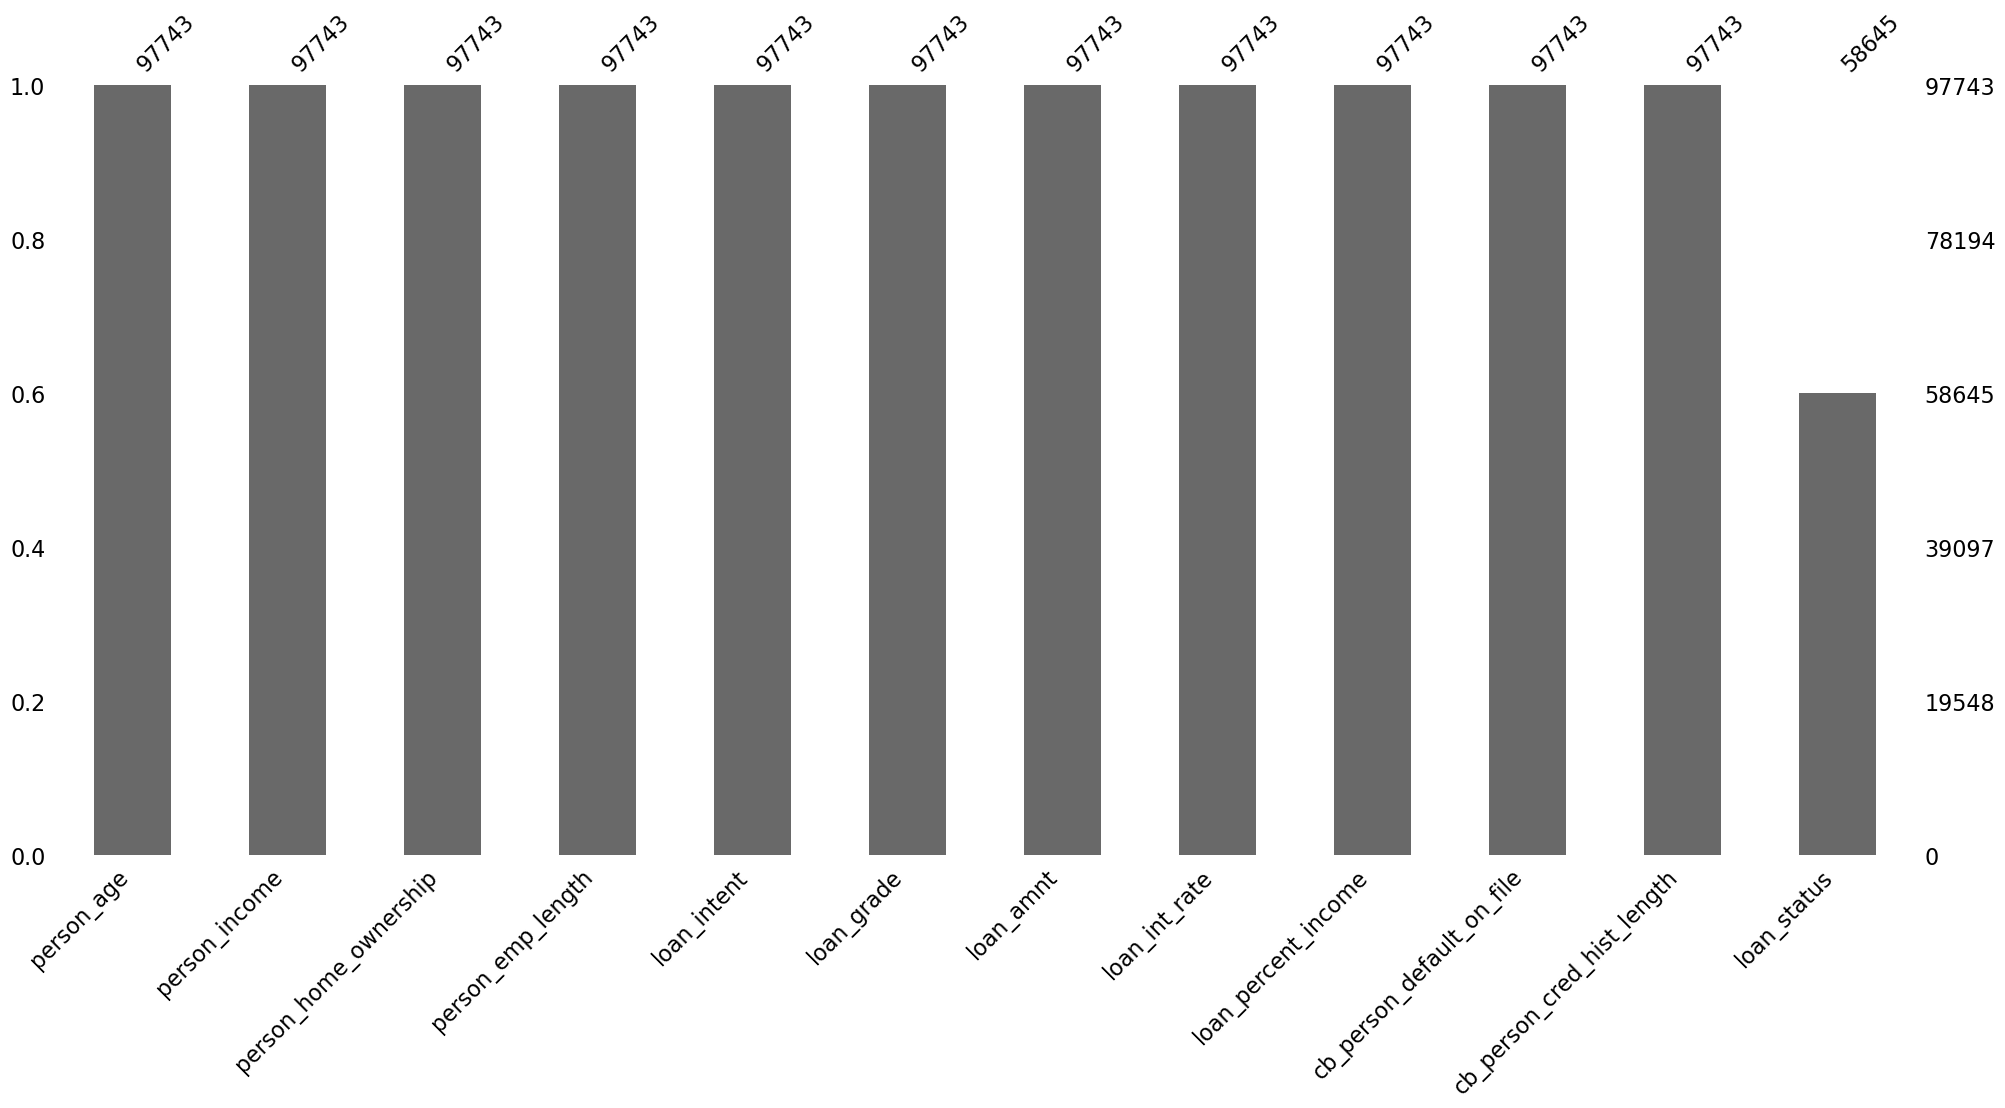

In [34]:
msno.bar(df)
plt.show()

In [35]:
df.isnull().sum()

person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length                 0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

In [36]:
(df.isnull().sum()/len(df))*100

person_age                     0.000000
person_income                  0.000000
person_home_ownership          0.000000
person_emp_length              0.000000
loan_intent                    0.000000
loan_grade                     0.000000
loan_amnt                      0.000000
loan_int_rate                  0.000000
loan_percent_income            0.000000
cb_person_default_on_file      0.000000
cb_person_cred_hist_length     0.000000
loan_status                   40.000818
dtype: float64

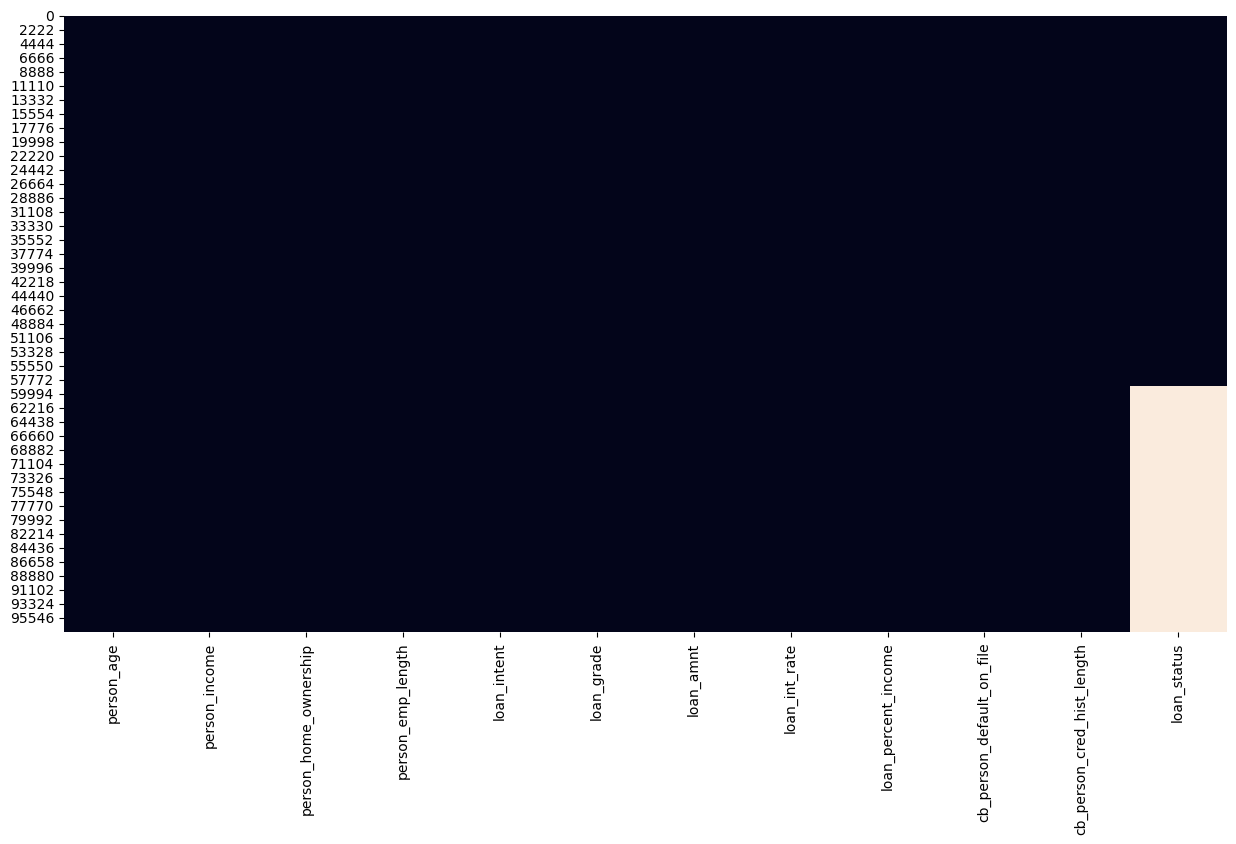

In [37]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

**Inference**
* There are no missing values in the dataset.

## Outlier Treatment

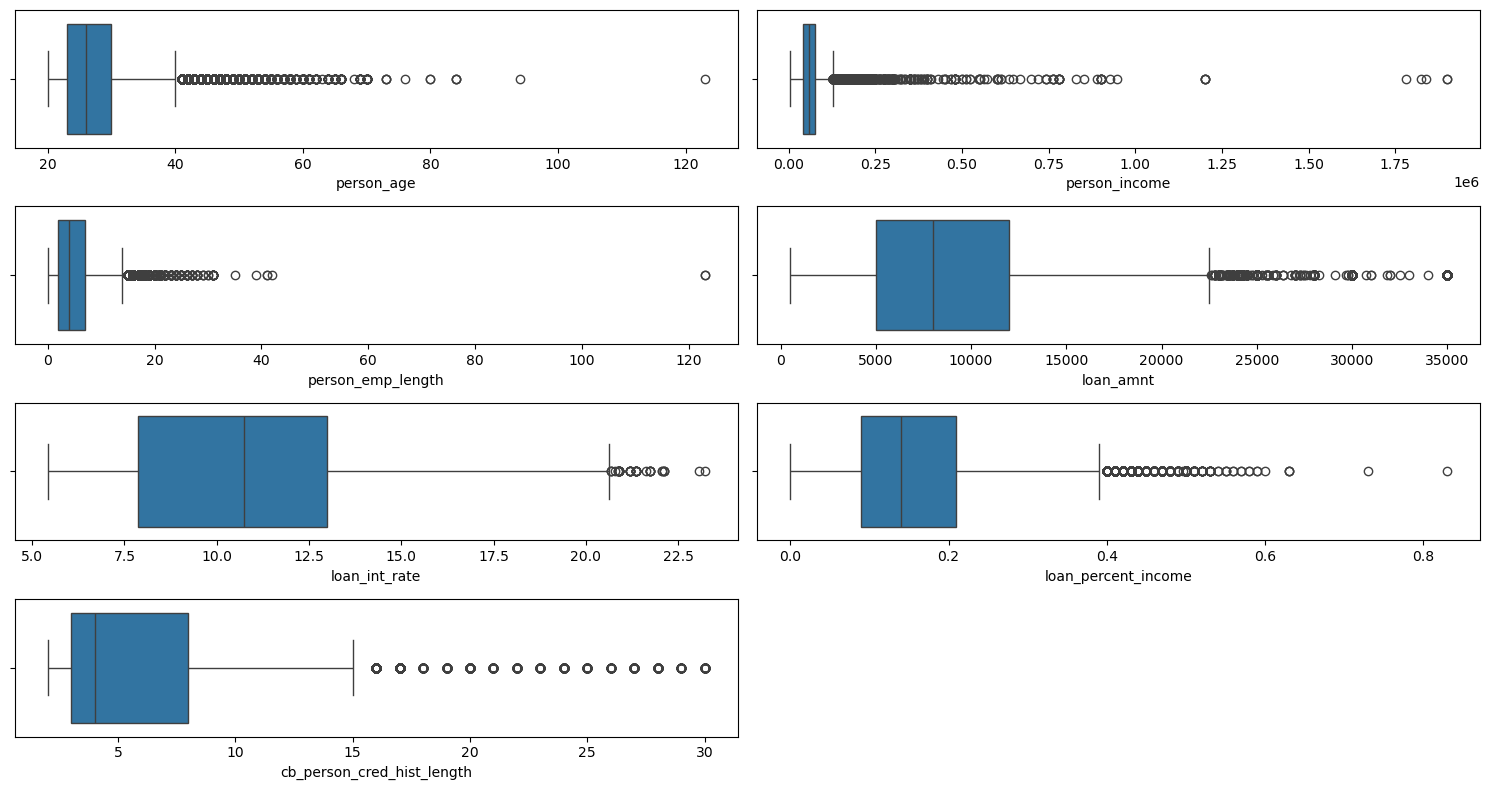

In [38]:
t=1
for i in num:
    plt.subplot(4,2,t)
    sns.boxplot(x= df[i])
    t+=1
plt.tight_layout()
plt.show()

In [39]:
q1 = df[num].quantile(0.25)
q3 = df[num].quantile(0.75)

iqr = q3-q1

ll = q1 - (1.5*iqr)
ul = q3 + (1.5*iqr)

print(ll)
print(ul)

person_age                      12.500
person_income                -8616.000
person_emp_length               -5.500
loan_amnt                    -5500.000
loan_int_rate                    0.215
loan_percent_income             -0.090
cb_person_cred_hist_length      -4.500
dtype: float64
person_age                        40.500
person_income                 126360.000
person_emp_length                 14.500
loan_amnt                      22500.000
loan_int_rate                     20.655
loan_percent_income                0.390
cb_person_cred_hist_length        15.500
dtype: float64


In [40]:
df[((df[num]<ll)|(df[num]>ul)).any(axis=1)].head()

person_age  person_income person_home_ownership  person_emp_length  \
44          44          58000                  RENT               13.0   
57          37          60000              MORTGAGE               11.0   
67          26          30000                  RENT                2.0   
70          43          68000              MORTGAGE                0.0   
75          28          27000                   OWN                0.0   

        loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
44  HOMEIMPROVEMENT          C      15000          14.27                 0.26   
57          VENTURE          A       2000           7.66                 0.03   
67          MEDICAL          A      12000           7.51                 0.40   
70          MEDICAL          A       5000           8.90                 0.07   
75         PERSONAL          A      12000           7.51                 0.44   

   cb_person_default_on_file  cb_person_cred_hist_length loan_status  
44                         Y                          17         0.0  
57                         N                          17         0.0  
67                         N                           4         1.0  
70                         N                          17         0.0  
75                         N                           6         0.0

In [41]:
(df[((df[num]<ll)|(df[num]>ul)).any(axis=1)].shape[0]/df.shape[0])*100

14.890068854035581

**Inference**
* The dataset contains 14% outliers. If we remove them, we may lose valuable information about individuals who obtained loans after the age of 40. Therefore, we can cap the outliers and keep them in the dataset for now, but we can also build the model with the outliers included.

In [42]:
df_no_outliers = df[~((df[num]<ll)|(df[num]>ul)).any(axis=1)]
df_no_outliers.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          37          35000                  RENT                0.0   
1          22          56000                   OWN                6.0   
2          29          28800                   OWN                8.0   
3          30          70000                  RENT               14.0   
4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length loan_status  
0                         N                          14         0.0  
1                         N                           2         0.0  
2                         N                          10         0.0  
3                         N                           5         0.0  
4                         N                           3         0.0

In [43]:
df_no_outliers.shape

(83189, 12)

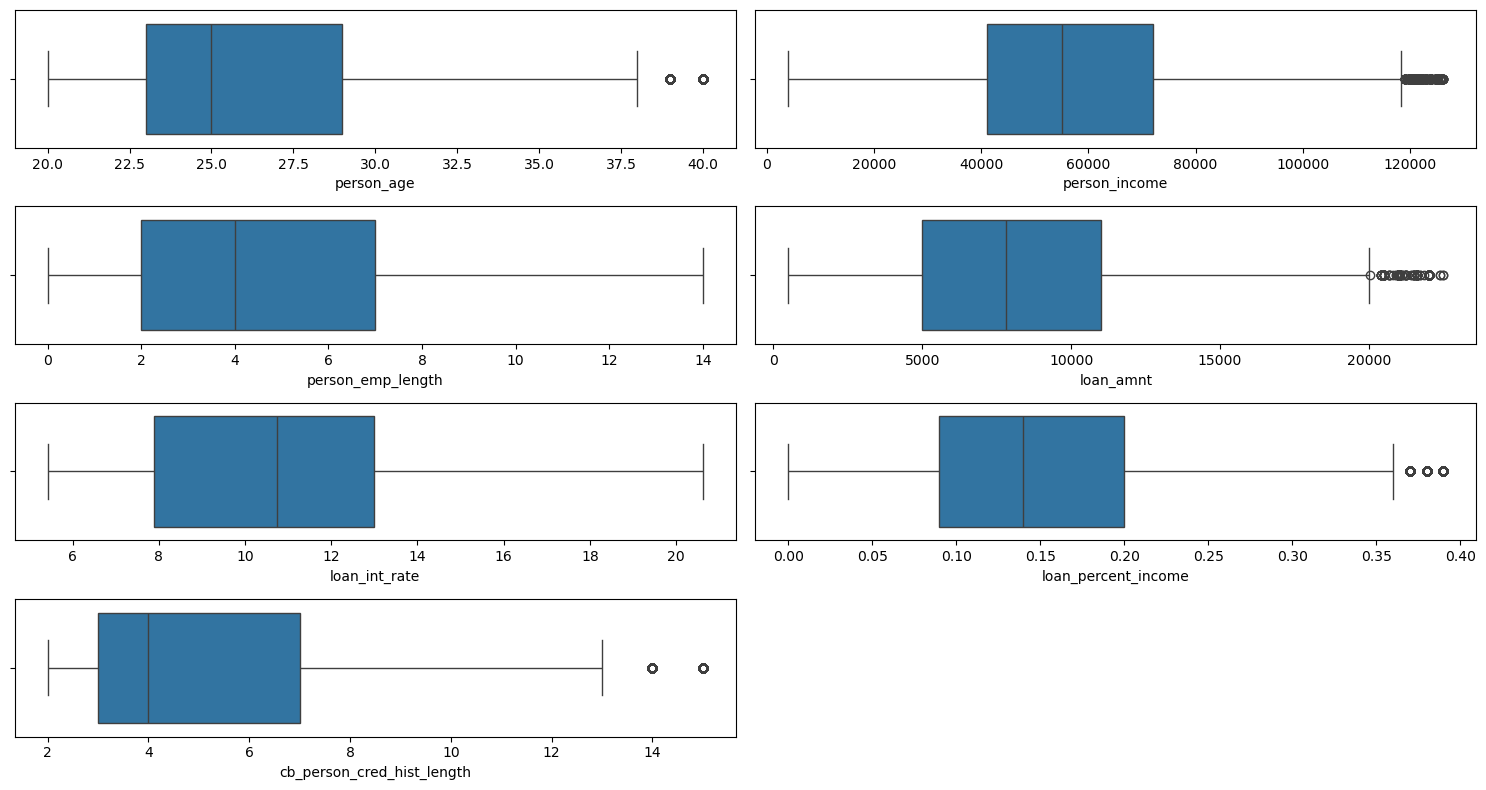

In [44]:
t=1
for i in num:
    plt.subplot(4,2,t)
    sns.boxplot(x= df_no_outliers[i])
    t+=1
plt.tight_layout()
plt.show()

**Inference**
* After removing the outliers, the dataset now contains 83,189 rows and 13 columns.

## Univariate Analysis

#### Numeric columns

In [45]:
df[num].skew()

person_age                     1.956259
person_income                 10.453061
person_emp_length              1.713463
loan_amnt                      1.194925
loan_int_rate                  0.194236
loan_percent_income            0.926090
cb_person_cred_hist_length     1.633122
dtype: float64

**Inference**
* The income variable is significantly skewed, suggesting that most people have relatively lower incomes, but a small number of individuals have exceptionally high incomes. This positive skewness might impact the model and could require transformation to reduce skewness.
* Both person age and employment length show moderate positive skewness. This suggests that most individuals in the dataset are younger or have shorter employment histories, while a few have higher ages or longer employment lengths.
* The loan amount and loan percent income show mild skewness, meaning there is a slight imbalance where more individuals take out lower loans and a small number take out much larger loans relative to their income. 

In [46]:
df[num].kurt()

person_age                      6.114413
person_income                 340.473795
person_emp_length              18.923790
loan_amnt                       1.730328
loan_int_rate                  -0.728090
loan_percent_income             0.666326
cb_person_cred_hist_length      3.567885
dtype: float64

**Inference**
* The income variable shows extremely high leptokurtic kurtosis, indicating the presence of significant outliers. This suggests that income distribution has a sharp peak with many values near the mean and heavy tails, meaning a few individuals have very extreme incomes.
* Employment length is also leptokurtic, indicating that most individuals have similar employment lengths, but there are a few extreme cases where individuals have unusually long employment histories.
* The credit history length variable is moderately leptokurtic, suggesting that while most individuals have a typical credit history length, there are some who have significantly longer or shorter credit histories than average.

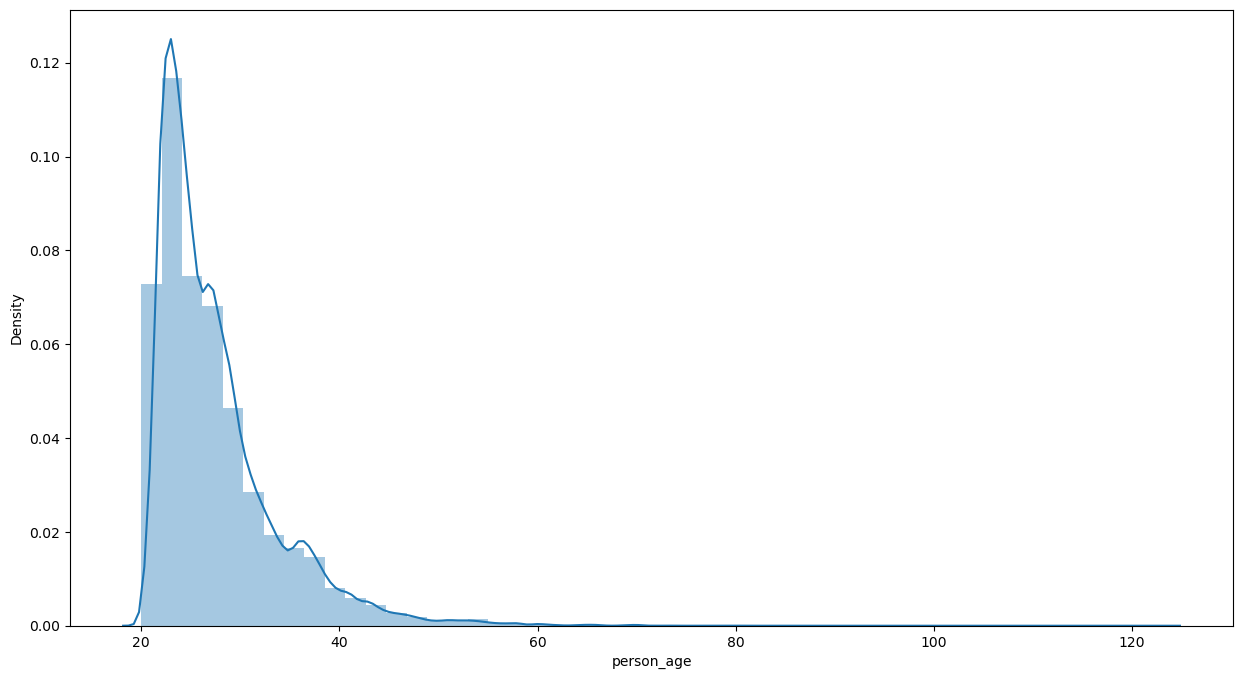

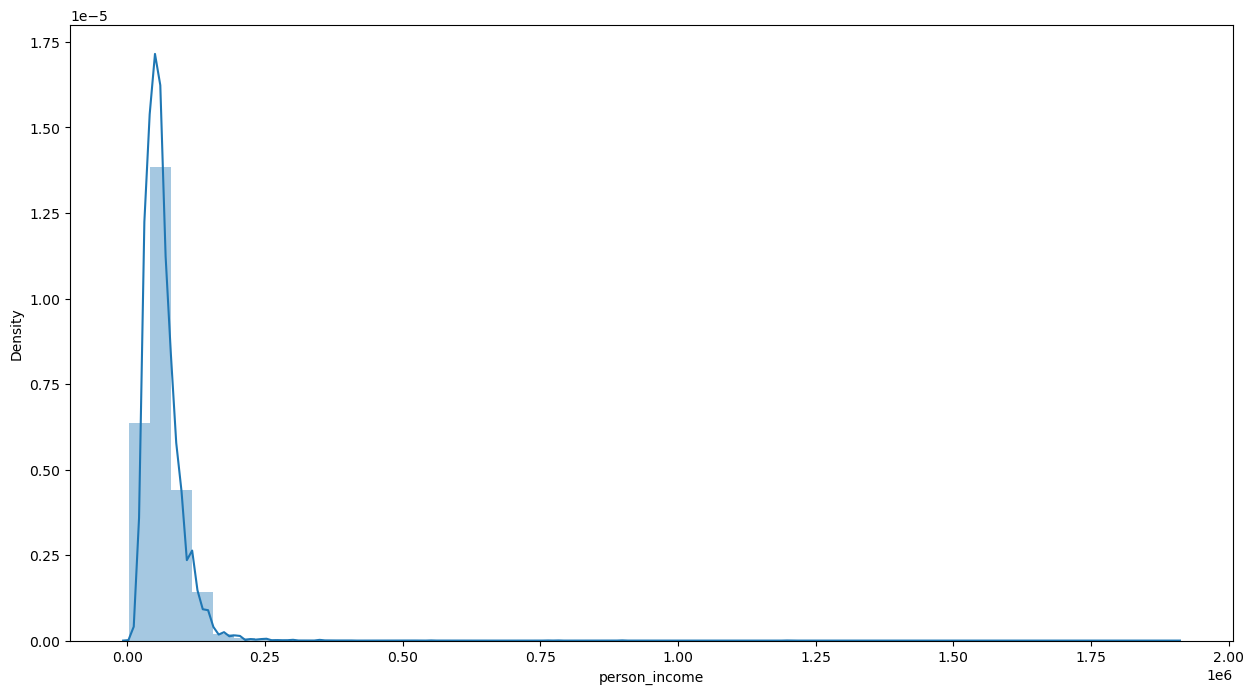

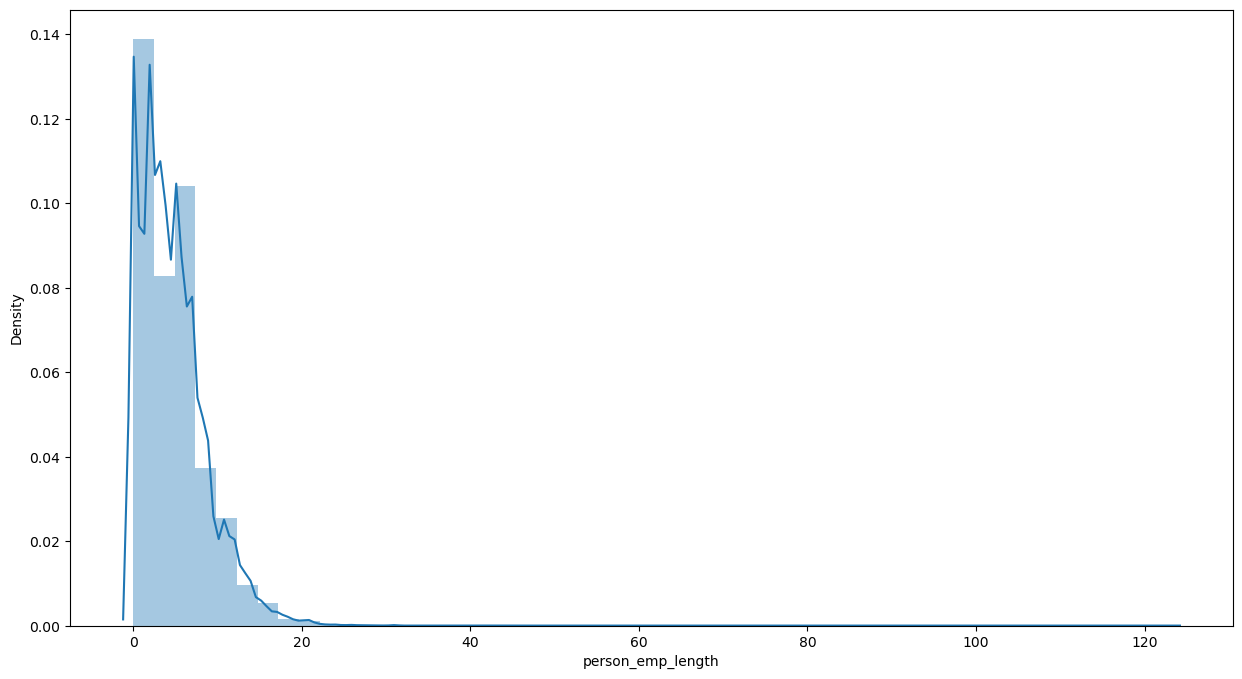

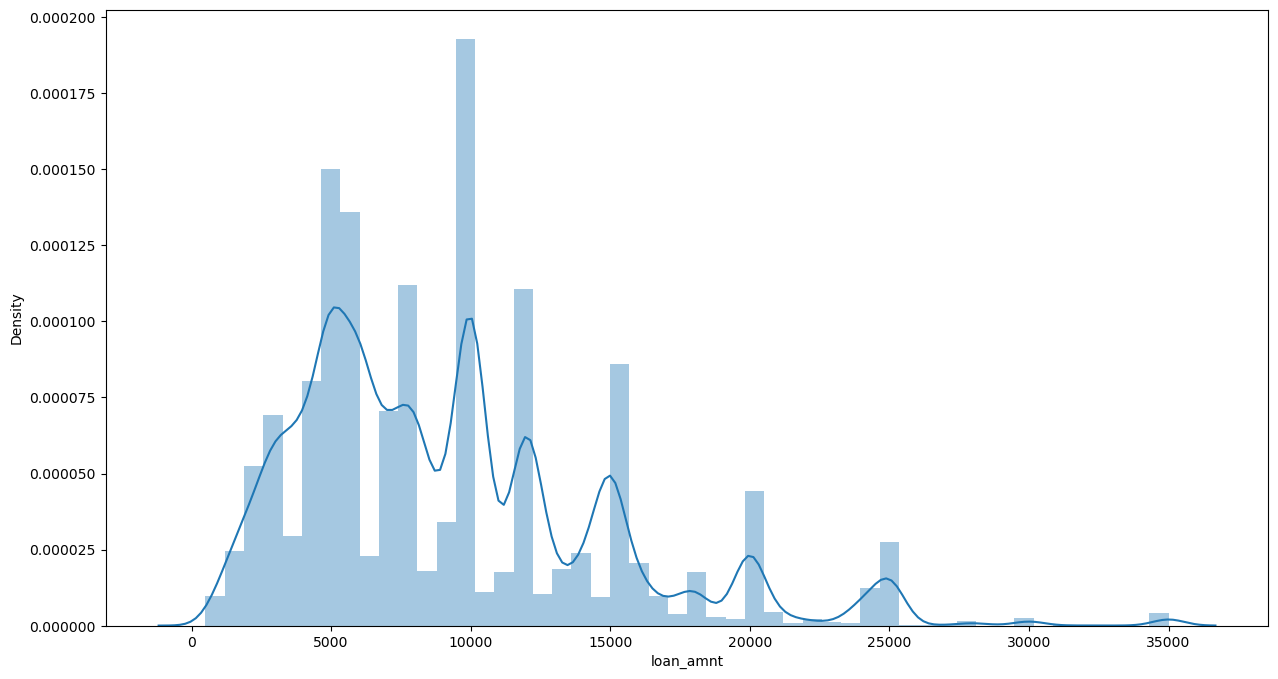

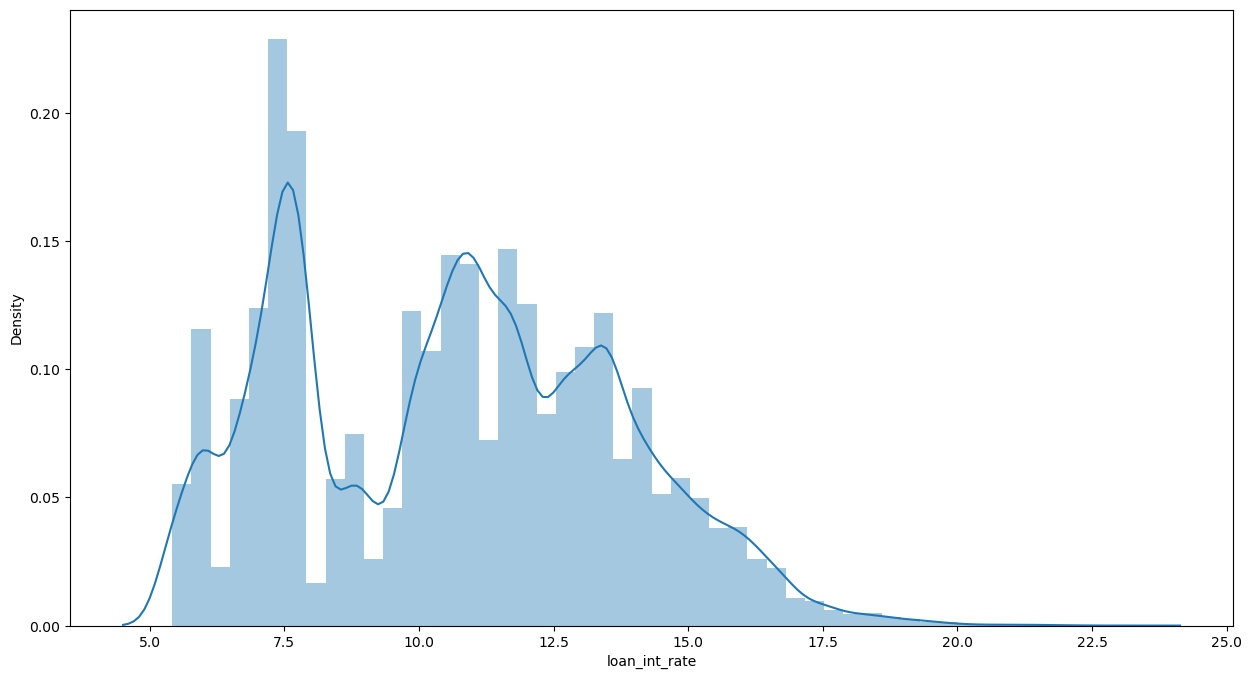

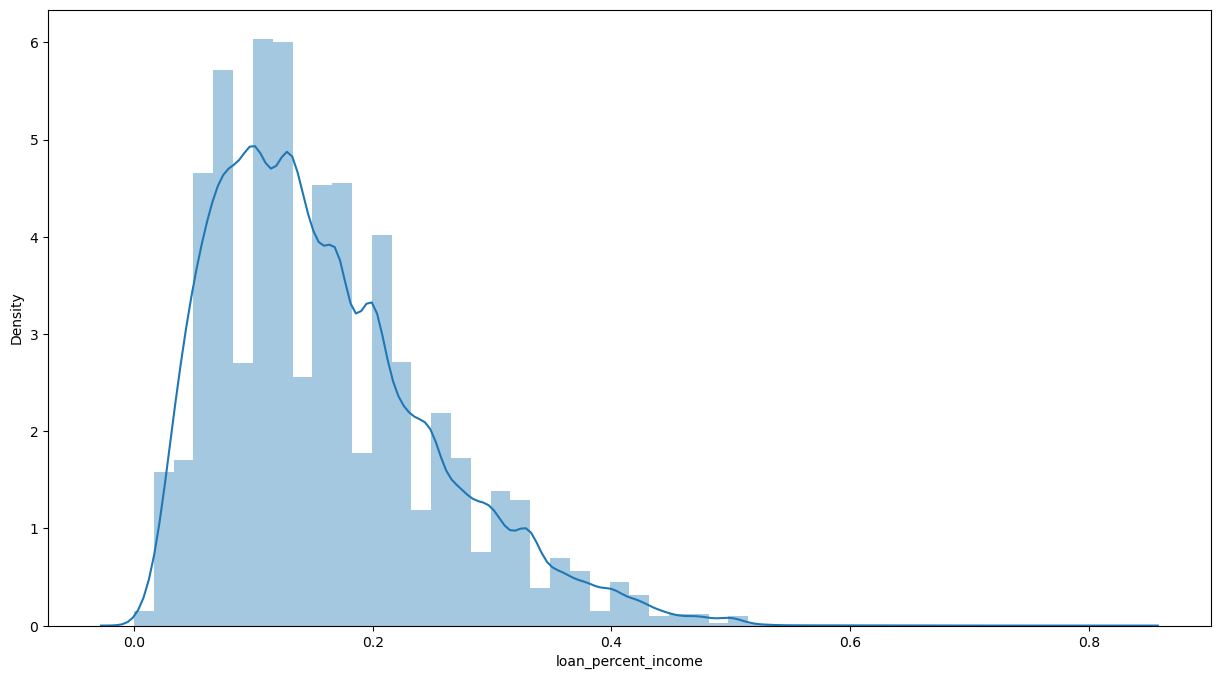

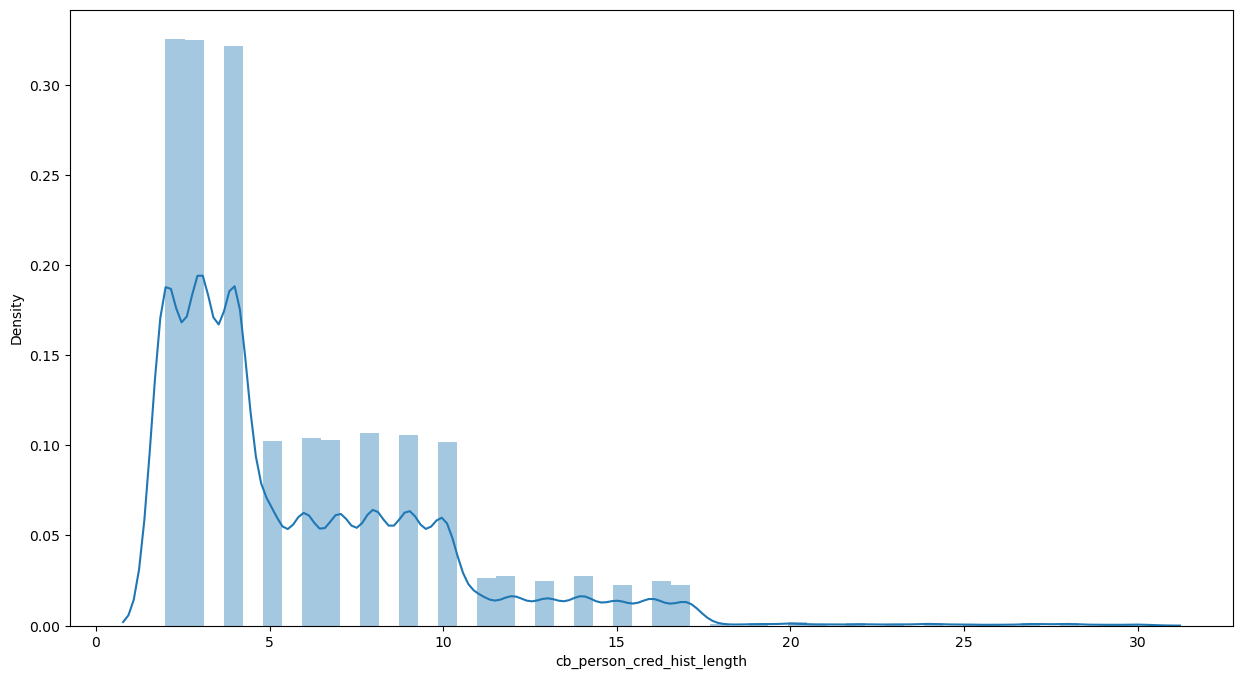

In [47]:
for i in num:
    sns.distplot(df[i])
    plt.show()

#### Categoric columns

In [48]:
for i in cat:
    print(df[i].unique())
    print()

['RENT' 'OWN' 'MORTGAGE' 'OTHER']

['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']

['B' 'C' 'A' 'D' 'E' 'F' 'G']

['N' 'Y']

[0.0 1.0 nan]



In [49]:
for i in cat:
    print(df[i].value_counts())
    print()

person_home_ownership
RENT        50874
MORTGAGE    41507
OWN          5194
OTHER         168
Name: count, dtype: int64

loan_intent
EDUCATION            20347
MEDICAL              18381
PERSONAL             16831
VENTURE              16643
DEBTCONSOLIDATION    15048
HOMEIMPROVEMENT      10493
Name: count, dtype: int64

loan_grade
A    34989
B    34004
C    18496
D     8303
E     1646
F      254
G       51
Name: count, dtype: int64

cb_person_default_on_file
N    83170
Y    14573
Name: count, dtype: int64

loan_status
0.0    50295
1.0     8350
Name: count, dtype: int64



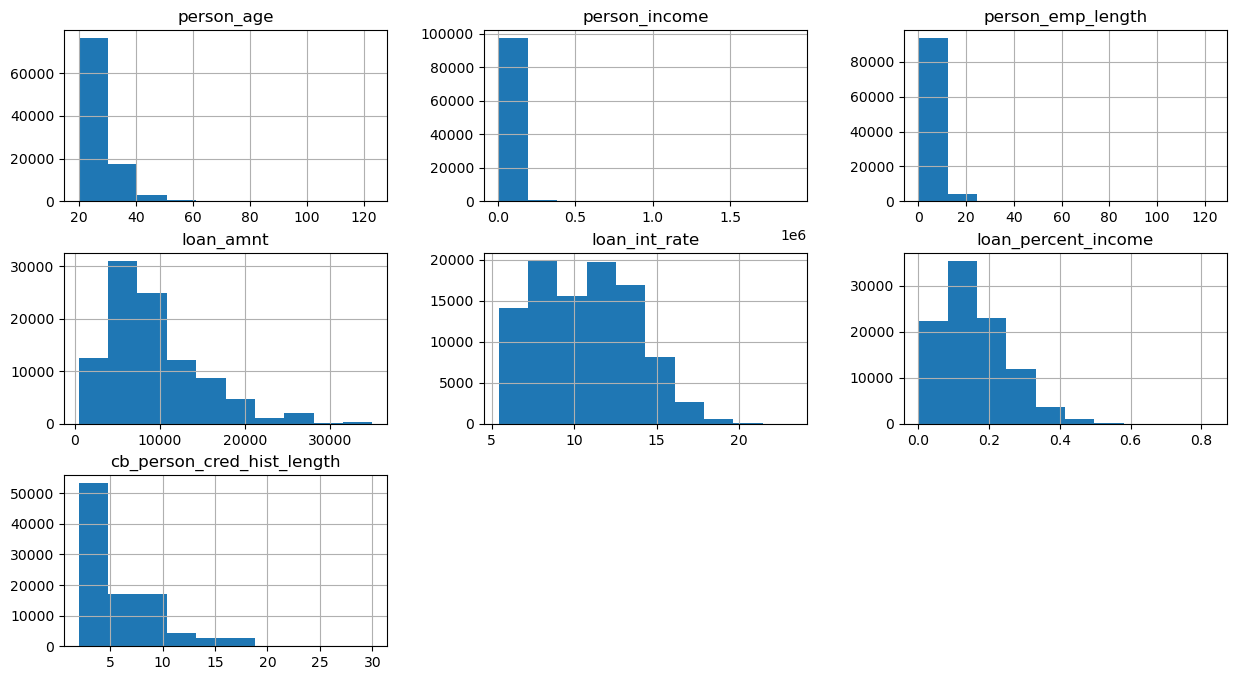

In [50]:
df[num].hist()
plt.show()

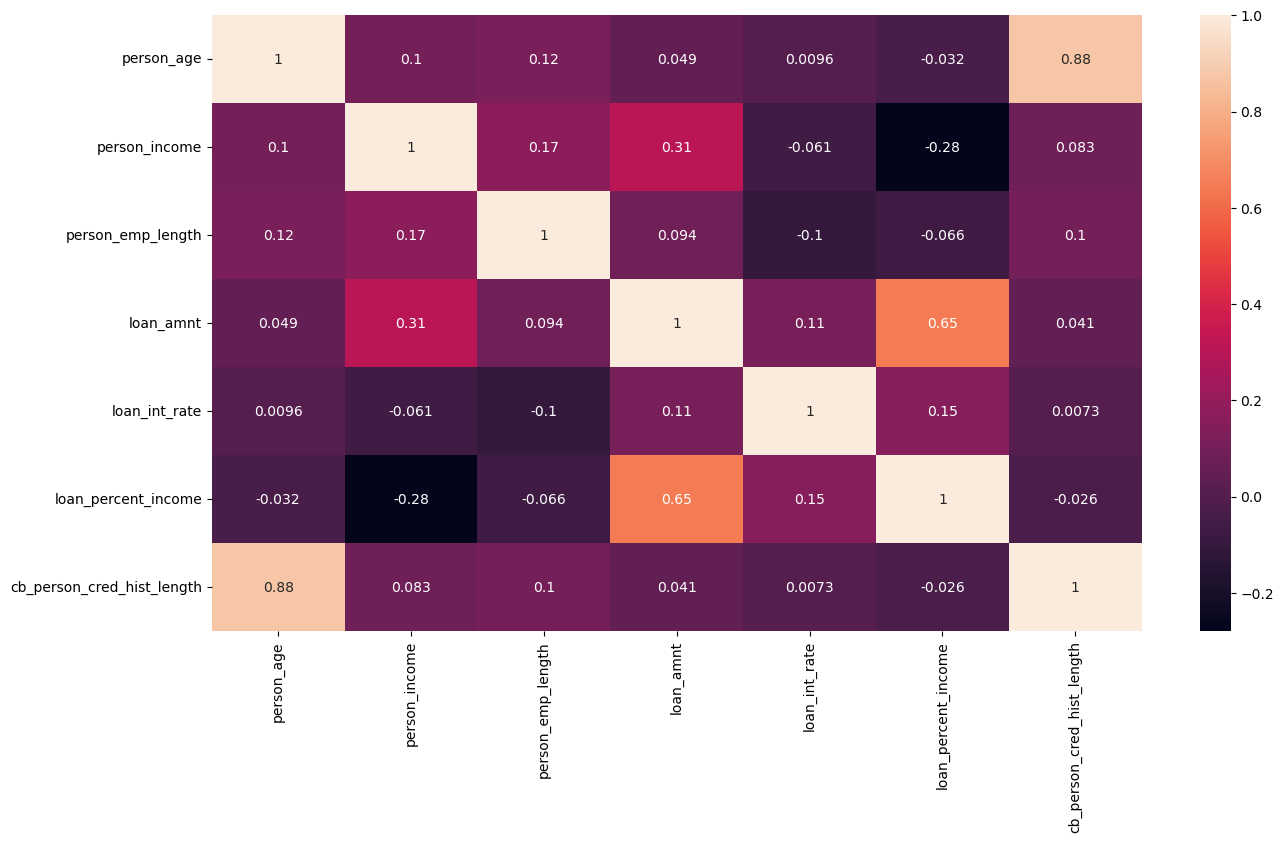

In [51]:
sns.heatmap(df[num].corr(), annot=True)
plt.show()

**Inference**
* Person Age and Credit History Length(0.88): There is a high positive correlation between person's age and their credit history length.
* Loan amount and Income(0.31): The correlation between person's income and the loan amount is positive and moderately strong.
* Loan amount and Percentage of income(0.65): There is a strong positive correlation between the loan amount and loan percent income.
* Credit history length and loan percent income(-0.026): There is a very slight negative correlation between credit history length and loan percent income.
* Person age and employment length (0.12): There is a positive, though weak, correlation between person's age and employment length.

## Bivariate Analysis

#### Let's see the distribution of the target variables:

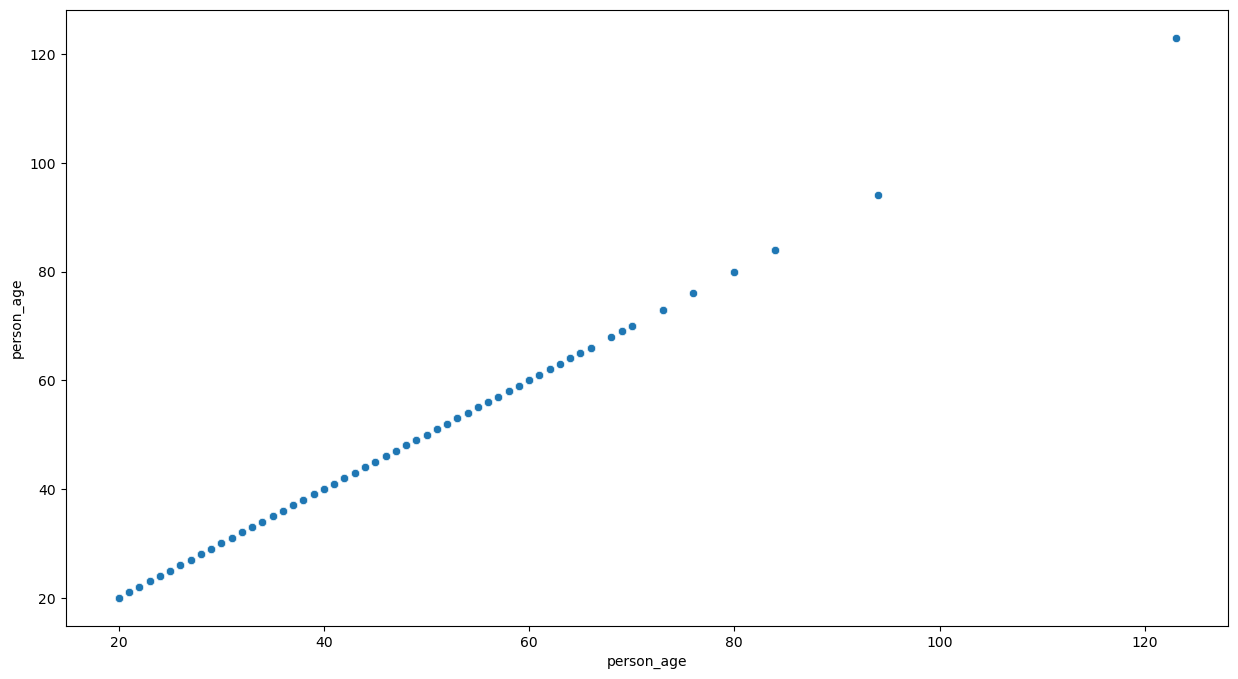

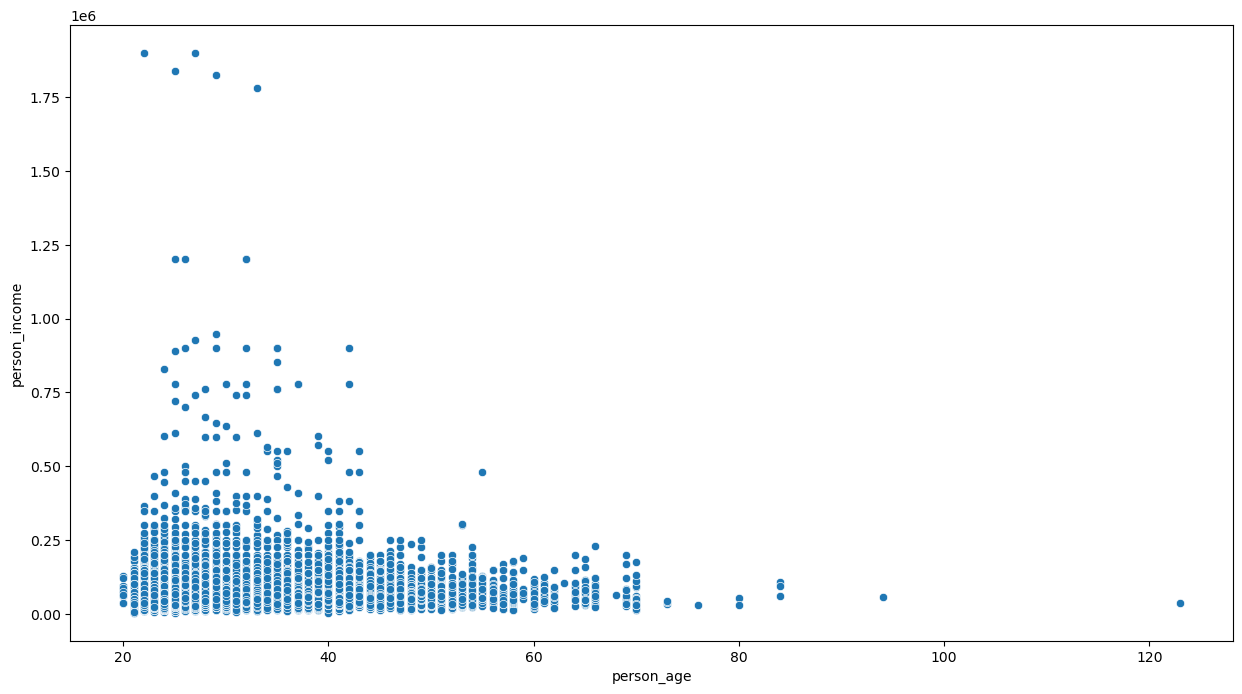

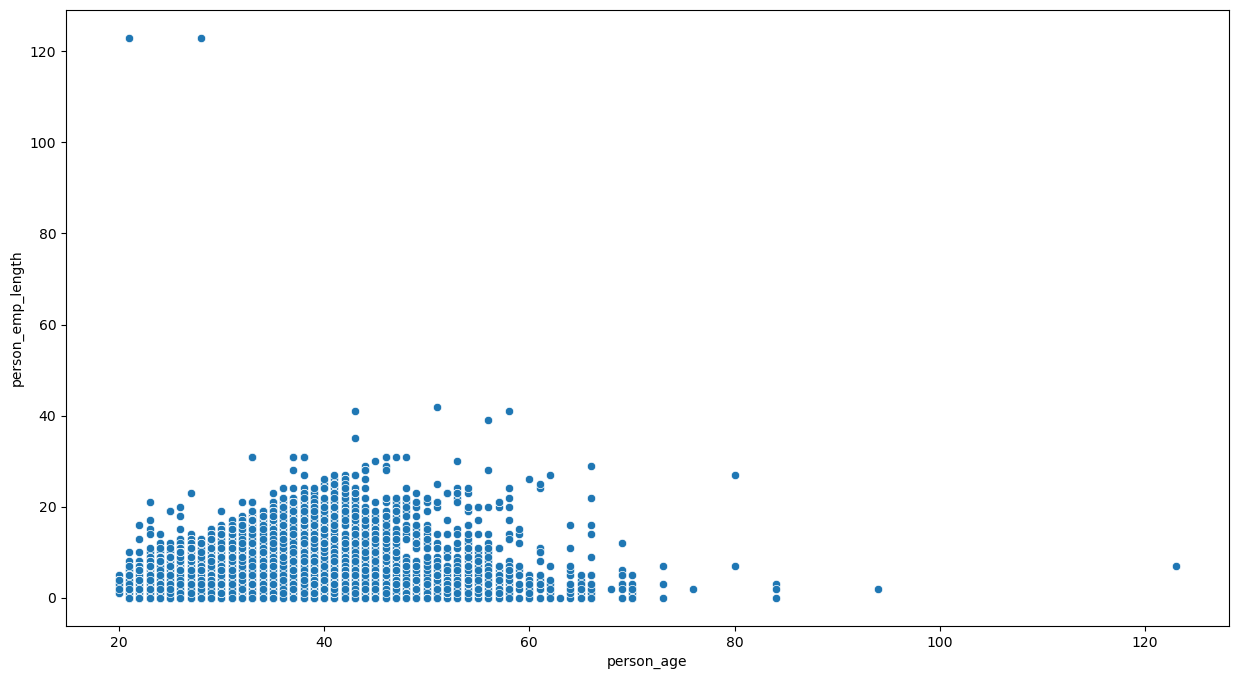

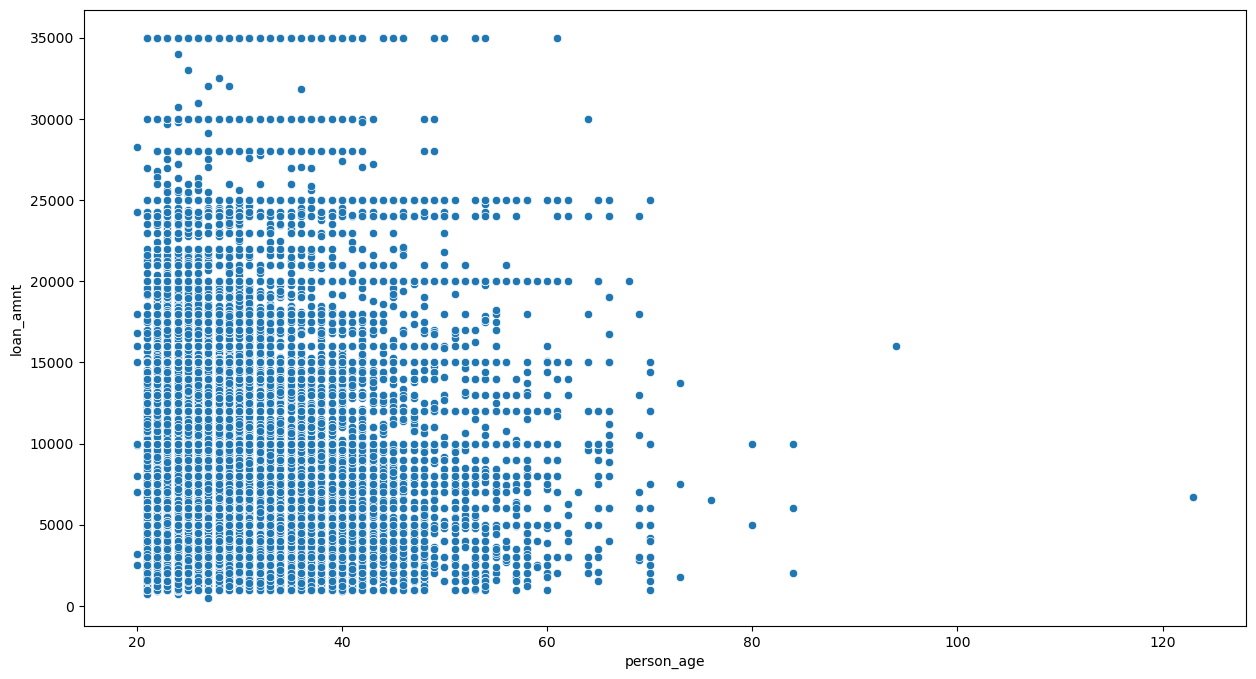

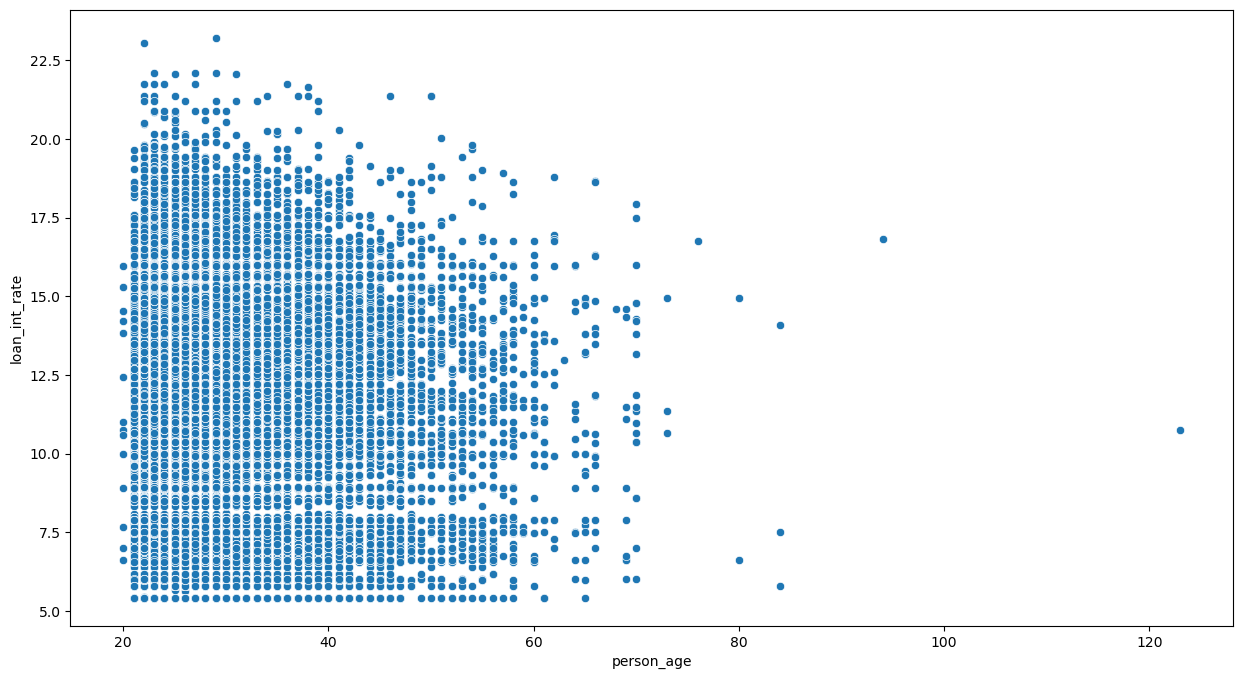

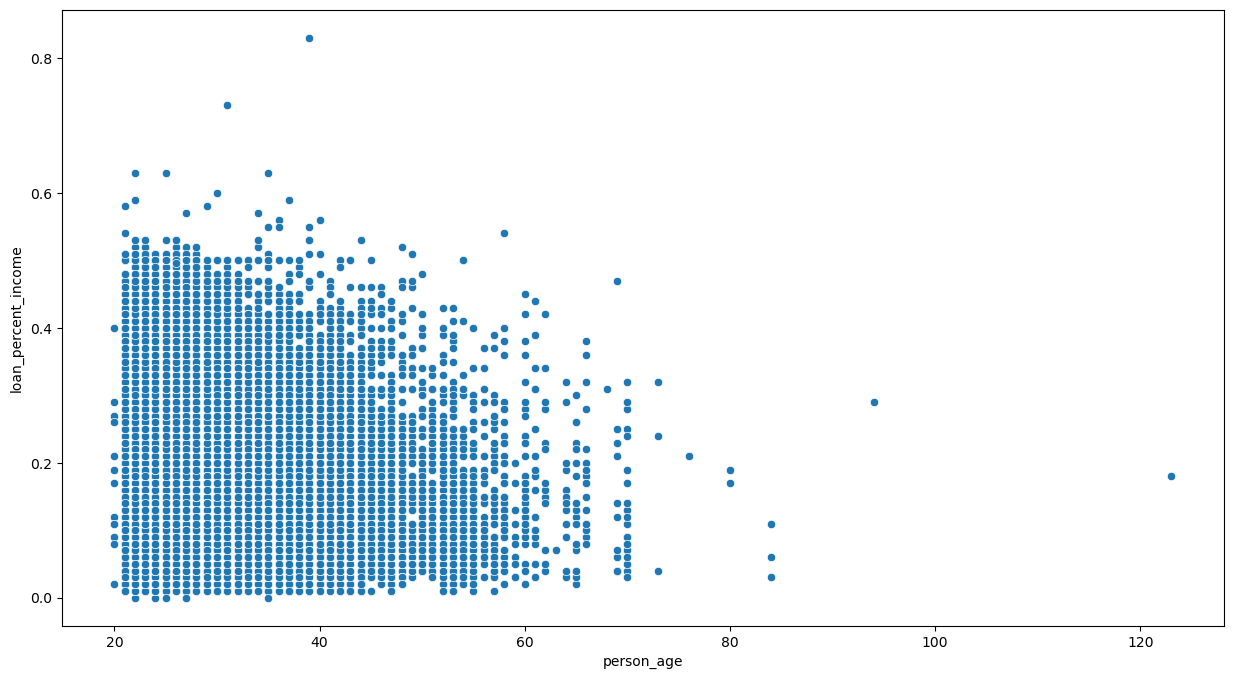

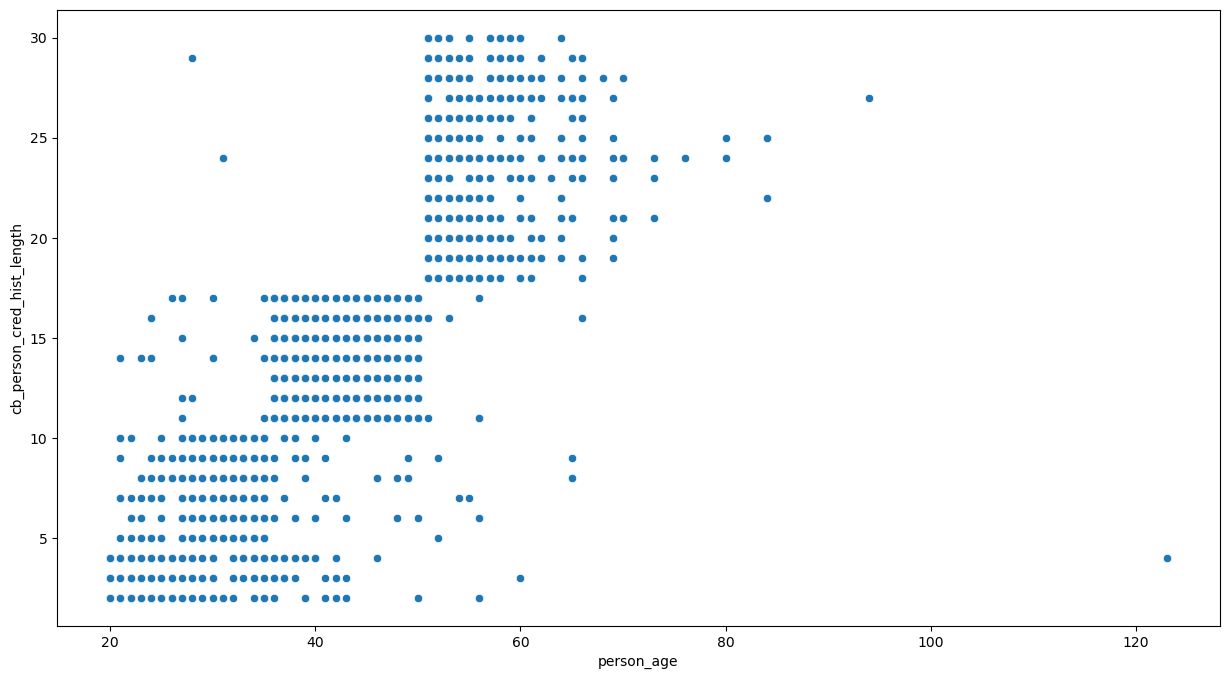

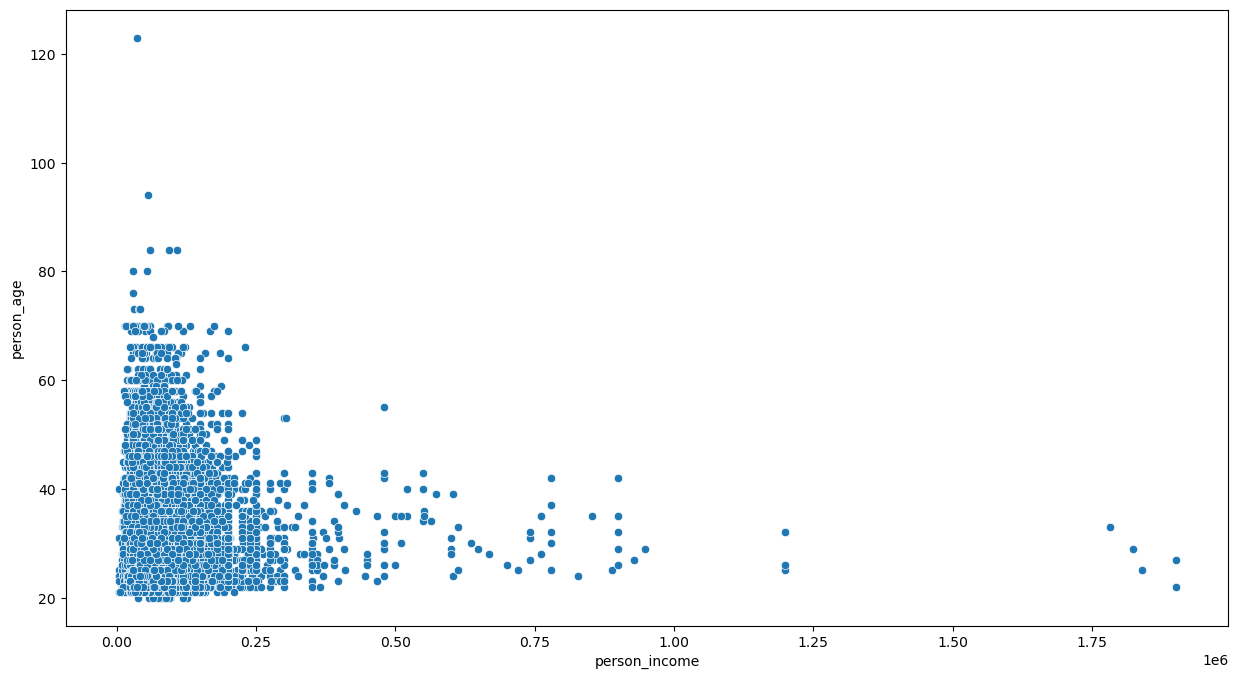

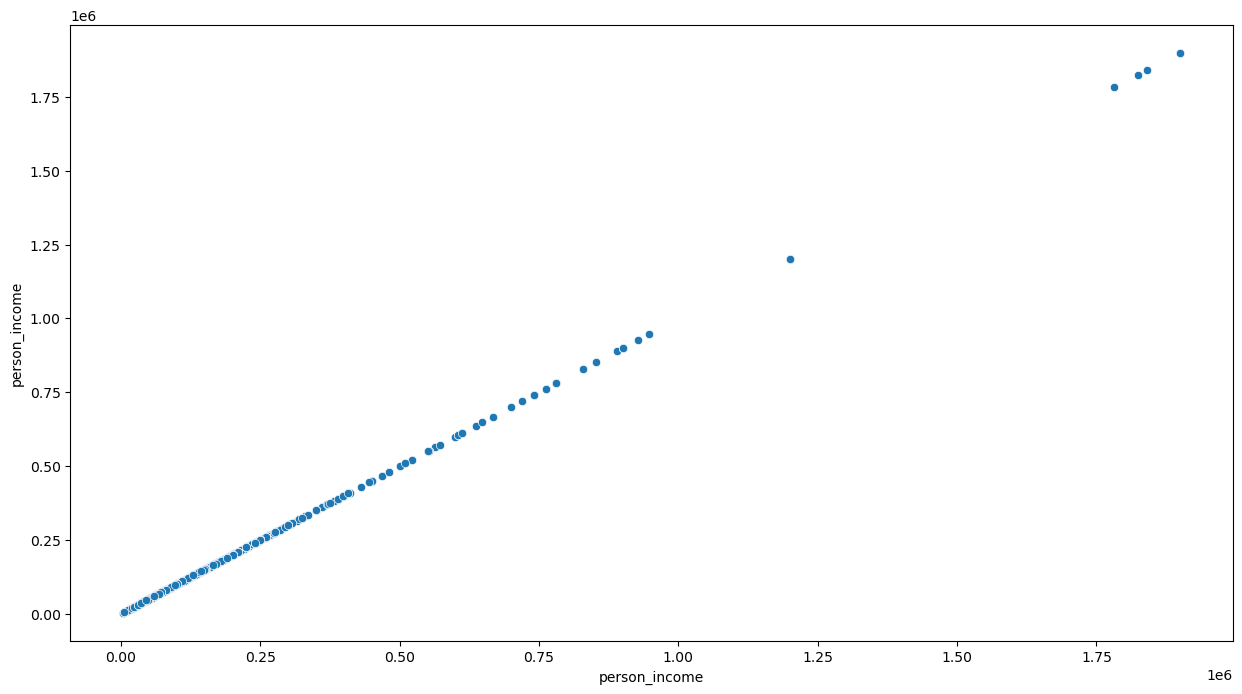

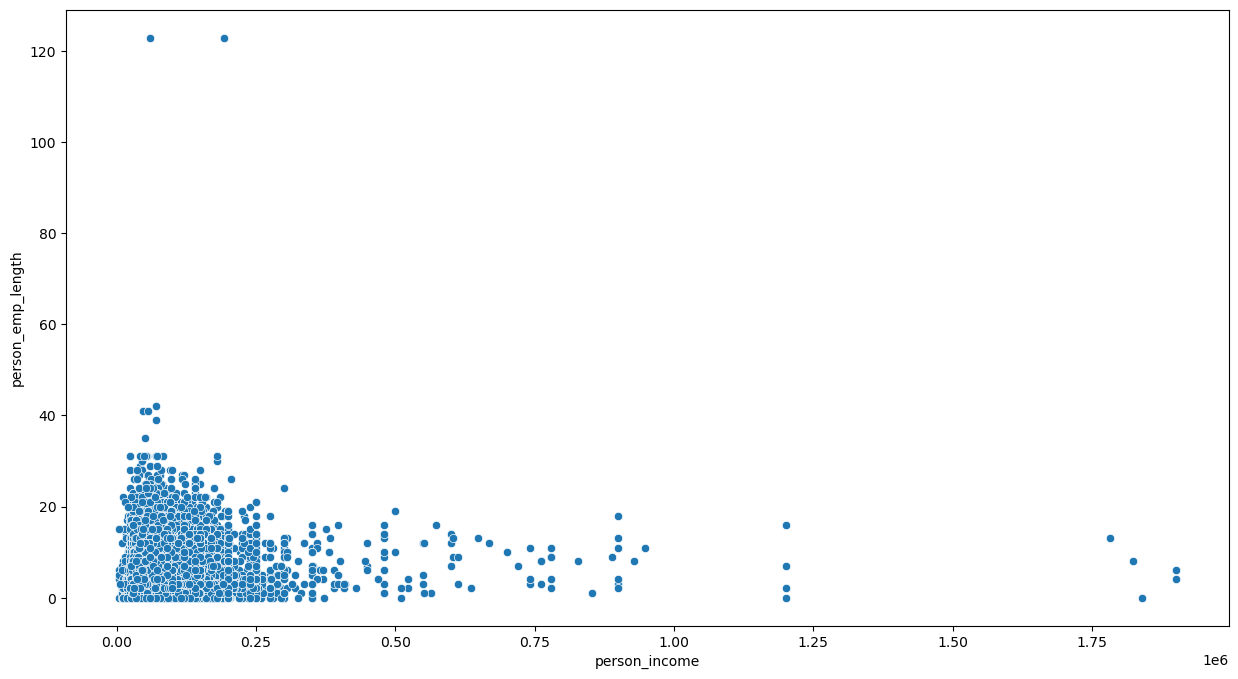

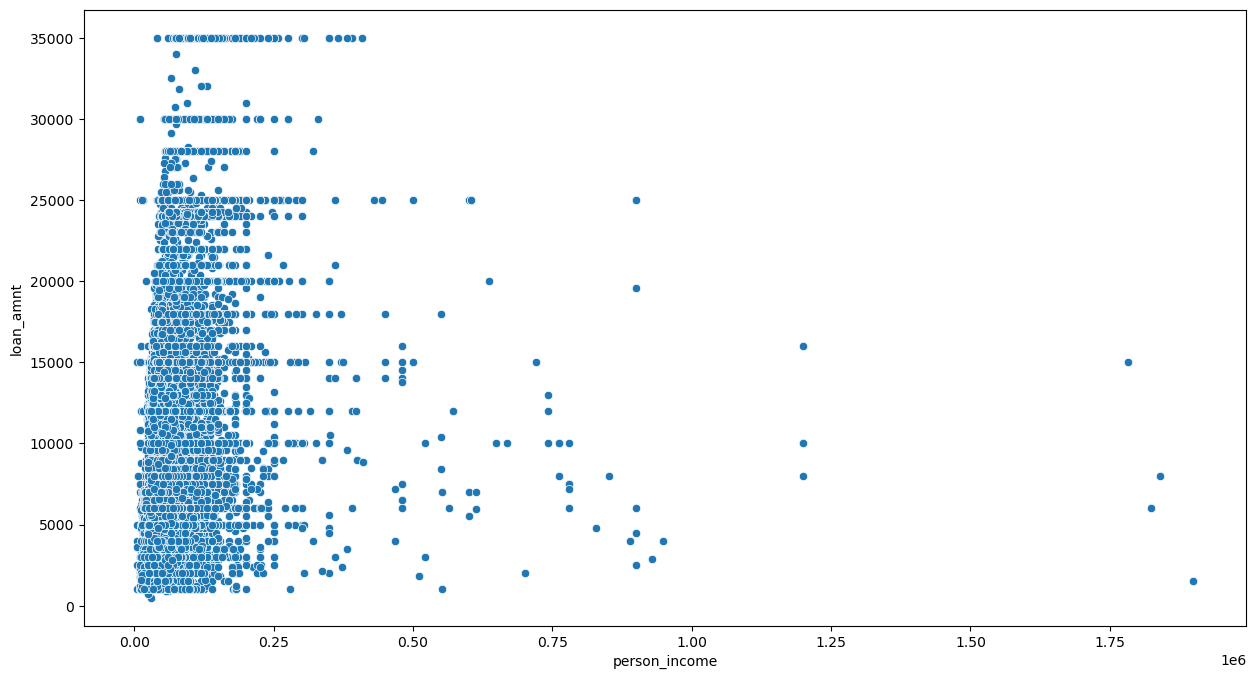

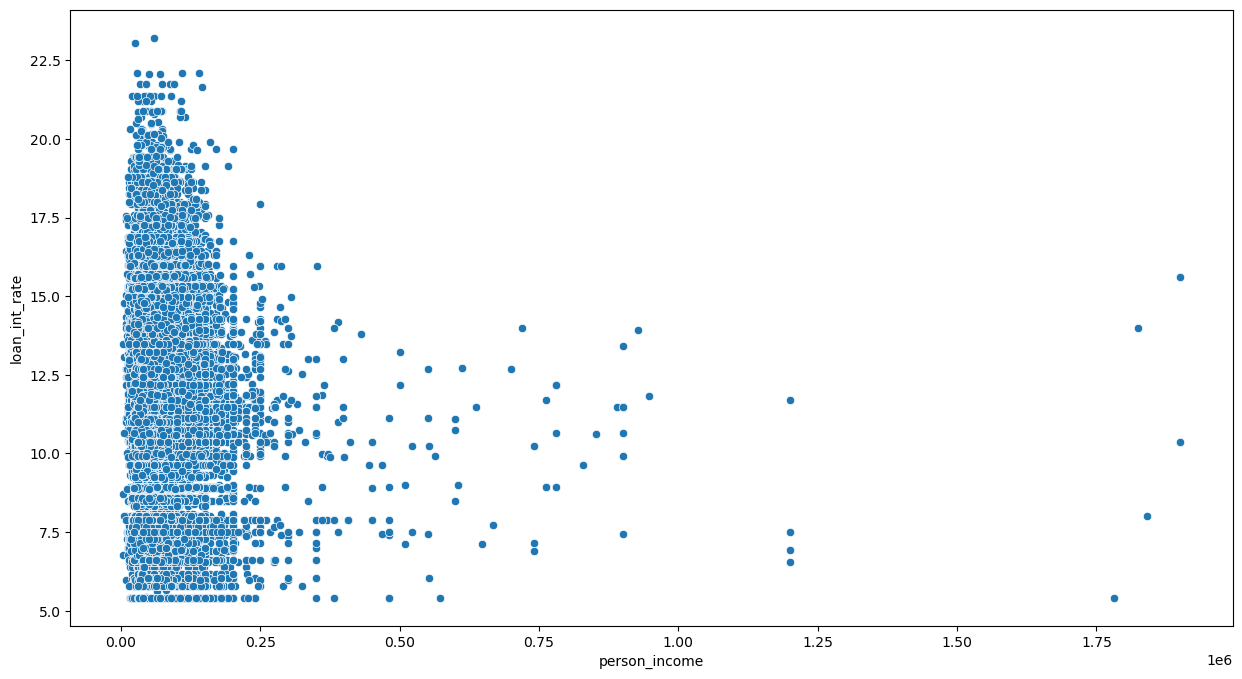

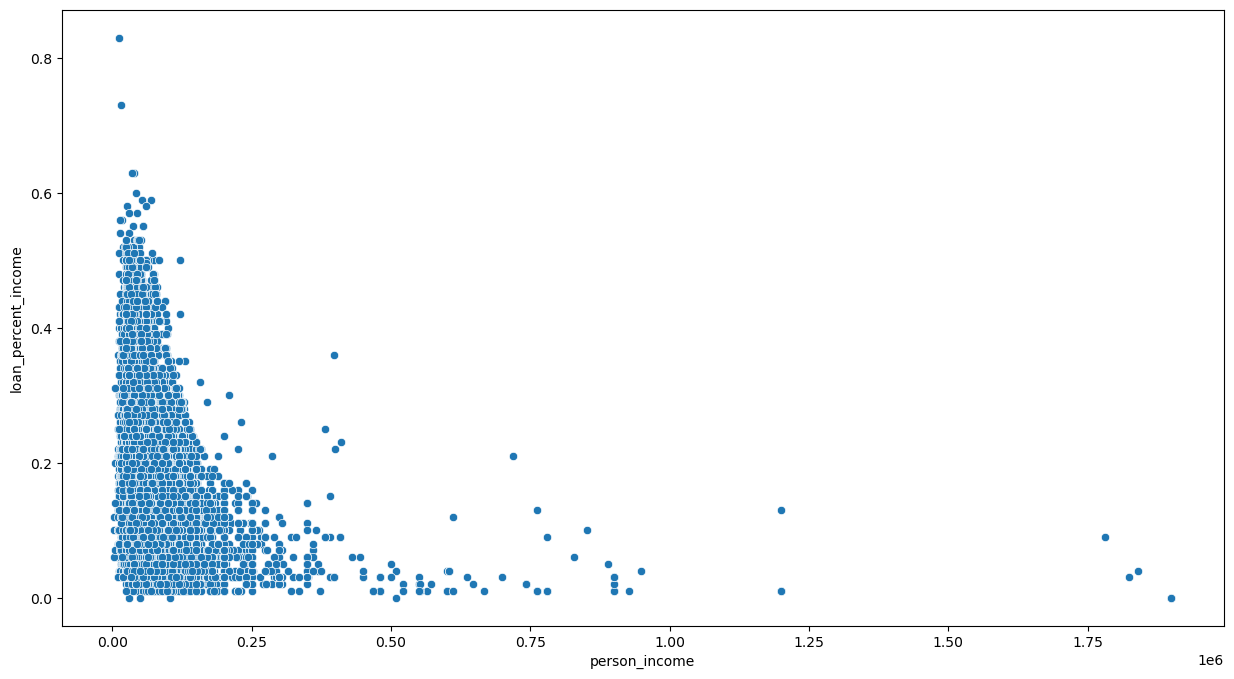

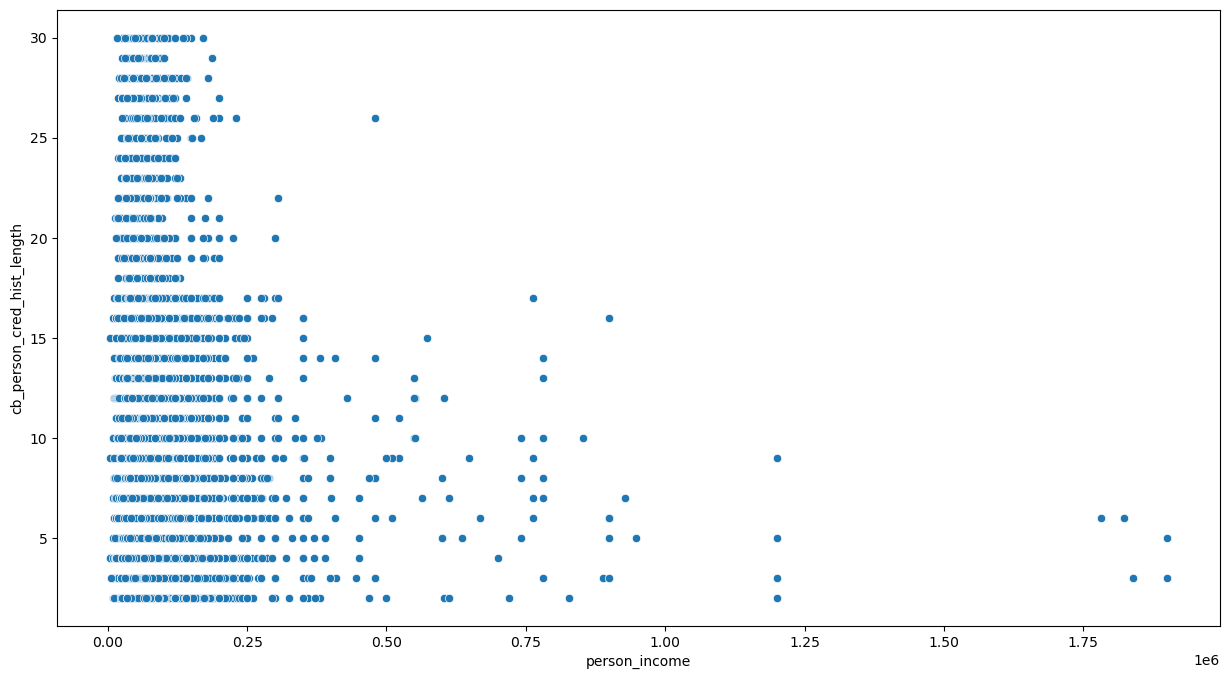

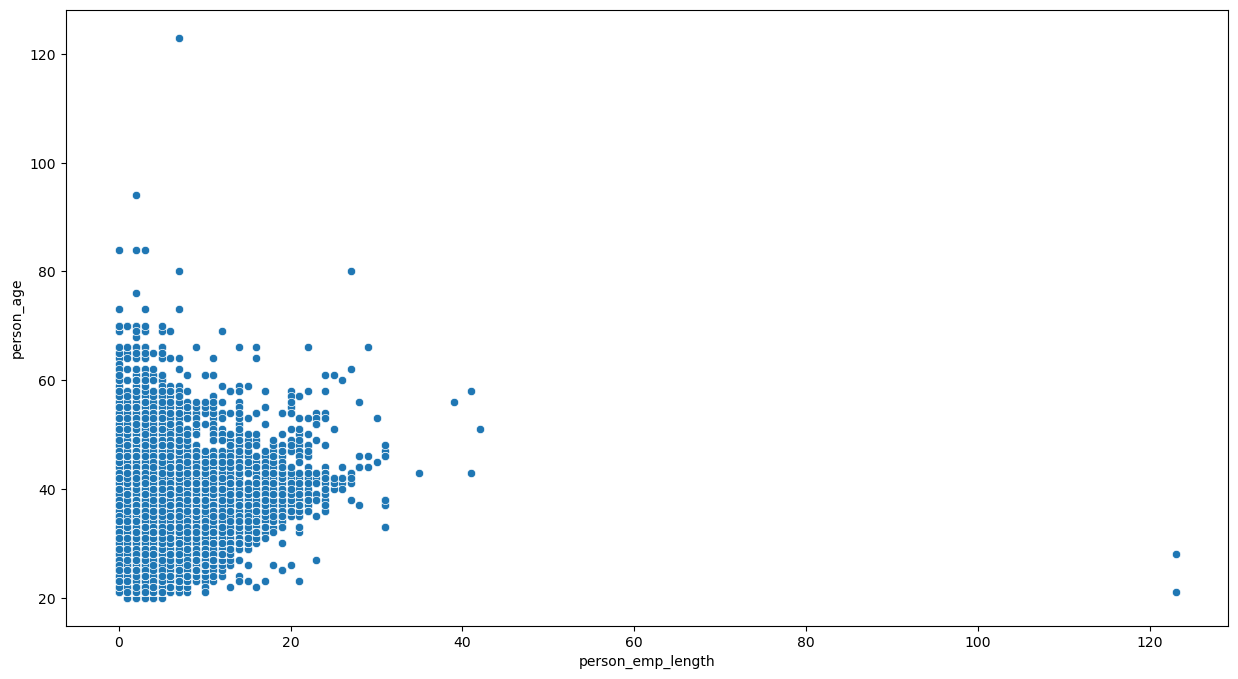

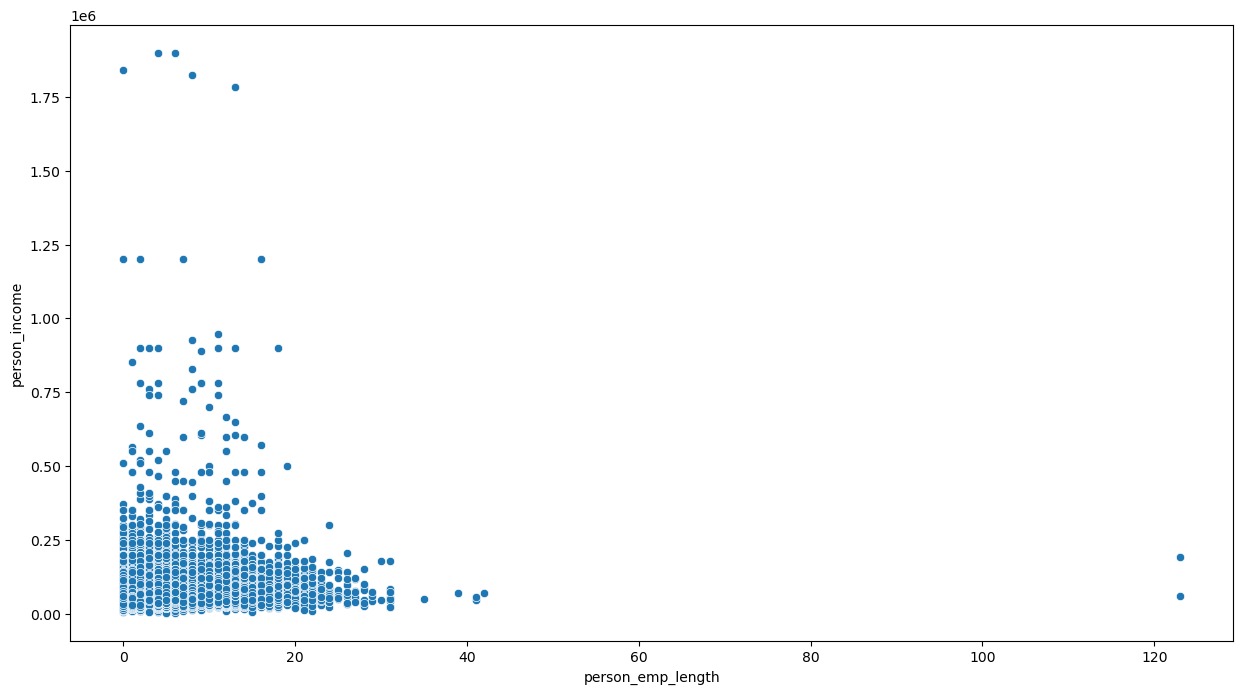

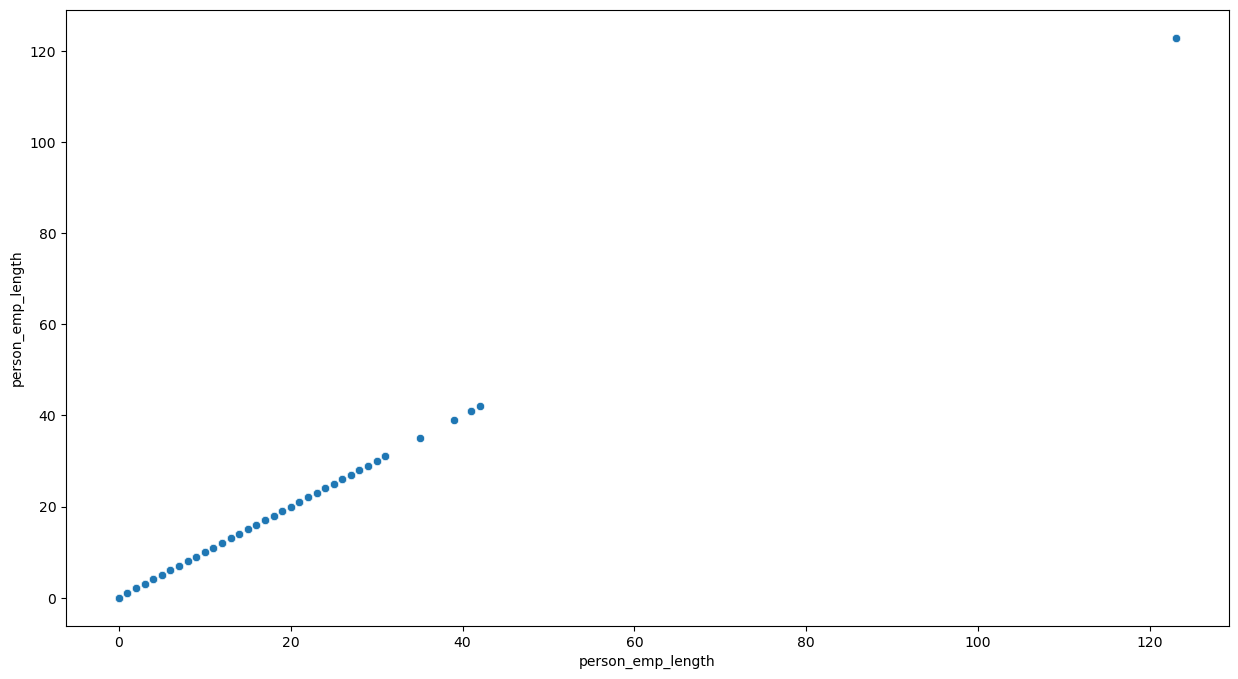

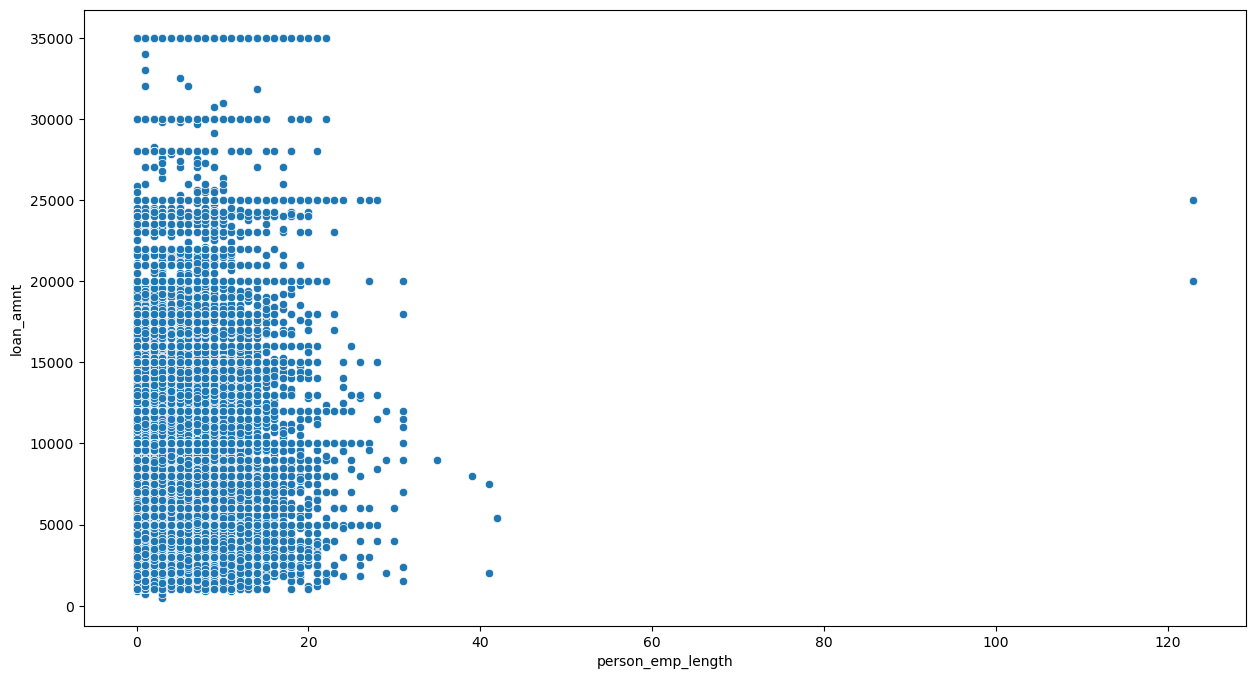

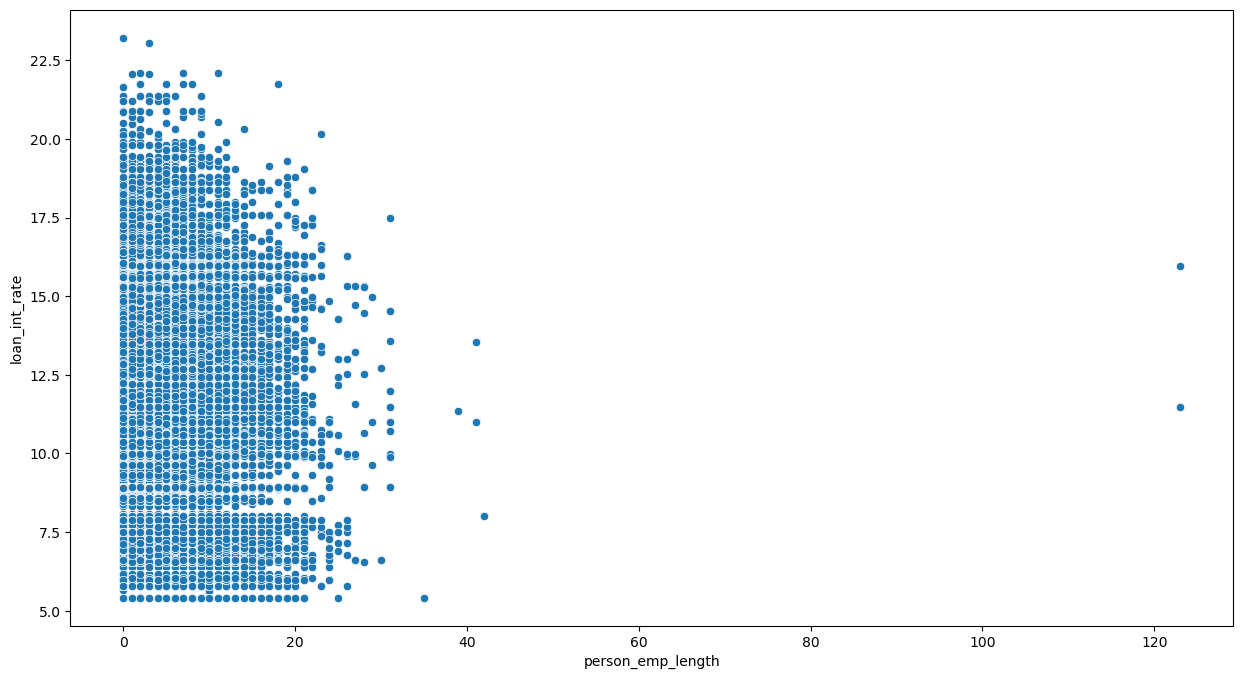

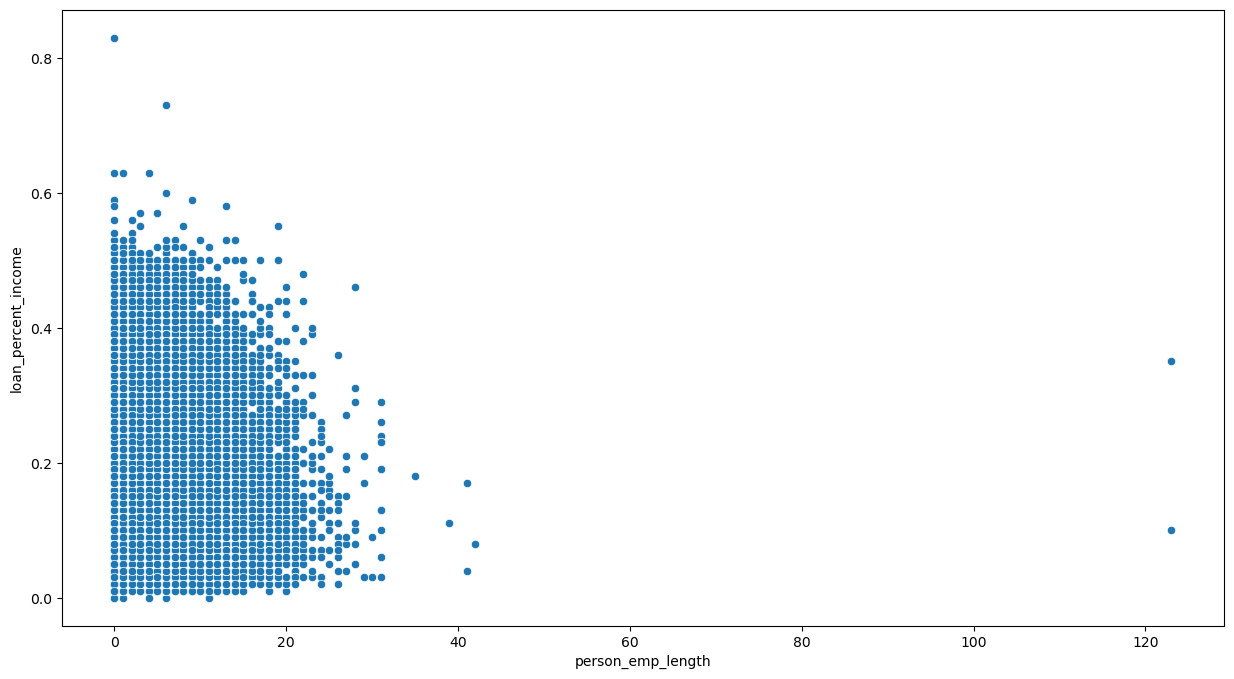

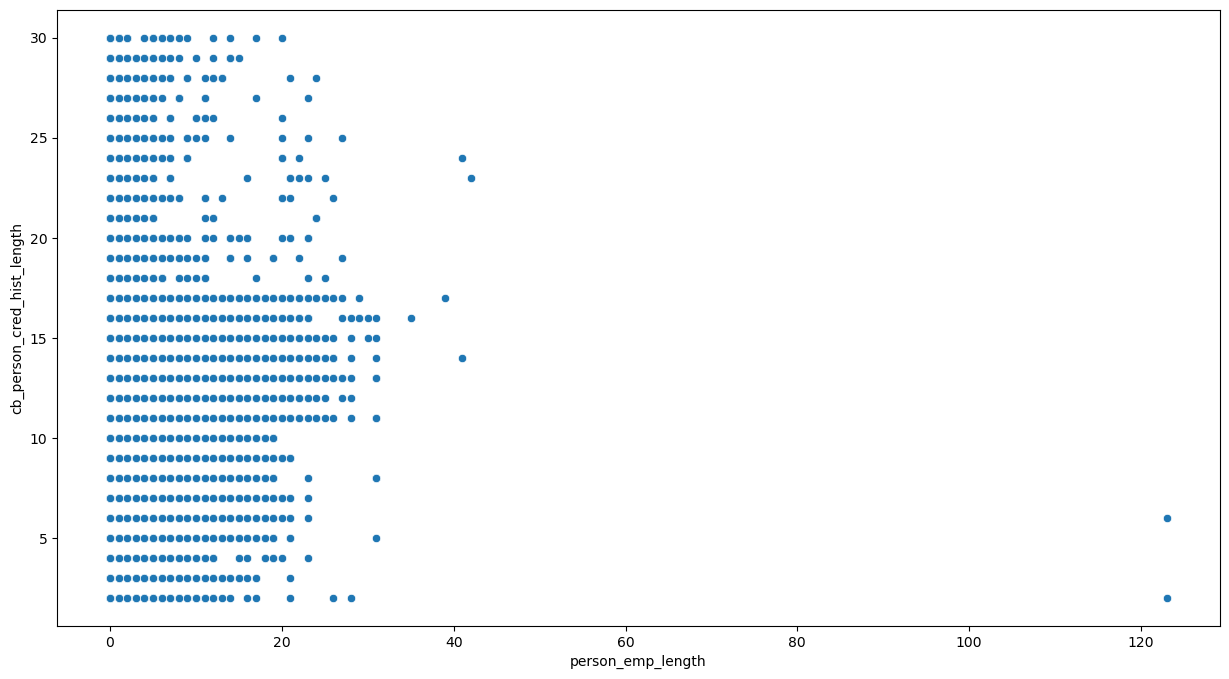

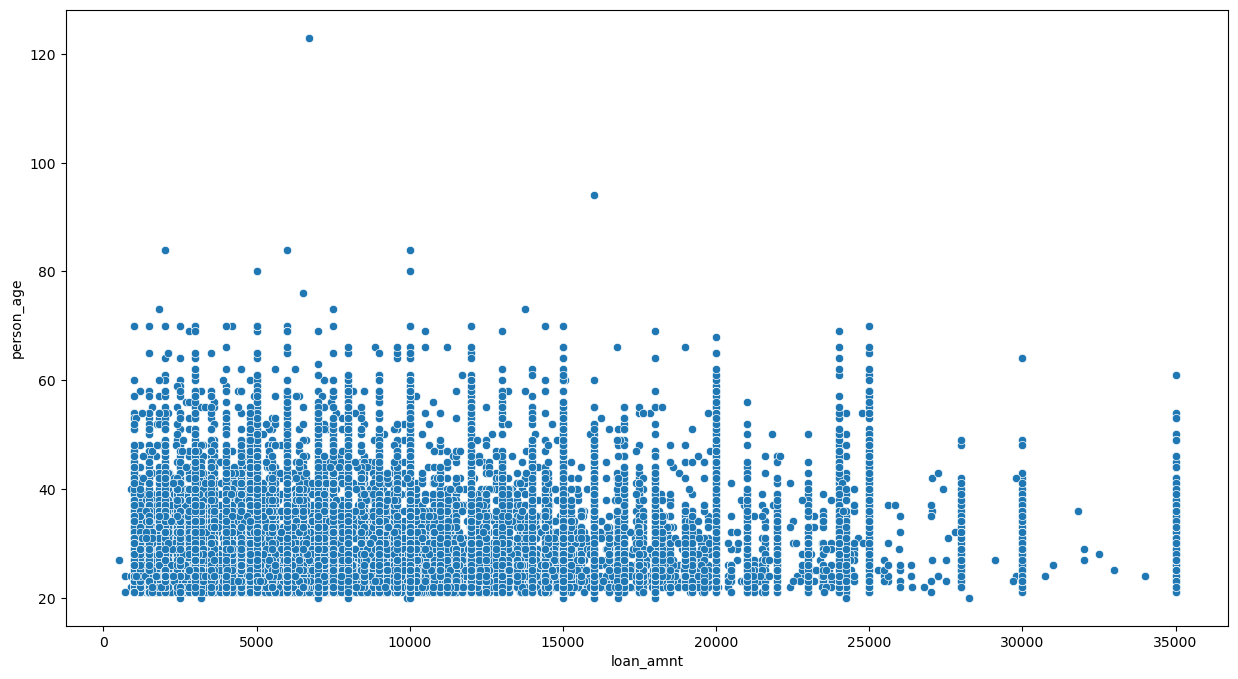

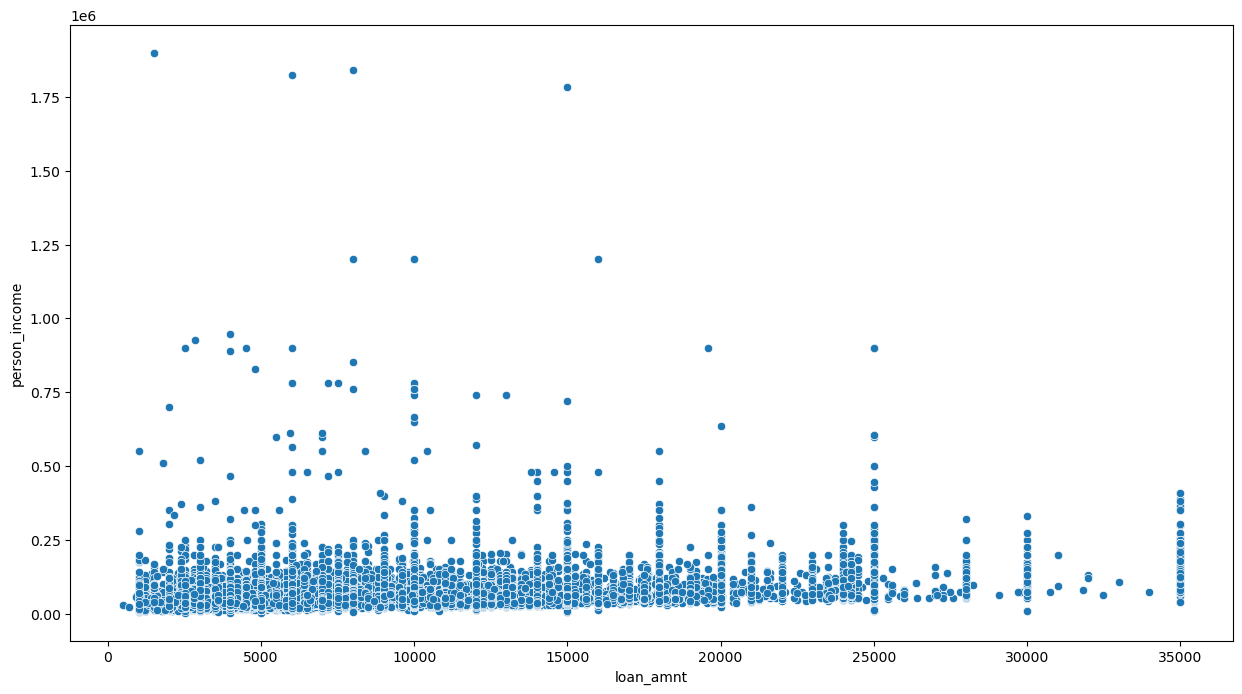

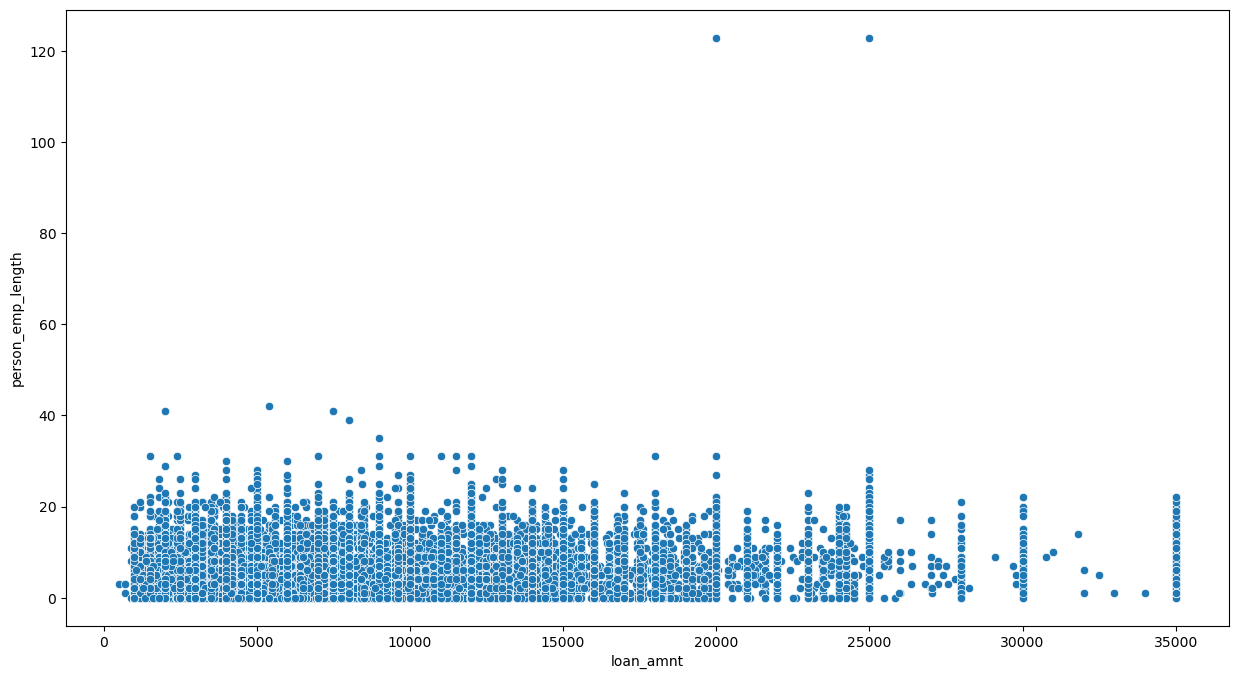

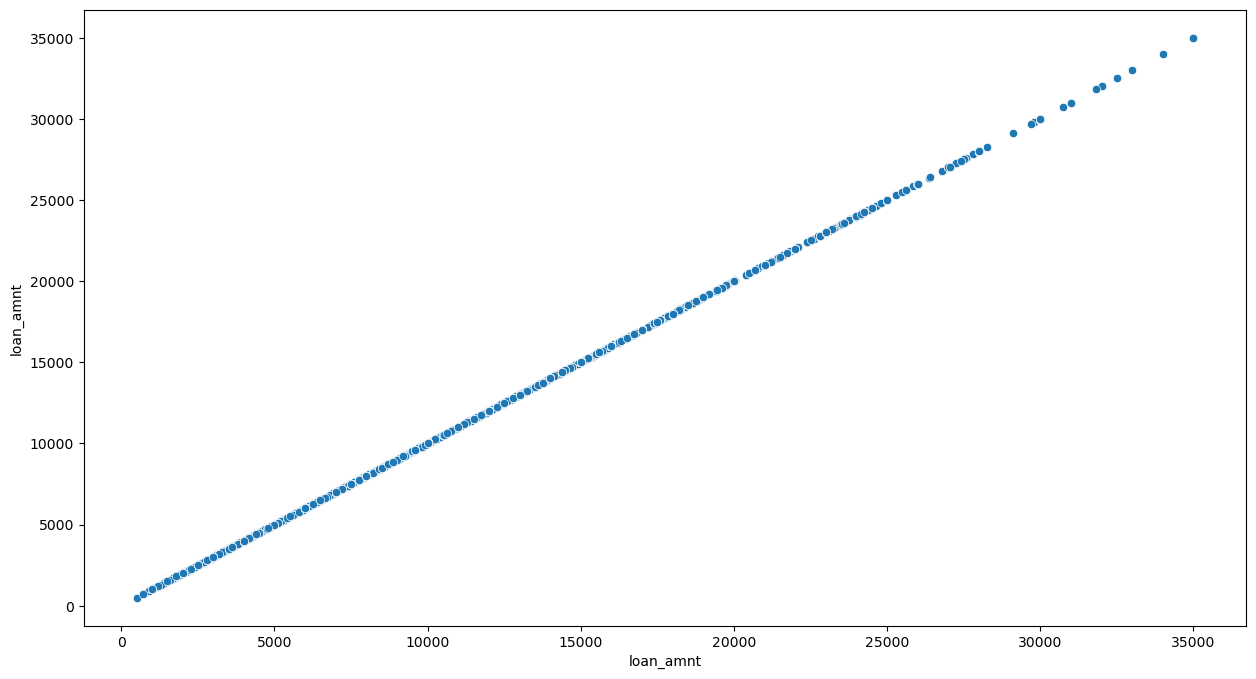

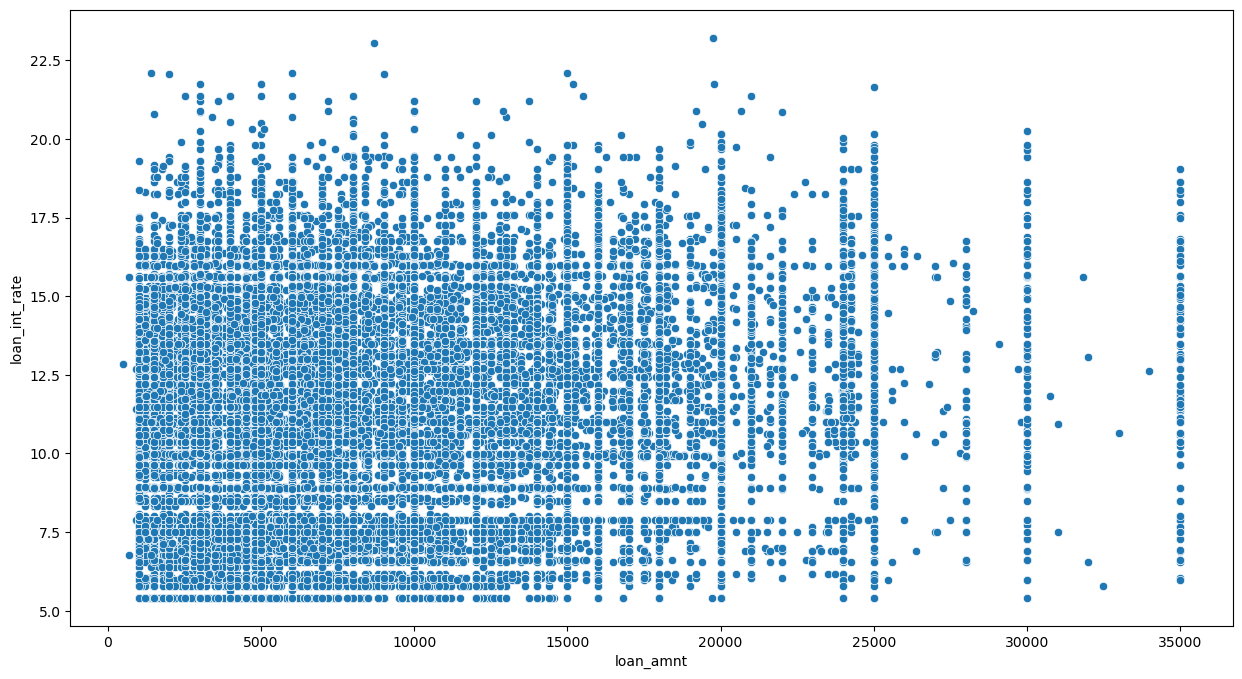

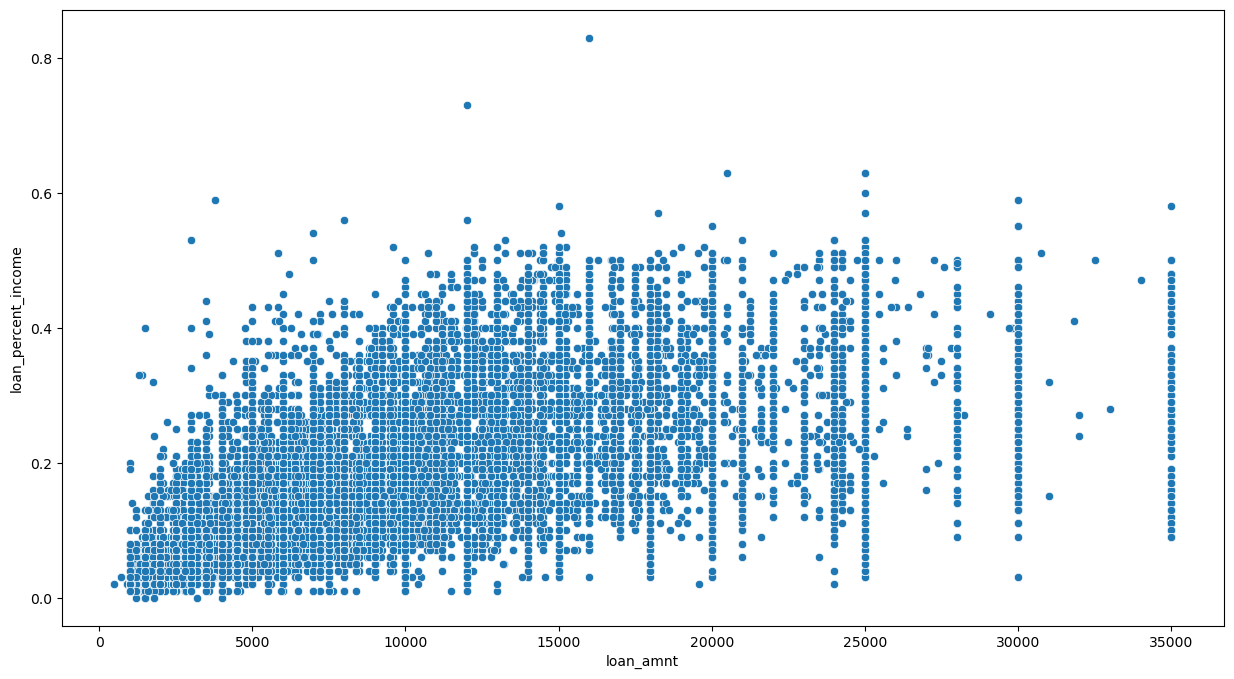

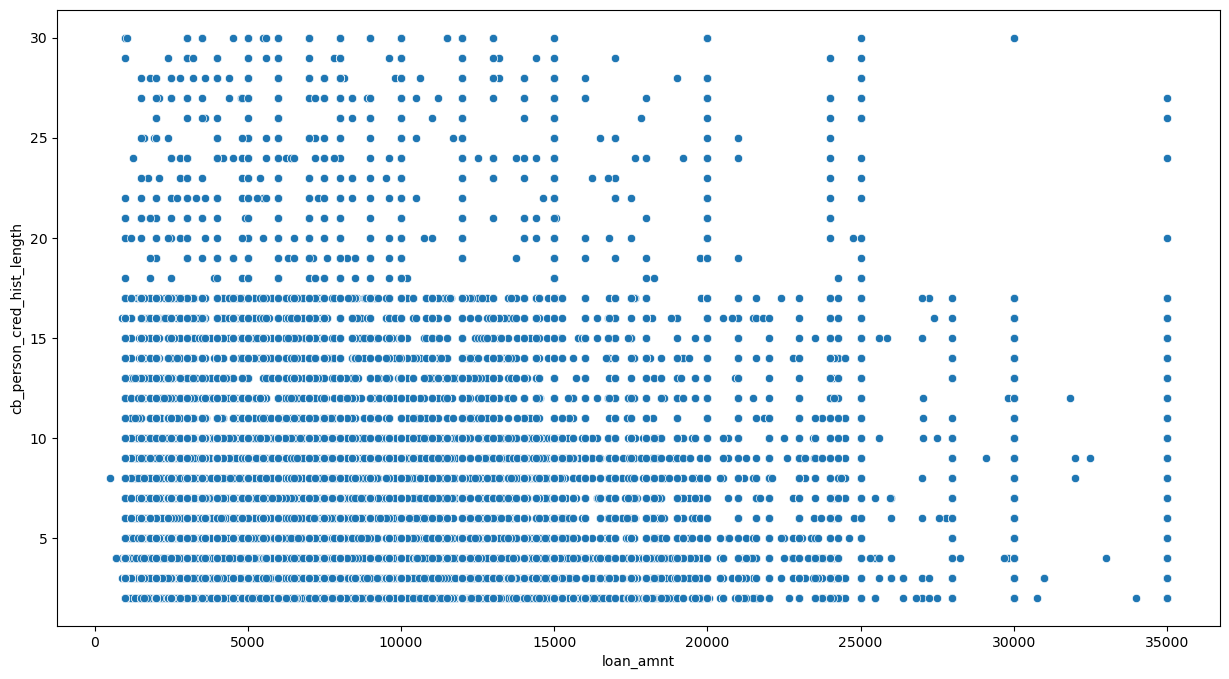

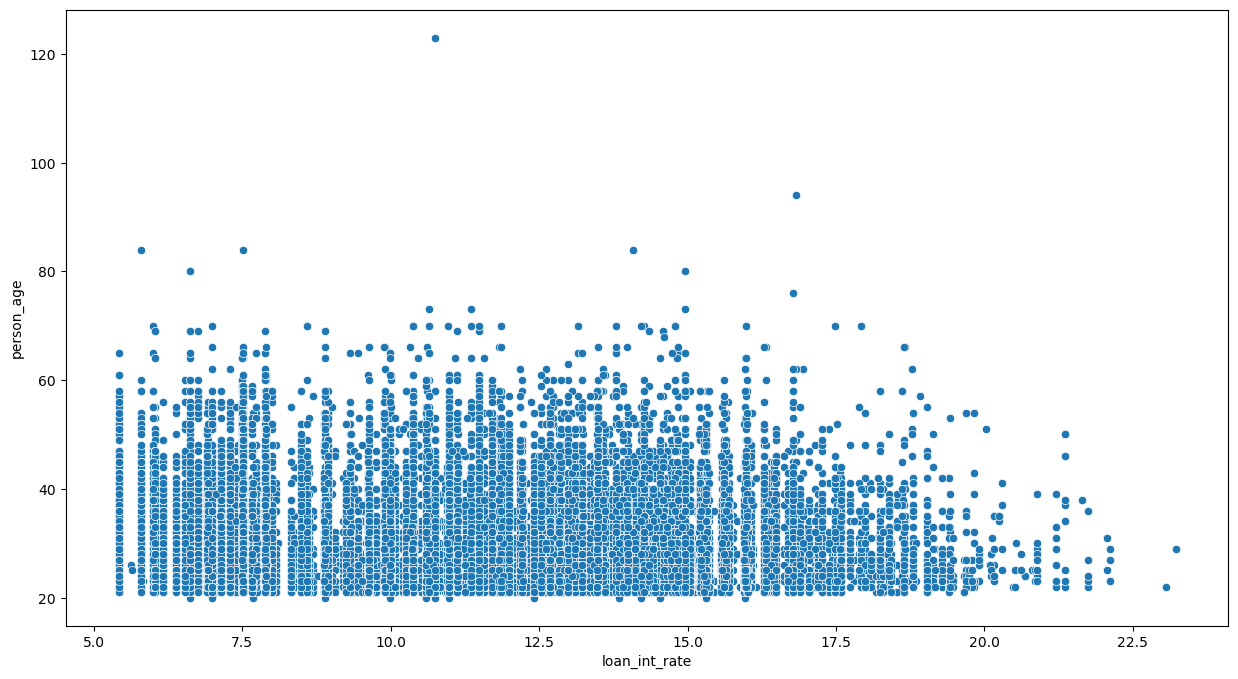

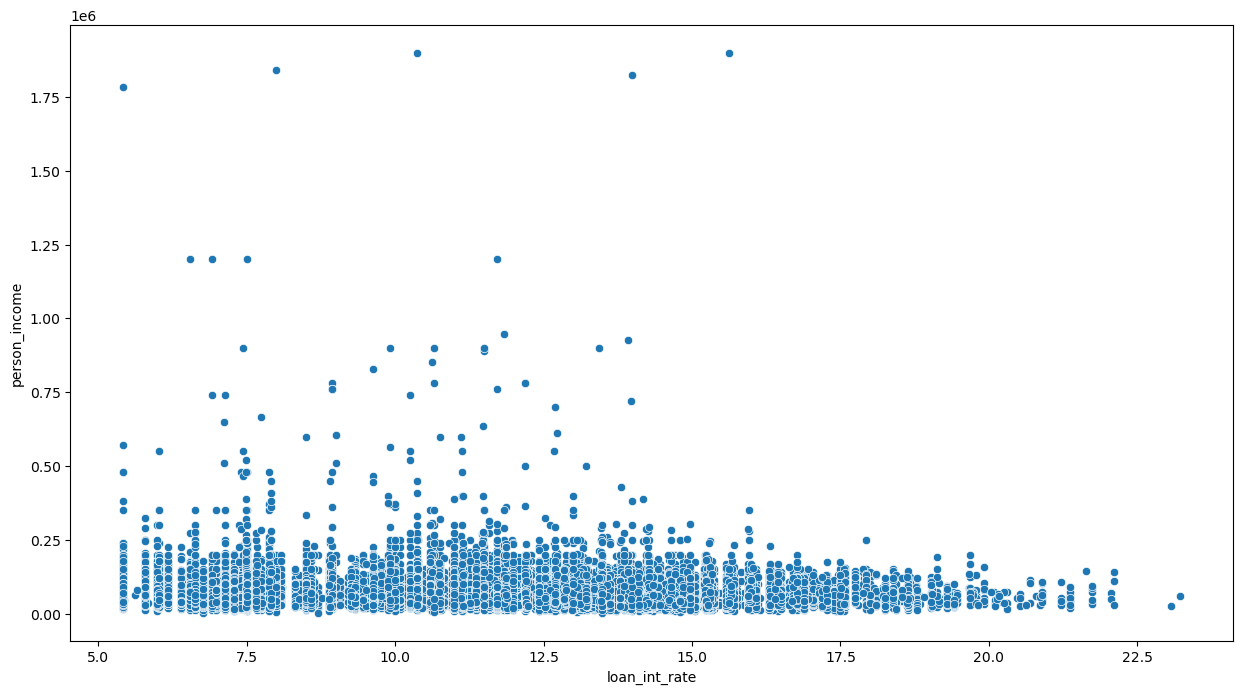

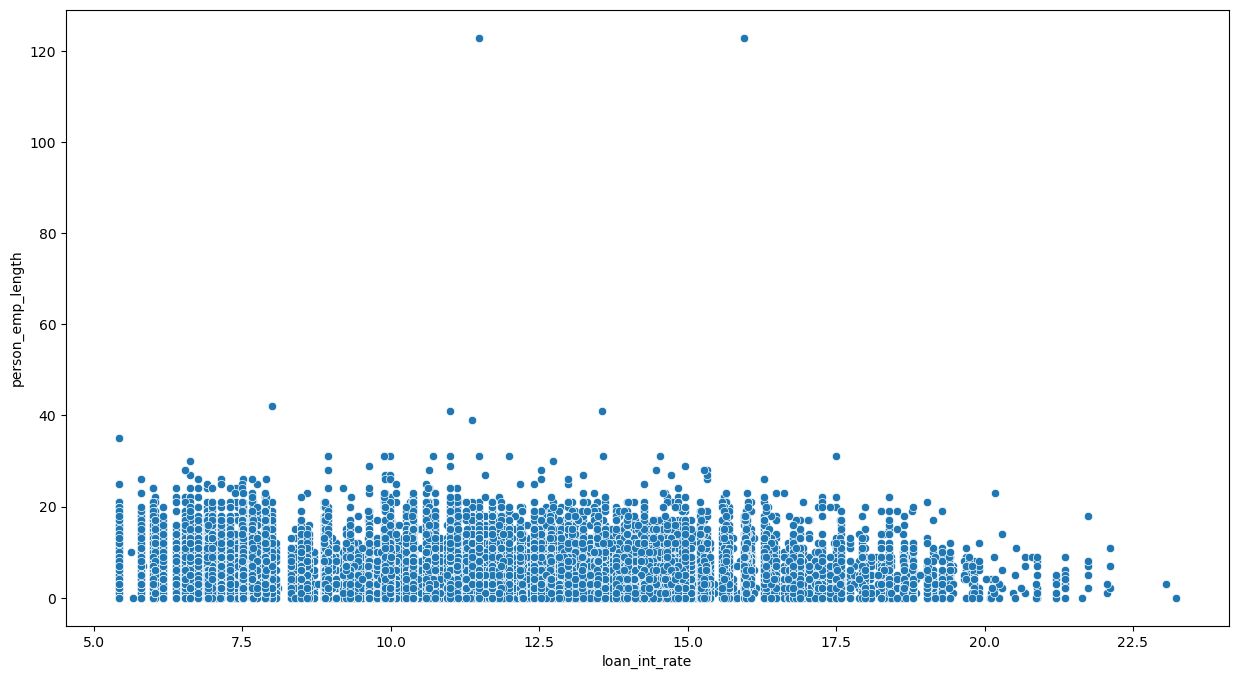

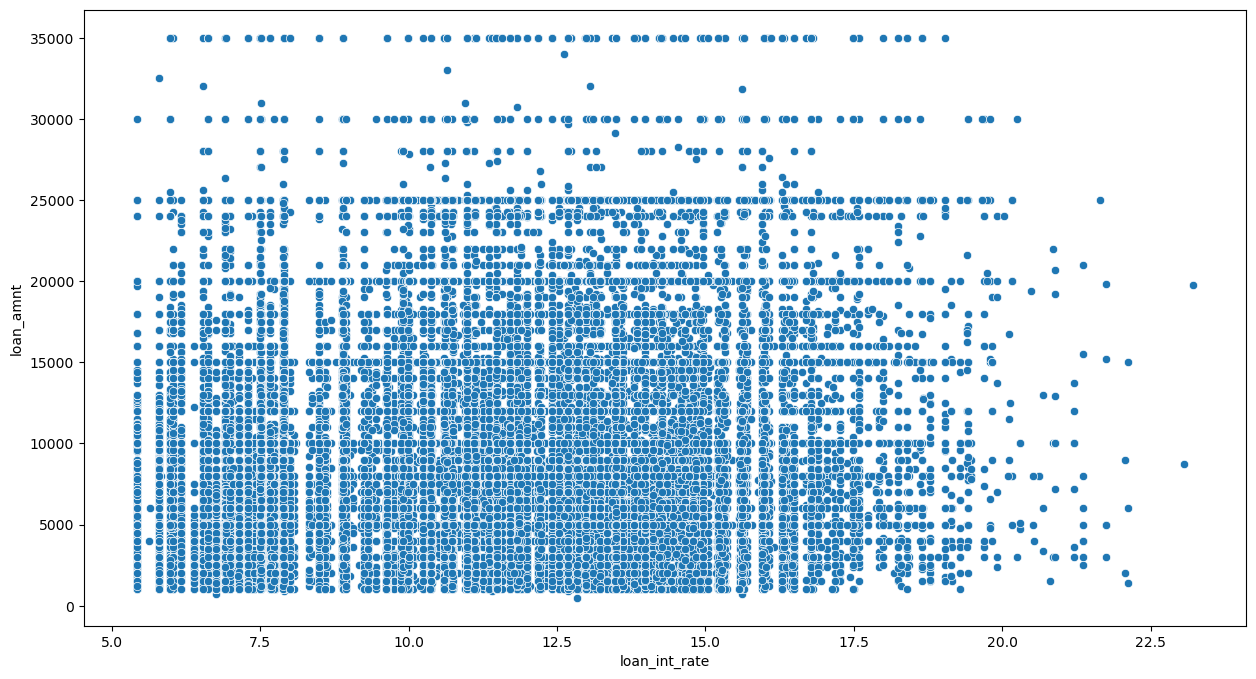

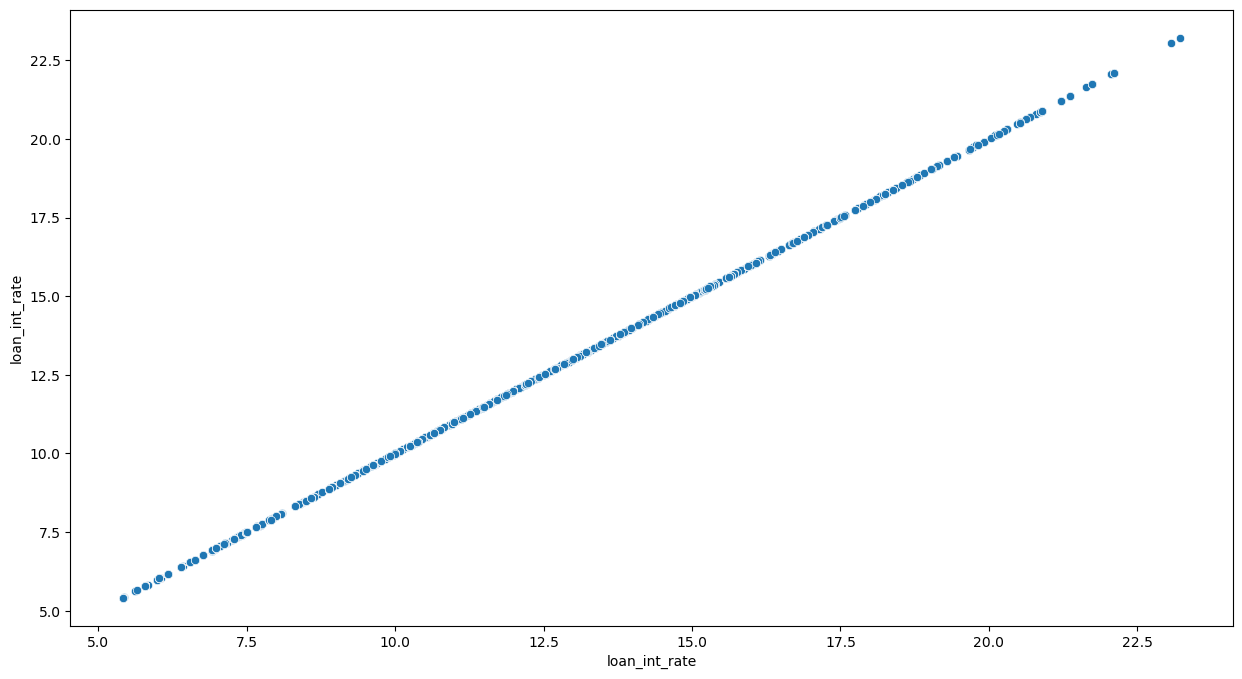

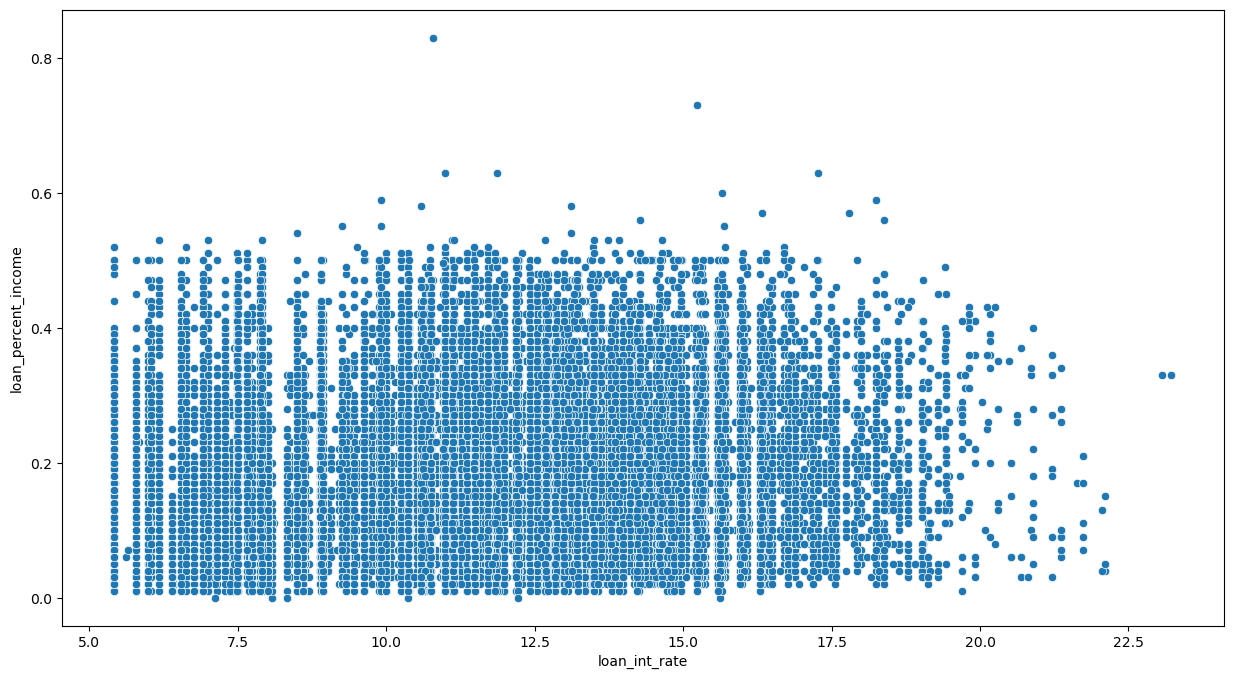

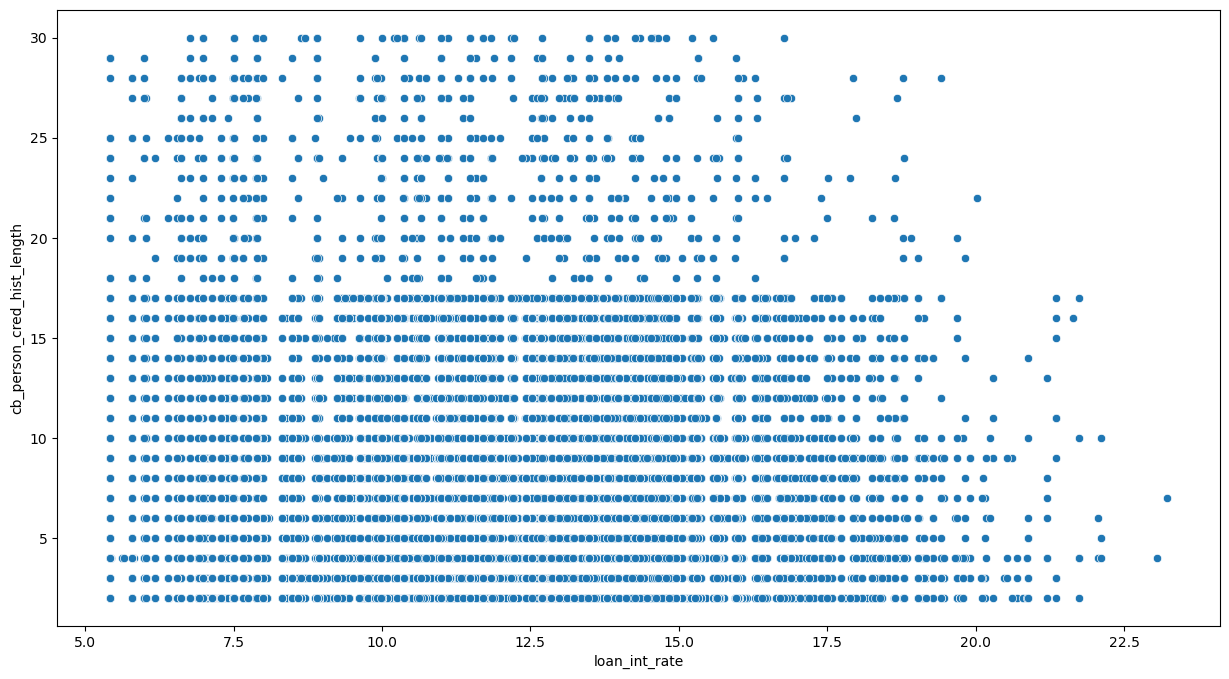

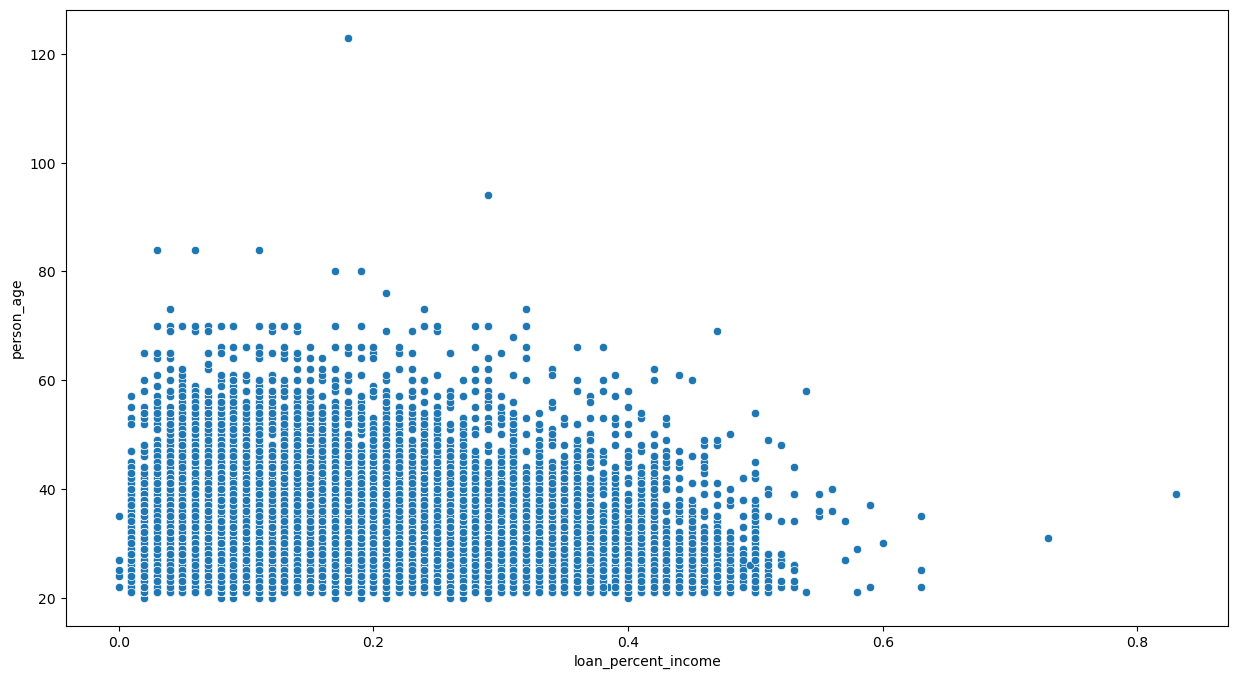

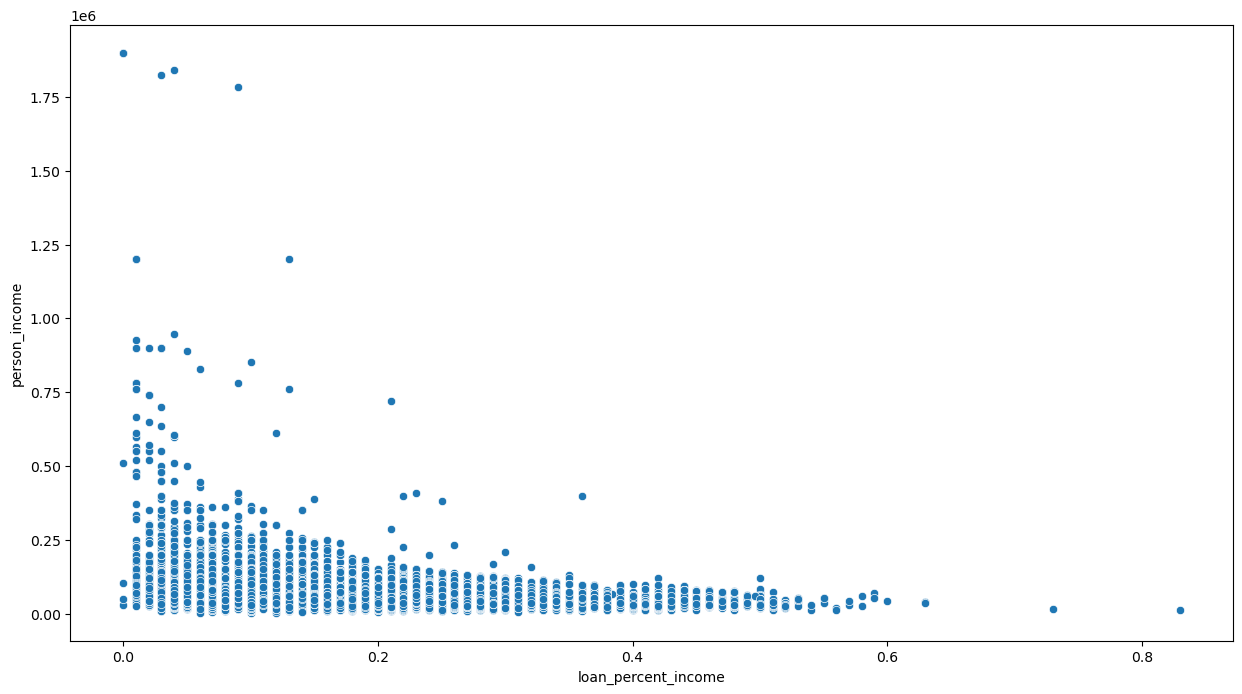

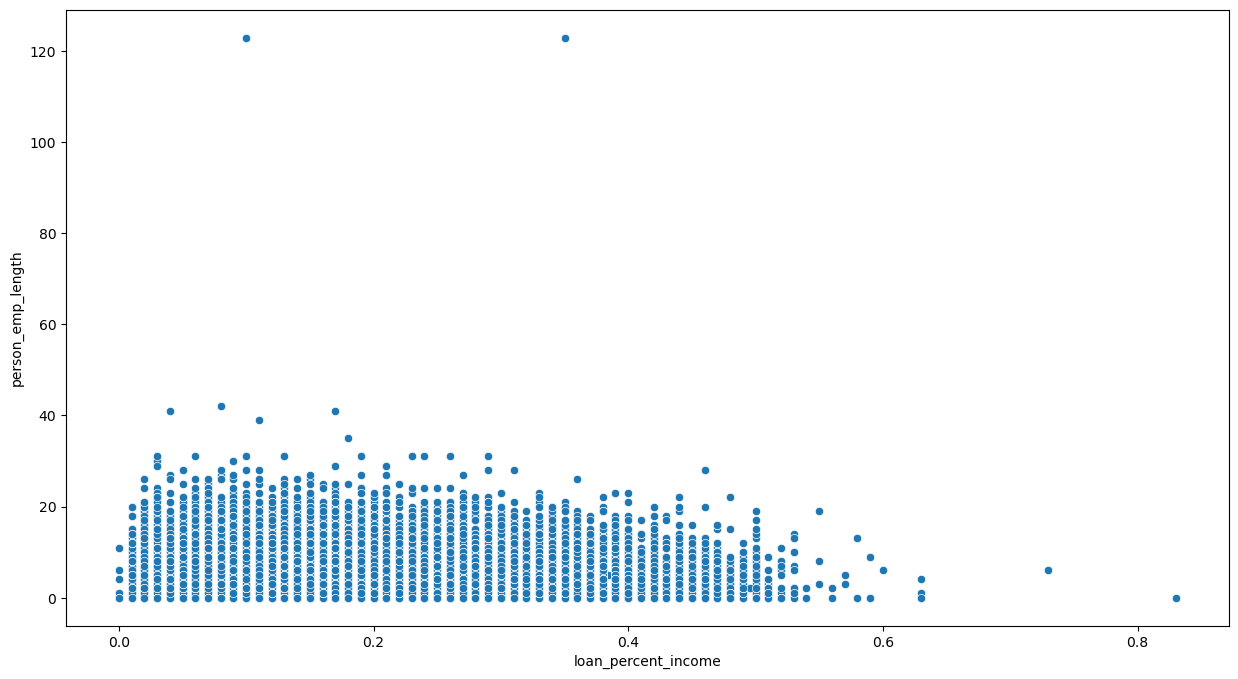

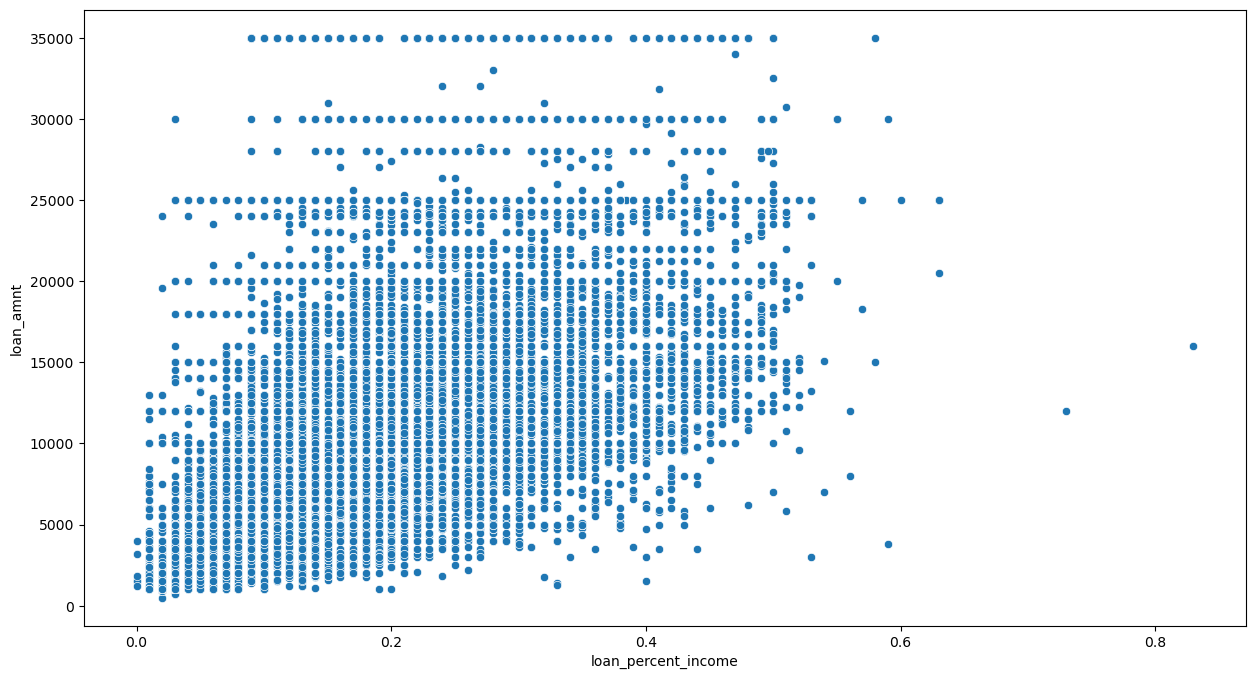

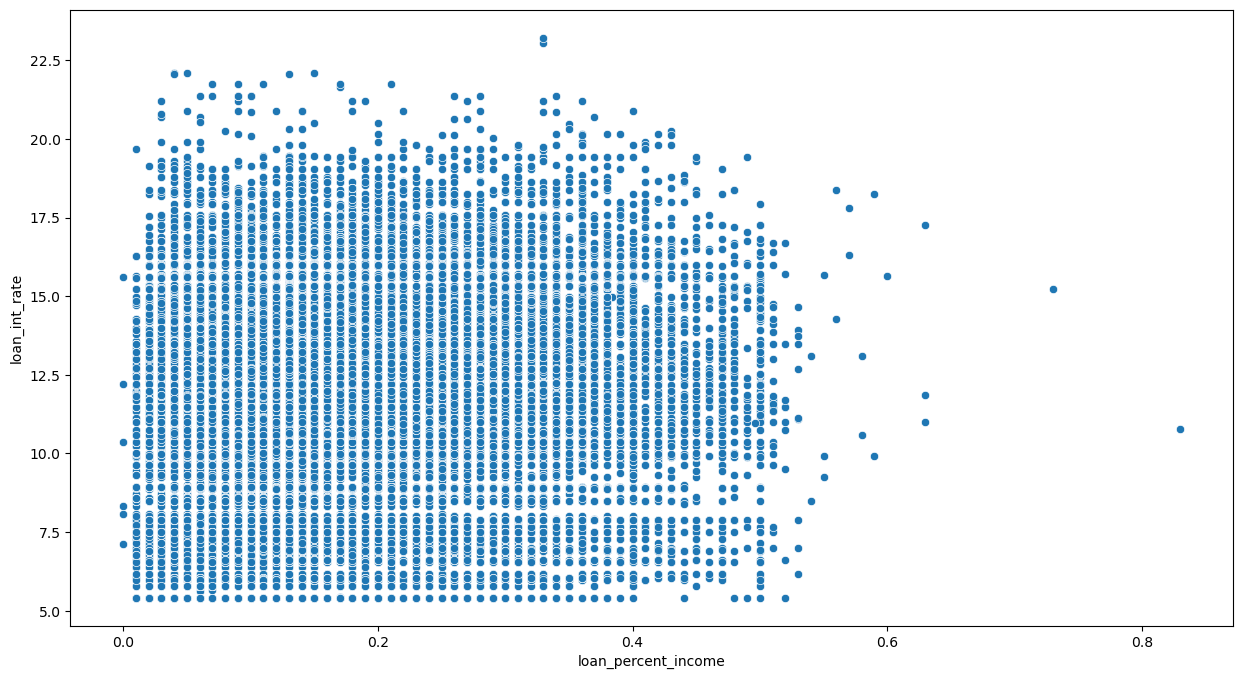

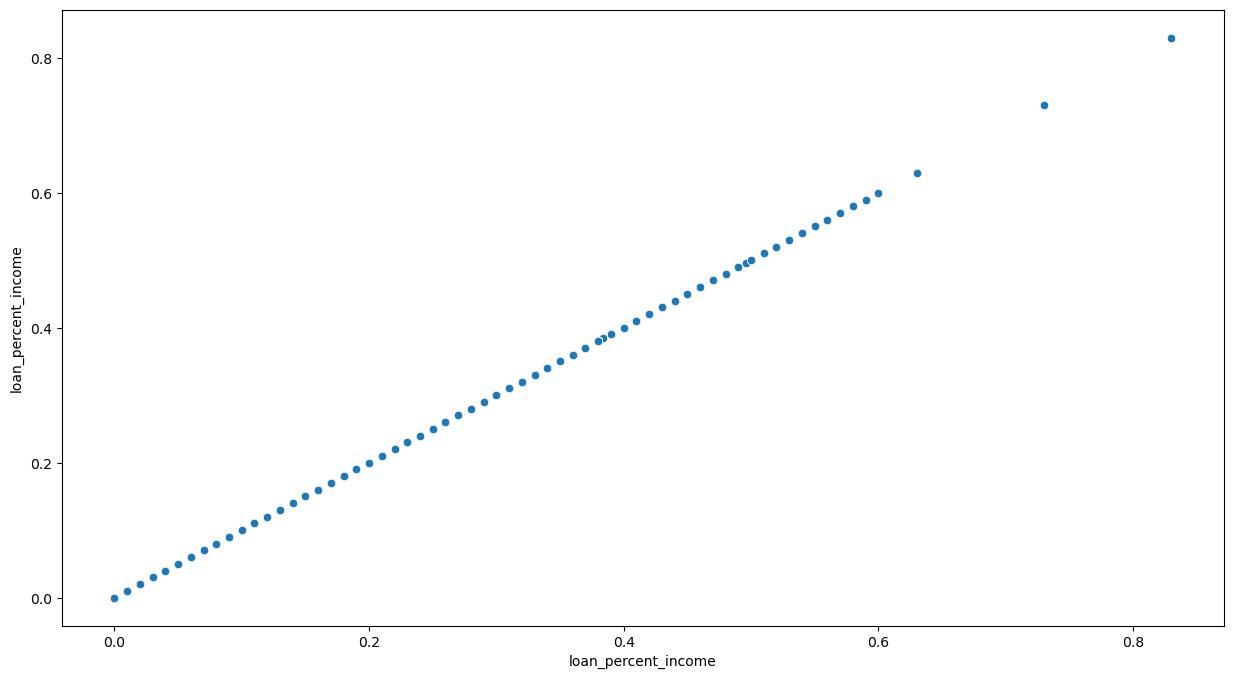

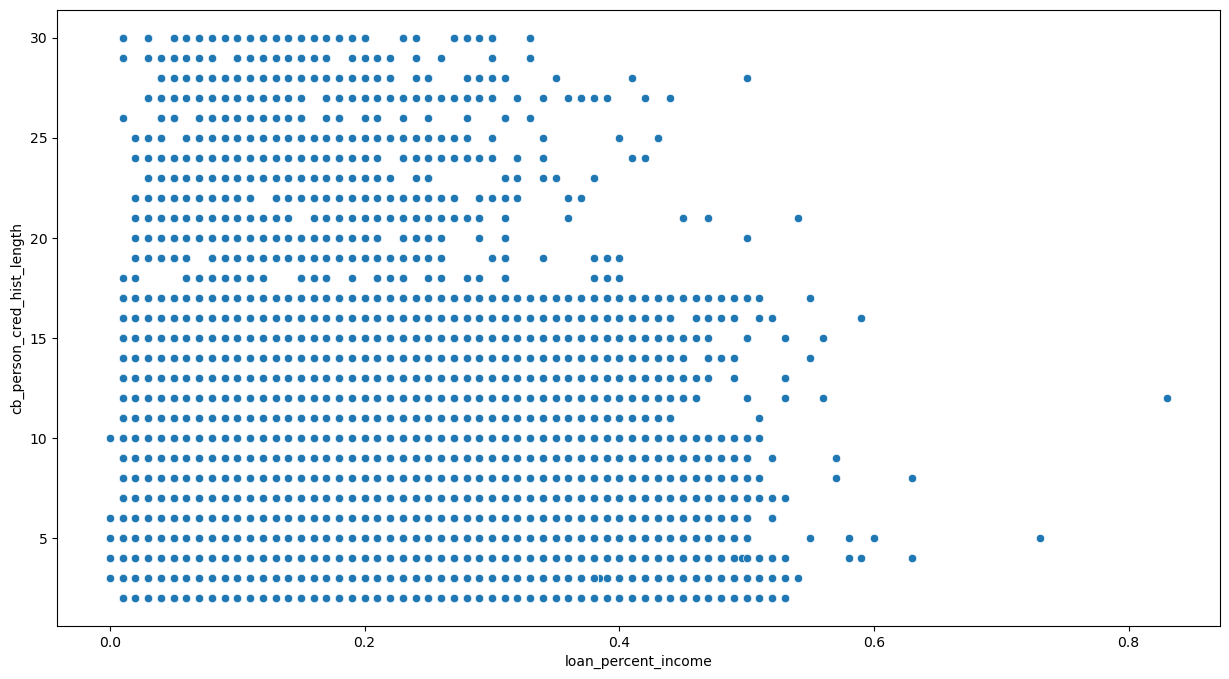

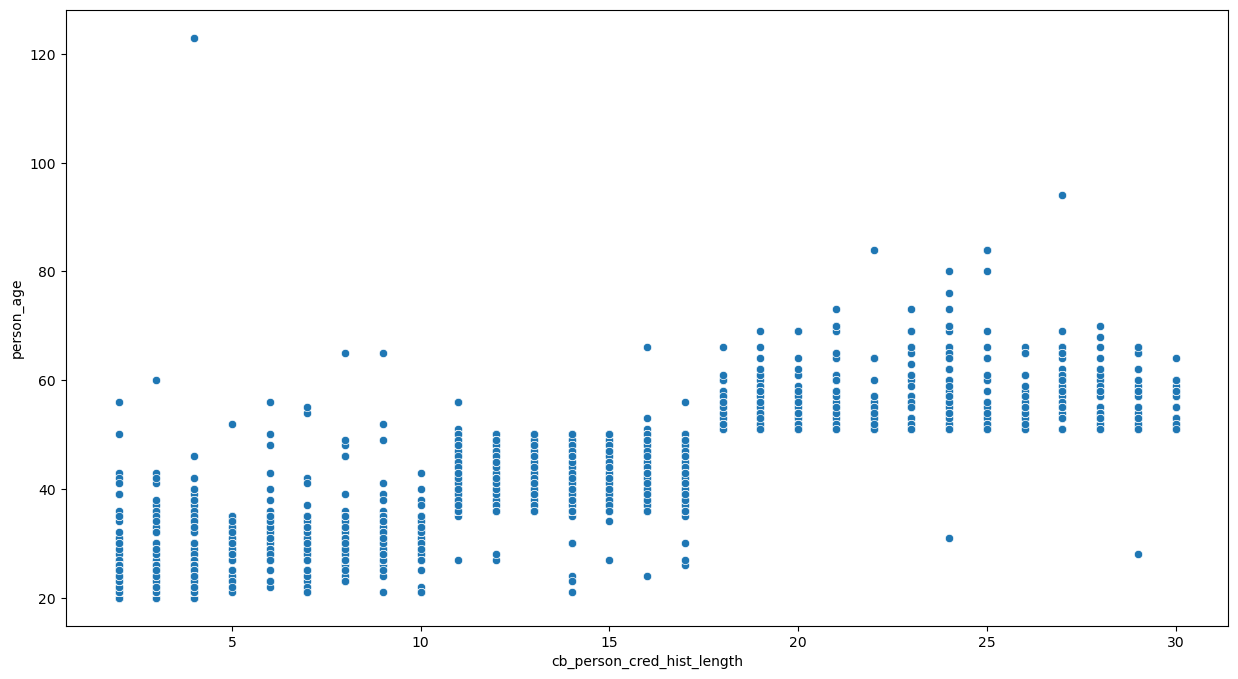

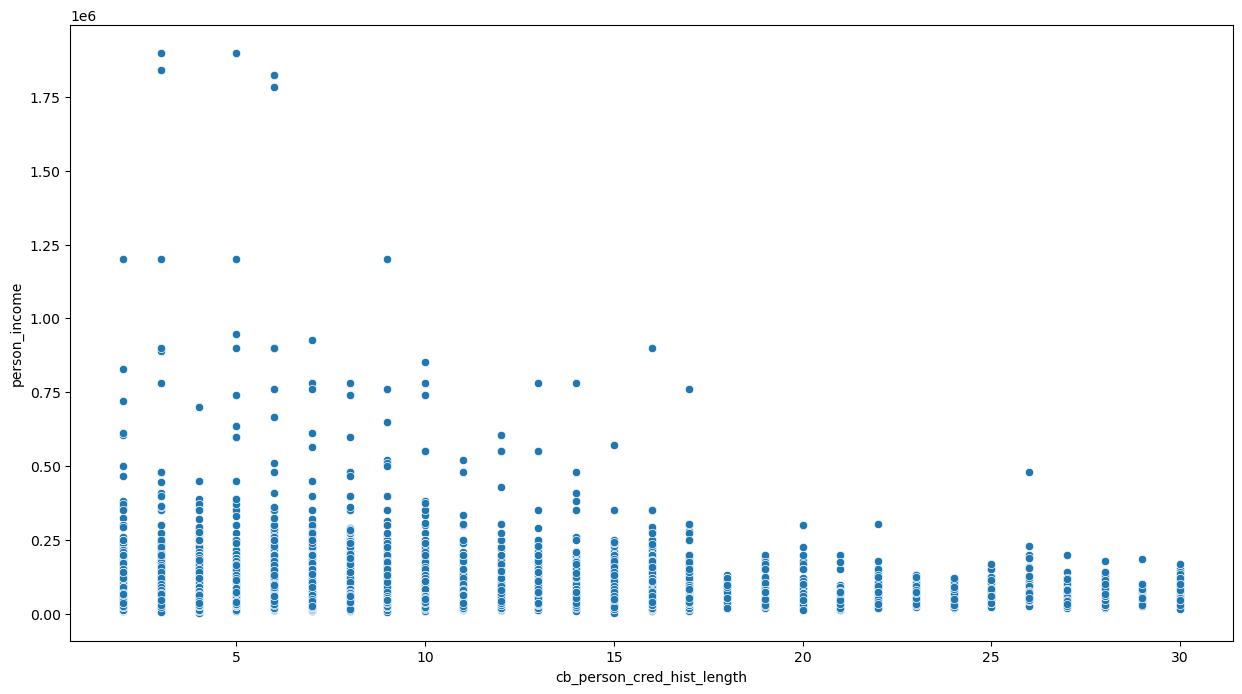

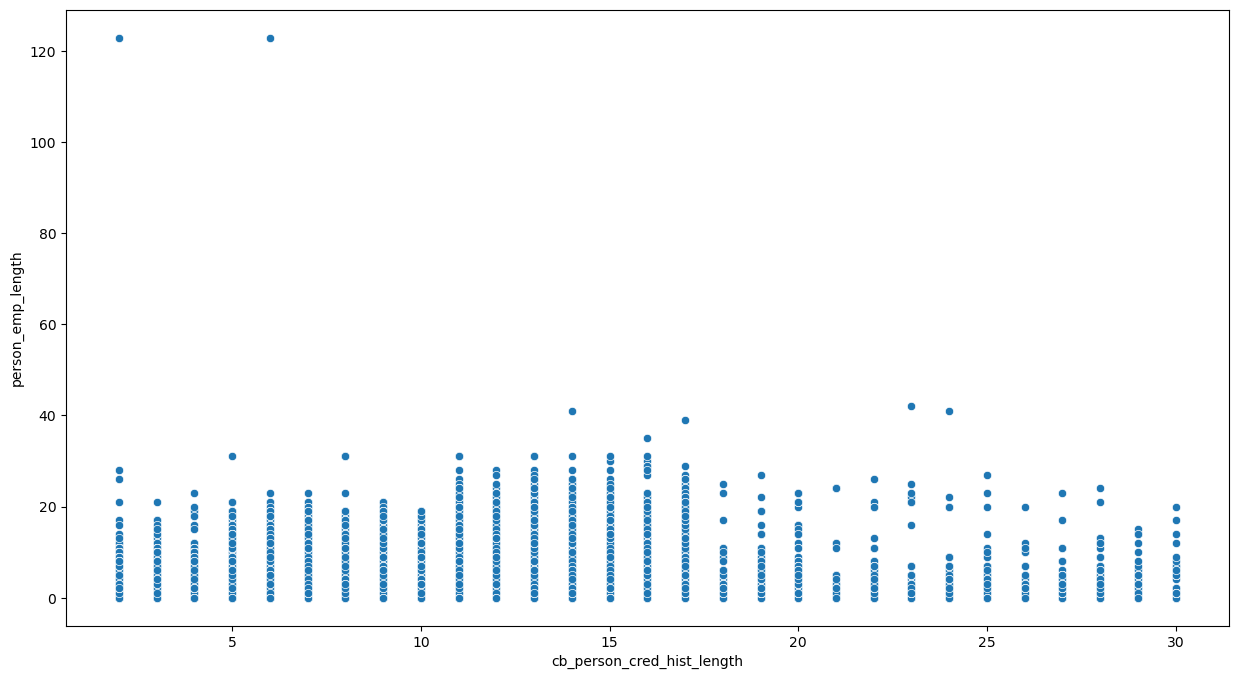

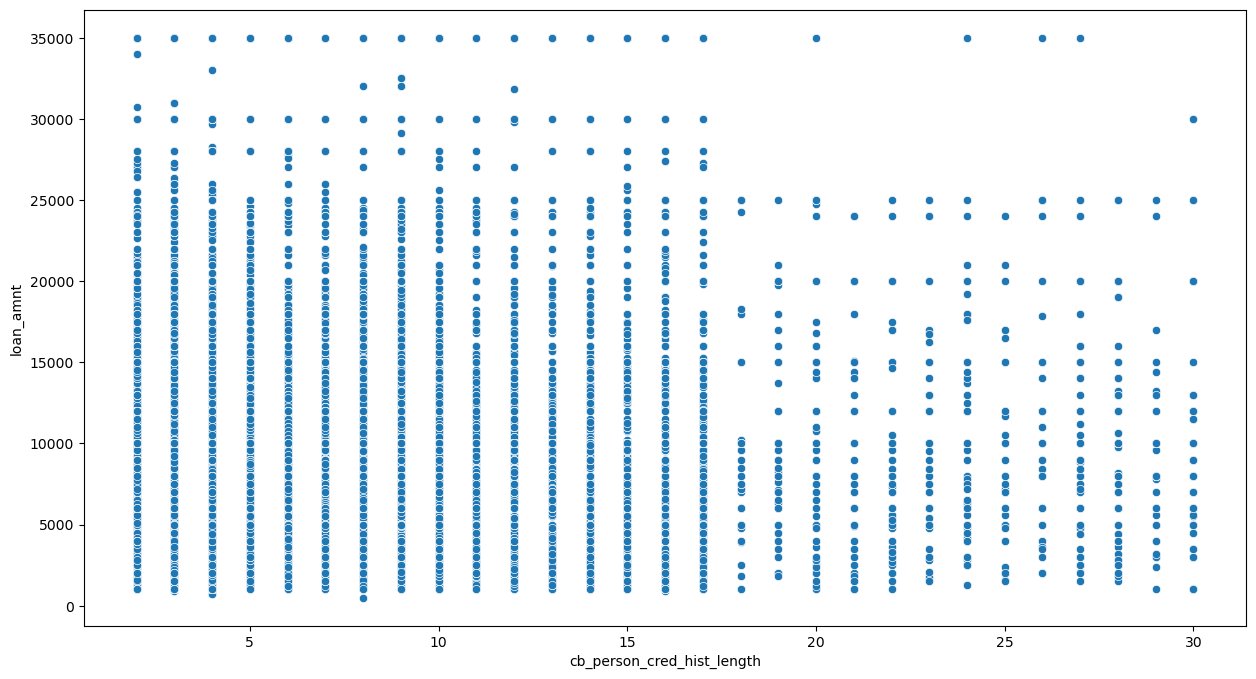

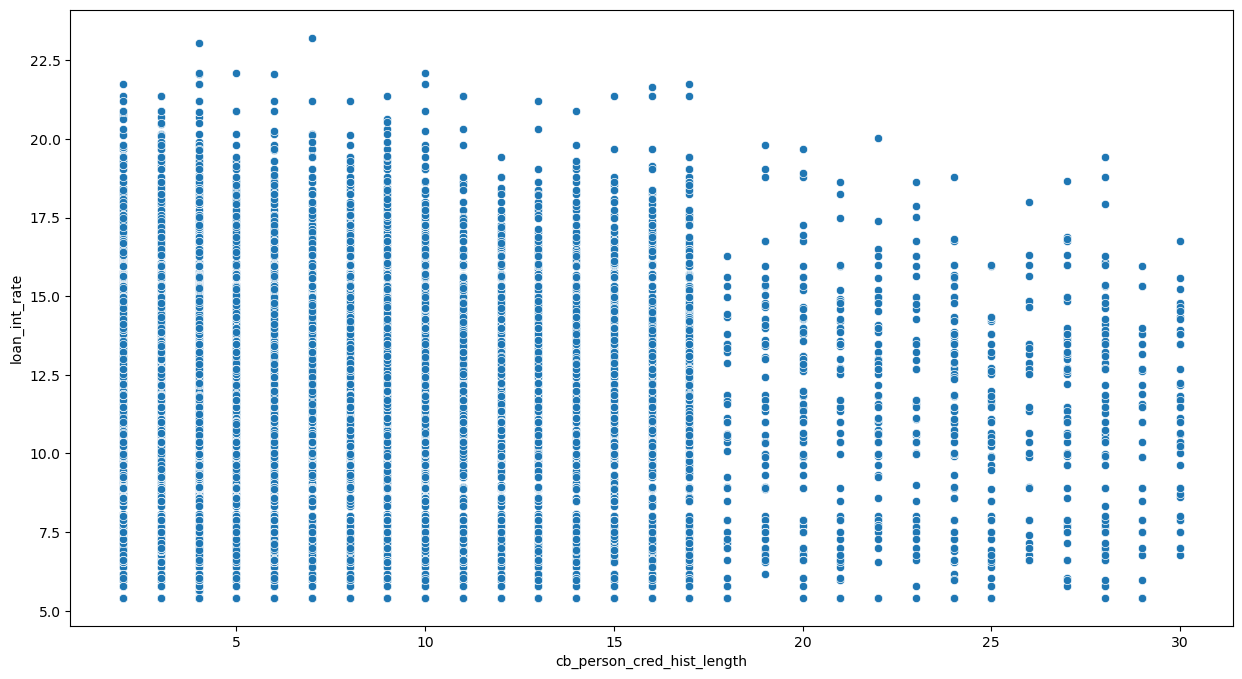

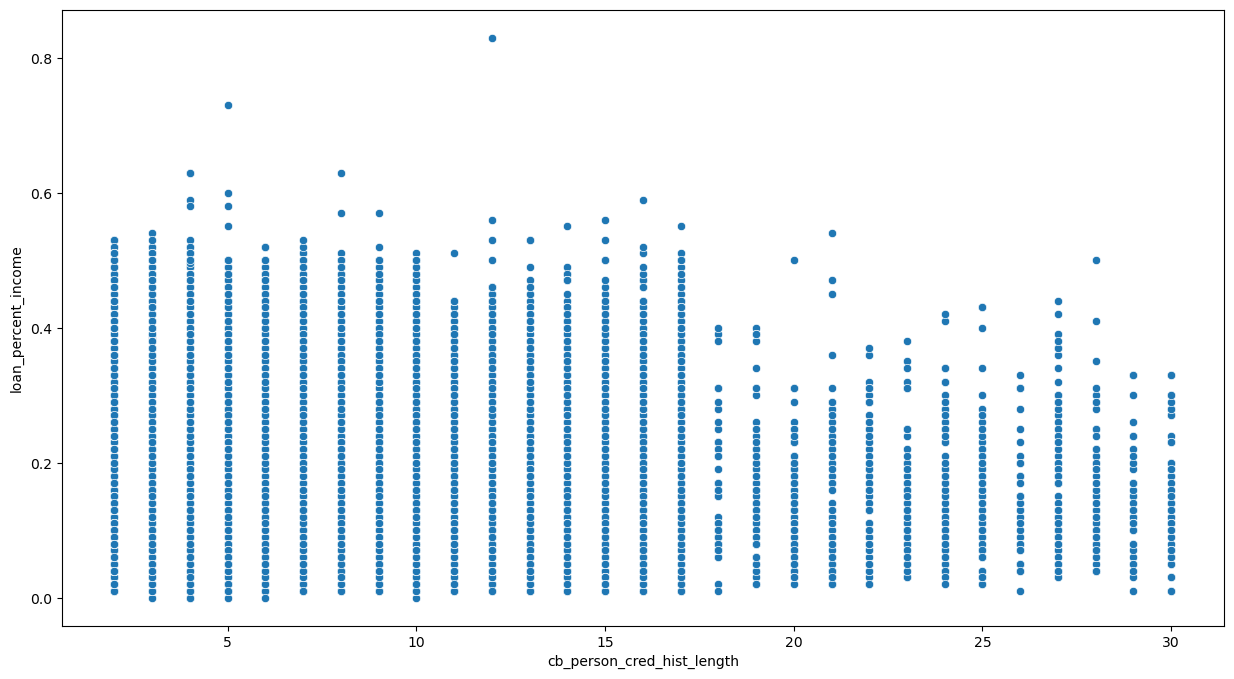

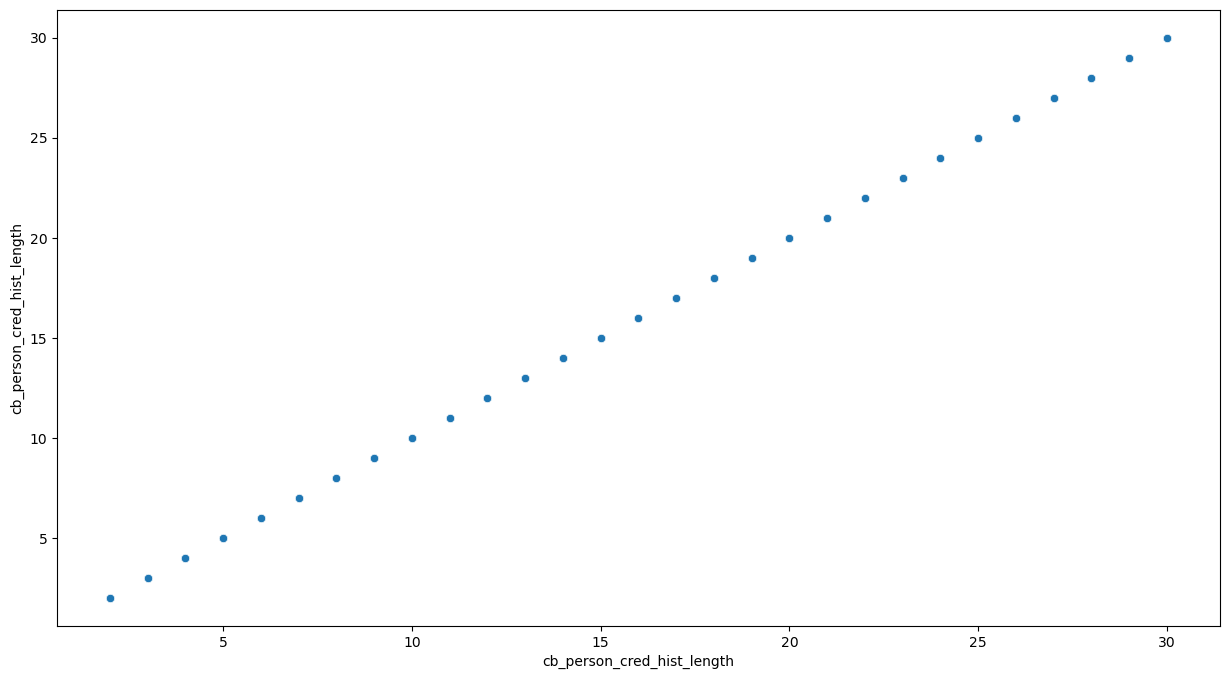

In [52]:
for i in num:
    for j in num:
        sns.scatterplot(x= df[i],y=df[j])
        plt.show()

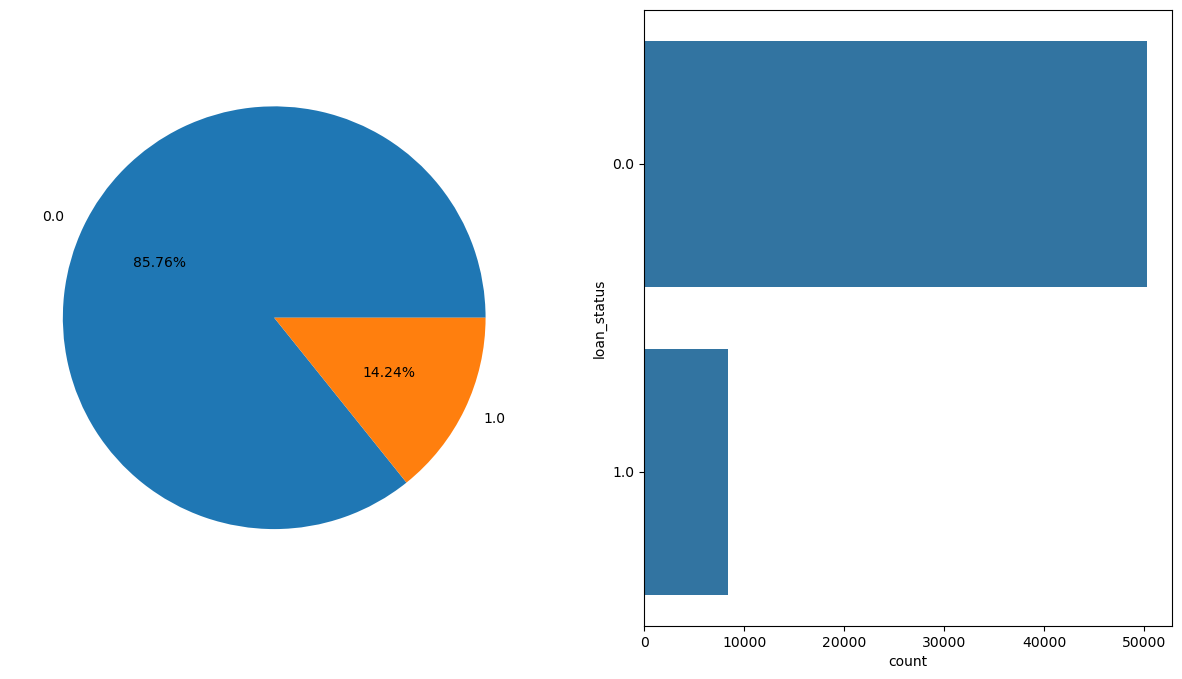

In [53]:
index = df.loan_status.value_counts().index
values = df.loan_status.value_counts().values
plt.subplot(1,2,1)
plt.pie(values,labels=index,autopct='%.2f%%')
plt.subplot(1,2,2)
sns.countplot(y=df.loan_status)
plt.show()

**Inference**
* In the loan status column, approximately 85% of individuals have not defaulted on their loans.

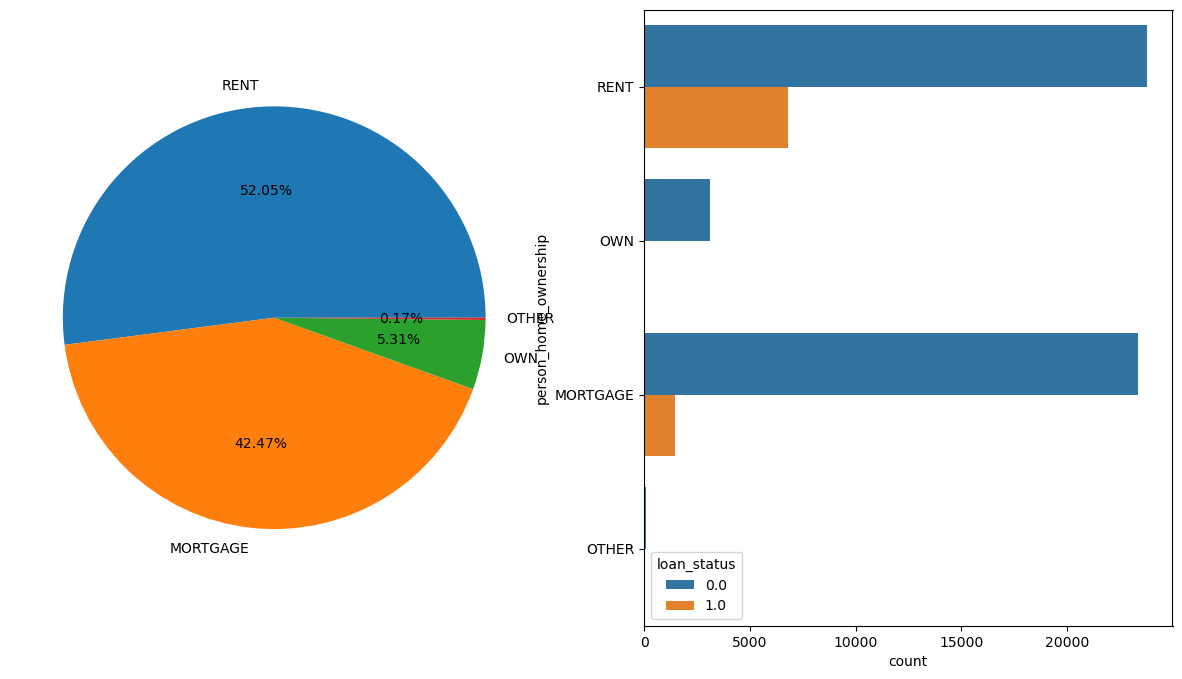

In [54]:
index = df.person_home_ownership.value_counts().index
values = df.person_home_ownership.value_counts().values
plt.subplot(1,2,1)
plt.pie(values,labels=index,autopct='%.2f%%')
plt.subplot(1,2,2)
sns.countplot(y=df.person_home_ownership,hue=df.loan_status)
plt.show()

**Inference**
* People who rent are less likely to default on their loans and they are most getting loans.
* Some individuals with a mortgage have also not defaulted on their loans and they are the second most getting loans.

#### Let's check the correaltion between the independent variables

##### Pearson correlation 

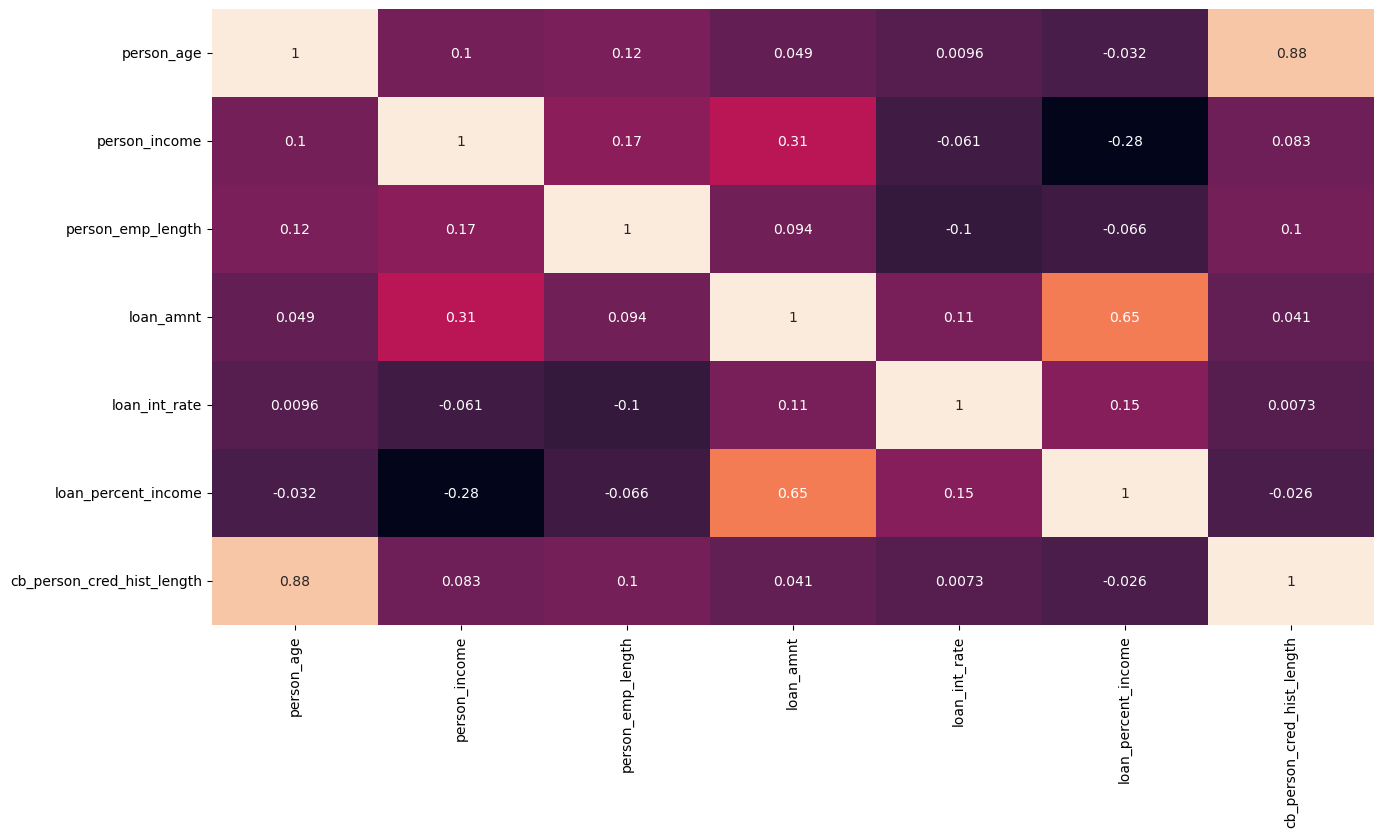

In [55]:
sns.heatmap(df[num].corr(method='pearson'),annot=True,cbar=False)
plt.show()

##### Spearman Correlation matric

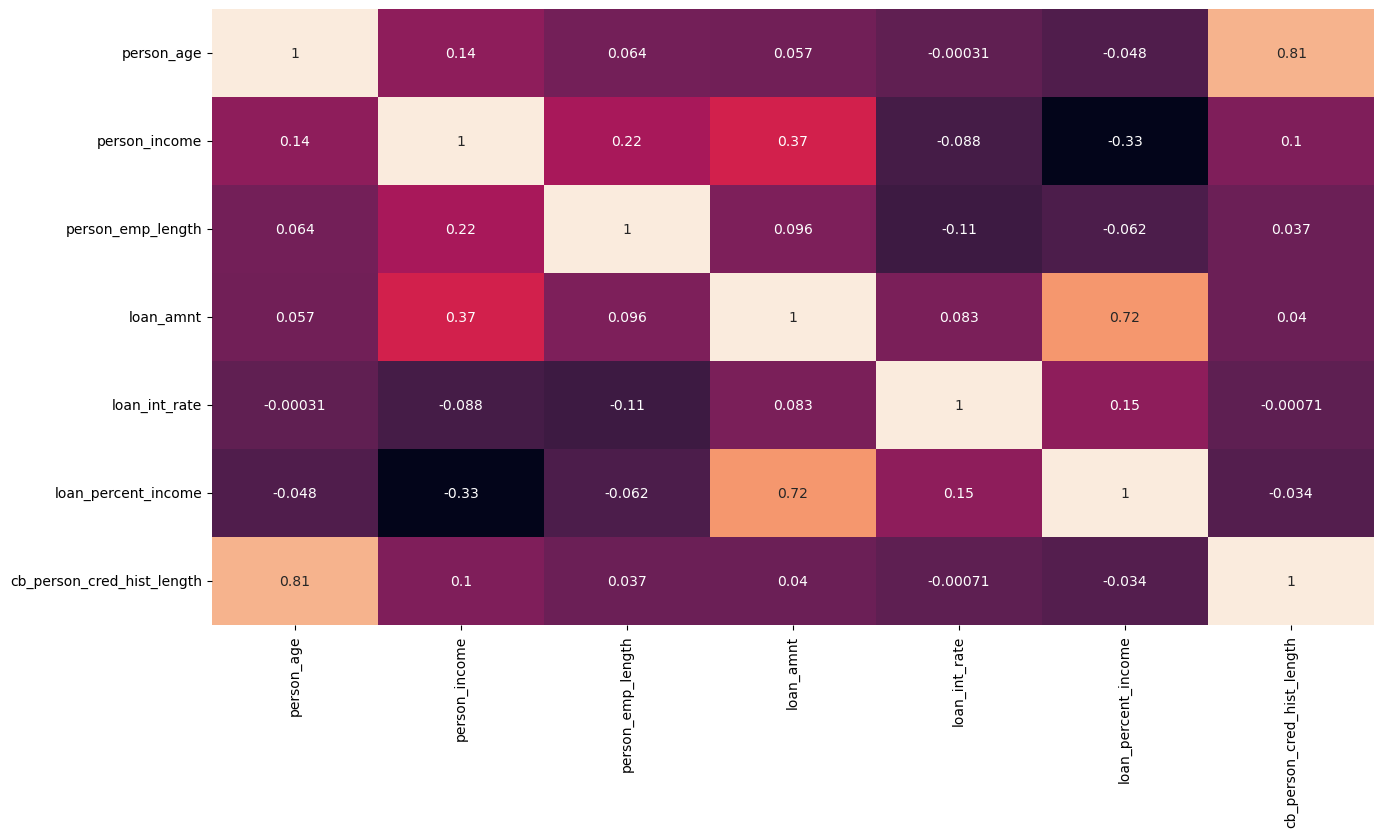

In [56]:
sns.heatmap(df[num].corr(method='spearman'),annot=True,cbar=False)
plt.show()

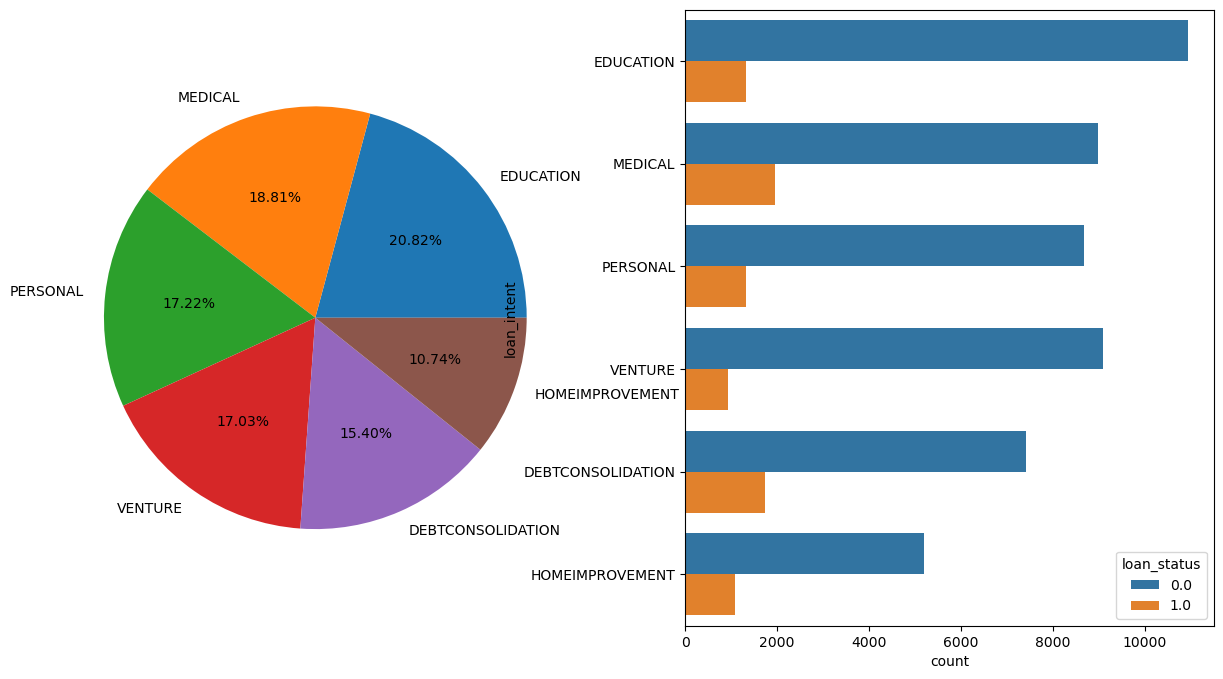

In [57]:
index = df.loan_intent.value_counts().index
values = df.loan_intent.value_counts().values
plt.subplot(1,2,1)
plt.pie(values,labels=index,autopct='%.2f%%')
plt.subplot(1,2,2)
sns.countplot(y=df.loan_intent,hue=df.loan_status)
plt.show()

**Inference**
* Most people who take out loans for education do not default, though some do.
* Most people who take out loans for medical expenses, personal use, or ventures also do not default, but a few do.

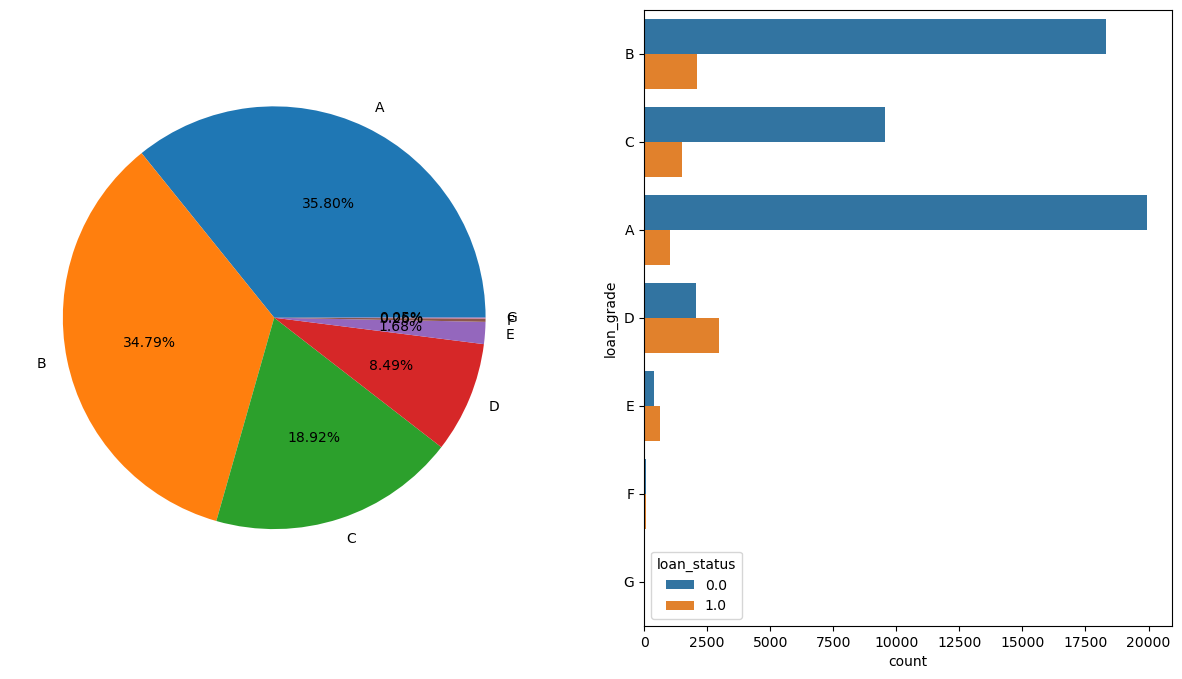

In [58]:
index = df.loan_grade.value_counts().index
values = df.loan_grade.value_counts().values
plt.subplot(1,2,1)
plt.pie(values,labels=index,autopct='%.2f%%')
plt.subplot(1,2,2)
sns.countplot(y=df.loan_grade,hue=df.loan_status)
plt.show()

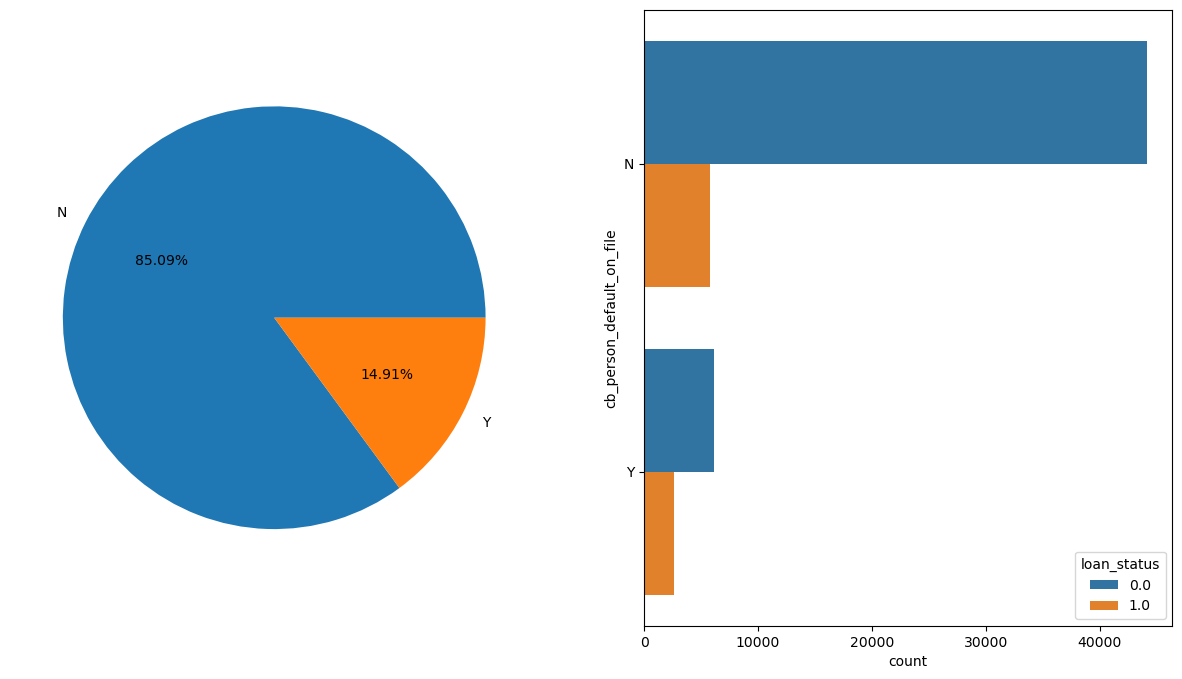

In [59]:
index = df.cb_person_default_on_file.value_counts().index
values = df.cb_person_default_on_file.value_counts().values
plt.subplot(1,2,1)
plt.pie(values,labels=index,autopct='%.2f%%')
plt.subplot(1,2,2)
sns.countplot(y=df.cb_person_default_on_file,hue=df.loan_status)
plt.show()

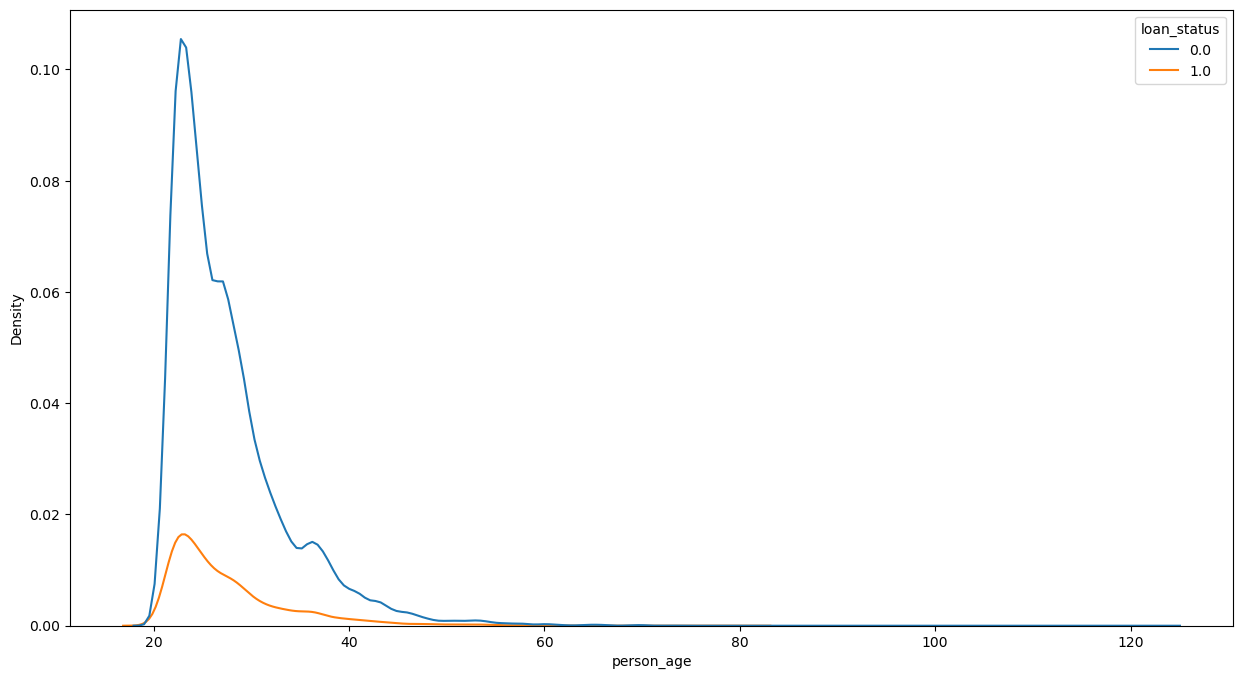

In [60]:
sns.kdeplot(x=df.person_age, hue=df.loan_status)
plt.show()

## Train and Test Split

In [61]:
train_data = df.iloc[:train.shape[0],:]
train_data.shape

(58645, 12)

In [62]:
test_data = df.iloc[train.shape[0]:,:]
test_data.shape

(39098, 12)

In [63]:
test_data.drop('loan_status',axis=1,inplace=True)

## Inferential Statistics

#### Check whether the person's income across all the target variables is significantly the same. Let's fix alpha is 0.05.

In [64]:
not_defaulted = train_data[train_data.loan_status == 0.0]
defaulted = train_data[train_data.loan_status == 1.0]

### Checking for normality:

- **H0: Data is normally distributed**
- **H1: Data is not normally distributed**

- As the data is huge we are using the Jarque Bera test instead of the Shapiro test to check the normality of the data.

In [65]:
print("The Person income data for not defaulted:",st.jarque_bera(not_defaulted.person_income))
print("The Person income data for defaulted:",st.jarque_bera(defaulted.person_income))

The Person income data for not defaulted: SignificanceResult(statistic=247563419.7545252, pvalue=0.0)
The Person income data for defaulted: SignificanceResult(statistic=81990.26827907587, pvalue=0.0)


- **As we can see that the P-value is less than 0.05, Thus we are rejecting the null hypothesis and saying the data is not normally distributed.**

### Levene test:

In [66]:
print("Checking for equality of variance :",st.levene(not_defaulted.person_income, defaulted.person_income))

Checking for equality of variance : LeveneResult(statistic=367.1902137714158, pvalue=1.3611959281784152e-81)


- **As we can see that P-value is 0, Thus the population variance is not equal.**

- **As the data is not normally distributed we are using non-parametric tests.**

- **H0: All the classes median is not significantly different.**
- **H1: At least one of median is significantly different.**

In [67]:
st.kruskal(not_defaulted.person_income, defaulted.person_income)

KruskalResult(statistic=3253.3818941711042, pvalue=0.0)

- **As we can see that the P-value is 0 (less than 0.05) thus we are rejecting the null hypothesis and saying that the parameter(median) of the Person's Income is significantly different at least for one class.**

- **Thus we can say that this feature would be impact the target variables.**

#### Check if there is independence of the loan_intent and loan_status. The significant level is 0.05.

- **H0: The loan_intent and loan_status are independent of each other.**
- **H1: The loan_intent and loan_status are dependent on each other.**

In [68]:
int_status = pd.crosstab(train_data.loan_intent,df.loan_status)
print("The P-value of the chi2 contingency is:",st.chi2_contingency(int_status)[1])

The P-value of the chi2 contingency is: 1.9499337690925461e-140


- **As we can see that the P-value is less than 0.05 which means that both variables are dependent on each other. So We could use the loan_intent feature for the Machine learning model. Since the P-value is less than 0.05 we reject the null hypothesis.**

#### Check if there is a relationship between the person_home_ownership and loan_status.

- **H0: The person_home_ownership and loan_status are independent of each other.**
- **H1: The person_home_ownership and loan_status are dependent on each other.**

In [69]:
home_status = pd.crosstab(train_data.person_home_ownership,df.loan_status)
print("The P-value of the chi2 contingency is:",st.chi2_contingency(home_status)[1])

The P-value of the chi2 contingency is: 0.0


#### Check Statistically that the person_emp_length	 median values are significantly not different across the target variable classes.

#### Let's check for the normality of the data.

In [70]:
print("The Annual income data for Good credit score:",st.jarque_bera(not_defaulted.person_emp_length))
print("The Annual income data for Standard credit score:",st.jarque_bera(defaulted.person_emp_length))

The Annual income data for Good credit score: SignificanceResult(statistic=690700.1976677319, pvalue=0.0)
The Annual income data for Standard credit score: SignificanceResult(statistic=4162530.1668315157, pvalue=0.0)


- **We can see that P-value is 0 Thus we reject the null hypothesis, So the data is not normally distributed.**

#### Levene test:

In [71]:
print("Checking for equality of variance :",st.levene(not_defaulted.person_emp_length, defaulted.person_emp_length))

Checking for equality of variance : LeveneResult(statistic=103.01264362710036, pvalue=3.4871315981136615e-24)


- **As we can see that P-value is less than 0.05, Thus the population variance is not equal.**

- **H0: All the classes median is not significantly different.**
- **H1: At least one of median is significantly different.**

In [72]:
st.kruskal(not_defaulted.person_emp_length, defaulted.person_emp_length)

KruskalResult(statistic=822.4905809496098, pvalue=6.954850593245002e-181)

- **As we can see that the P-value is less than 0.05, Thus we reject the null hypothesis and state that the parameter(median) of at least one class is significantly different.** 

### Split the independent and dependent data.

In [73]:
train_data['loan_status'] = train_data['loan_status'].astype('int64')

In [74]:
x = train_data.drop('loan_status', axis=1)
y = train_data['loan_status']

In [75]:
y.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [76]:
validate_data = test_data.copy()

## Feature Engineering

### Encoding

In [77]:
cat1 = ['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [78]:
for i in cat1:
    print(i, x[i].unique())
    print("------------------------")
    print()

person_home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
------------------------

loan_intent ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
------------------------

loan_grade ['B' 'C' 'A' 'D' 'E' 'F' 'G']
------------------------

cb_person_default_on_file ['N' 'Y']
------------------------



In [79]:
for i in cat1:
    print(i, validate_data[i].unique())
    print("------------------------")
    print()

person_home_ownership ['RENT' 'MORTGAGE' 'OWN' 'OTHER']
------------------------

loan_intent ['HOMEIMPROVEMENT' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION' 'EDUCATION'
 'MEDICAL']
------------------------

loan_grade ['F' 'C' 'E' 'A' 'D' 'B' 'G']
------------------------

cb_person_default_on_file ['N' 'Y']
------------------------



##### Categorical features for train and validate data

In [80]:
cat2 = x.select_dtypes(exclude=np.number)
cat2_validate = validate_data.select_dtypes(exclude=np.number)

##### cb_person_default_on_file

In [81]:
cat2['cb_person_default_on_file'] = pd.get_dummies(cat2['cb_person_default_on_file'], drop_first=True).astype('int64')

In [82]:
cat2_validate['cb_person_default_on_file'] = pd.get_dummies(cat2_validate['cb_person_default_on_file'], drop_first=True).astype('int64')

**Inference**
* One-hot encoding is suitable for the cb_person_default_on_file categories ['N', 'Y'] because these binary values represent distinct outcomes (not defaulted vs. defaulted) with no inherent order, allowing the model to treat each category independently and effectively capture the impact of default status on loan predictions.

##### loan_grade

In [83]:
ol = OrdinalEncoder()

In [84]:
cat2['loan_grade'] = ol.fit_transform(cat2[['loan_grade']]).astype('int64')

In [85]:
cat2_validate['loan_grade'] = ol.fit_transform(cat2_validate[['loan_grade']]).astype('int64')

**Inference**
* Ordinal encoding is appropriate for the loan_grade categories ['F', 'C', 'E', 'A', 'D', 'B', 'G'] because these grades have a natural ranking, where 'A' represents the highest creditworthiness and 'G' the lowest, allowing the model to leverage this order in predicting loan outcomes without losing important information about relative quality.

##### loan_intent

In [86]:
cat2_intent = pd.get_dummies(cat2['loan_intent'], prefix='intent').astype('int64')

In [87]:
cat2 = pd.concat([cat2, cat2_intent], axis=1)

In [88]:
cat2.drop('loan_intent', axis=1, inplace=True)

In [89]:
cat2_validate_intent = pd.get_dummies(cat2_validate['loan_intent'], prefix='intent').astype('int64')

In [90]:
cat2_validate = pd.concat([cat2_validate, cat2_validate_intent], axis=1)

In [91]:
cat2_validate.drop('loan_intent', axis=1, inplace=True)

**Inference**
* One-hot encoding is suitable for the loan_intent categories ['HOMEIMPROVEMENT', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION', 'EDUCATION', 'MEDICAL'] because these categories represent different loan purposes with no inherent ranking or order, allowing the model to treat each intent as a separate feature without implying any preference or hierarchy among them.

##### person_home_ownership

In [92]:
cat2_ownership = pd.get_dummies(cat2['person_home_ownership'], prefix='ownership').astype('int64')

In [93]:
cat2 = pd.concat([cat2, cat2_ownership], axis=1)

In [94]:
cat2.drop('person_home_ownership', axis=1, inplace=True)

In [95]:
cat2_ownership_validate = pd.get_dummies(cat2_validate['person_home_ownership'], prefix='ownership').astype('int64')

In [96]:
cat2_validate = pd.concat([cat2_validate, cat2_ownership_validate], axis=1)

In [97]:
cat2_validate = cat2_validate.drop('person_home_ownership', axis=1)

**Inference**
* One-hot encoding is appropriate for the person_home_ownership categories ['RENT', 'MORTGAGE', 'OWN', 'OTHER'] because these categories represent distinct types of home ownership without any inherent order or ranking, allowing the model to treat each ownership status independently and avoid introducing bias by implying a hierarchy among them.

### Transformation

In [98]:
num1 = x.select_dtypes(include=np.number)
num1_validate = validate_data.select_dtypes(include=np.number)

In [99]:
pt = PowerTransformer(method = 'yeo-johnson')

In [100]:
num1_transformed = pt.fit_transform(num1)

In [101]:
num1 = pd.DataFrame(num1_transformed, columns=num1.columns)

In [102]:
num1_transformed_validate = pt.fit_transform(num1_validate)

In [103]:
num1_validate = pd.DataFrame(num1_transformed_validate, columns=num1_validate.columns)

**Inference**
* The Yeo-Johnson transformation is beneficial because it can handle both positive and negative values while stabilizing variance and making skewed data more normal, improving model performance for algorithms sensitive to normally distributed input features.

In [104]:
cat2.reset_index(drop=True,inplace=True)
num1.reset_index(drop=True,inplace=True)

In [105]:
cat2_validate.reset_index(drop=True,inplace=True)
num1_validate.reset_index(drop=True,inplace=True)

In [106]:
x = pd.concat([num1, cat2], axis=1)

In [107]:
validate_data = pd.concat([num1_validate, cat2_validate], axis=1)

## Train and test split

In [108]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=.20,random_state=1999)

In [109]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(46916, 19)
(11729, 19)
(46916,)
(11729,)


## Checking Multicolinearity

In [110]:
# Lets create a list of VIF

vif_list=[]

for i in range(xtrain.shape[1]):
    vif_list.append(variance_inflation_factor(xtrain.values,i)) 

pd.DataFrame({'Features' :xtrain.columns, 'VIF' :vif_list}).sort_values(by='VIF', ascending=False)

Features        VIF
9     intent_DEBTCONSOLIDATION        inf
10            intent_EDUCATION        inf
17               ownership_OWN        inf
16             ownership_OTHER        inf
15          ownership_MORTGAGE        inf
14              intent_VENTURE        inf
13             intent_PERSONAL        inf
12              intent_MEDICAL        inf
11      intent_HOMEIMPROVEMENT        inf
18              ownership_RENT        inf
3                    loan_amnt  23.417573
5          loan_percent_income  22.640957
1                person_income  12.910174
7                   loan_grade   7.186518
4                loan_int_rate   6.614564
0                   person_age   3.020772
6   cb_person_cred_hist_length   2.919197
8    cb_person_default_on_file   1.444777
2            person_emp_length   1.124639

In [111]:
xtrain.drop('intent_DEBTCONSOLIDATION', axis=1, inplace=True)
xtest.drop('intent_DEBTCONSOLIDATION', axis=1, inplace=True)

In [172]:
validate_data.drop('intent_DEBTCONSOLIDATION', axis=1, inplace=True)

In [112]:
# Lets create a list of VIF

vif_list=[]

for i in range(xtrain.shape[1]):
    vif_list.append(variance_inflation_factor(xtrain.values,i)) 

pd.DataFrame({'Features' :xtrain.columns, 'VIF' :vif_list}).sort_values(by='VIF', ascending=False)

Features        VIF
3                    loan_amnt  23.417573
5          loan_percent_income  22.640957
1                person_income  12.910174
17              ownership_RENT   7.477947
7                   loan_grade   7.186518
4                loan_int_rate   6.614564
14          ownership_MORTGAGE   6.471516
0                   person_age   3.020772
6   cb_person_cred_hist_length   2.919197
9             intent_EDUCATION   1.890371
11              intent_MEDICAL   1.806294
16               ownership_OWN   1.778588
13              intent_VENTURE   1.768244
12             intent_PERSONAL   1.752206
10      intent_HOMEIMPROVEMENT   1.548284
8    cb_person_default_on_file   1.444777
2            person_emp_length   1.124639
15             ownership_OTHER   1.017851

**Inference**
* loan_amount, loan_percent_income, and person_income are highly collinear, but they are also intuitively important variables in predicting loan defaults.

## Model Building

### Logistic Regression - Base Model

In [113]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(xtrain, ytrain)
ypred_lr = lr.predict(xtest)

In [114]:
print(accuracy_score(ytest, ypred_lr))
print(classification_report(ytest, ypred_lr))

0.8955580185864097
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10085
           1       0.72      0.42      0.53      1644

    accuracy                           0.90     11729
   macro avg       0.82      0.70      0.73     11729
weighted avg       0.88      0.90      0.88     11729



In [115]:
ypred_prob_lr = lr.predict_proba(xtest)[:,1]

In [116]:
fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_lr)

AUC Score:  0.8843888384256932


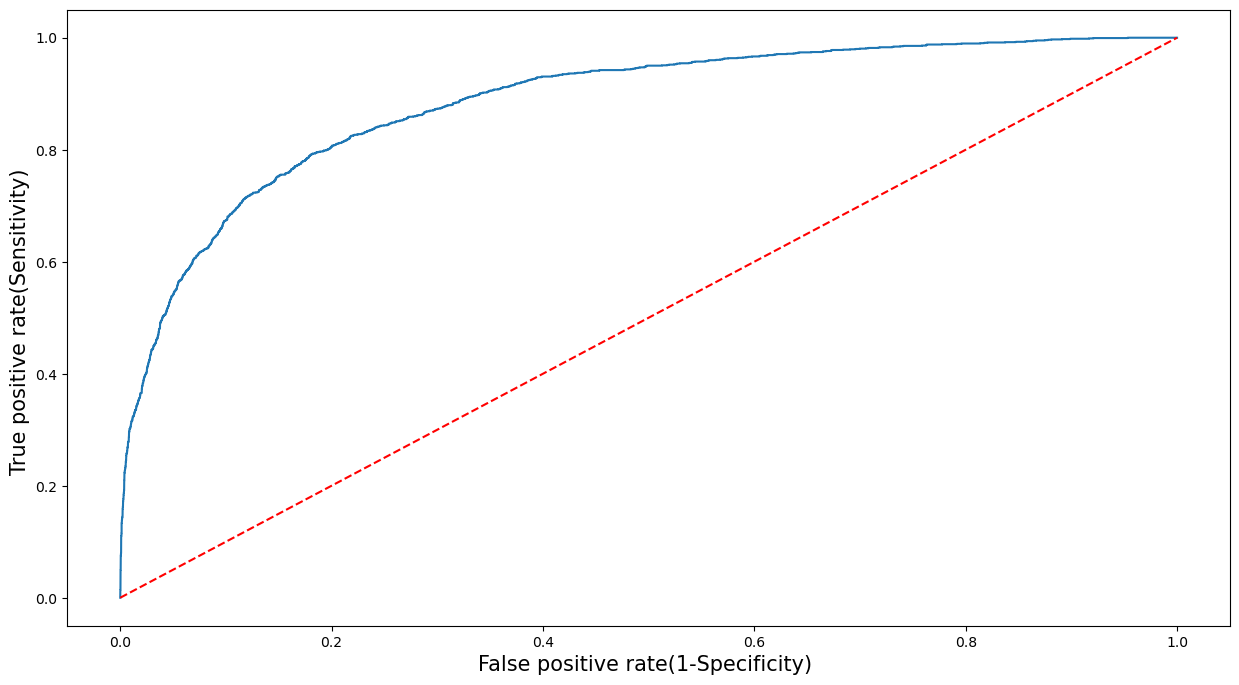

In [117]:
plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_lr))

### K-Nearest Neighbor

In [118]:
# Scaling
sc=StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc = sc.transform(xtest)

In [119]:
from sklearn.neighbors import KNeighborsClassifier

In [120]:
knn = KNeighborsClassifier()
knn.fit(xtrain_sc, ytrain)
ypred_knn = knn.predict(xtest_sc)

In [121]:
print(accuracy_score(ytest, ypred_knn))
print(classification_report(ytest, ypred_knn))

0.9262511723079546
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10085
           1       0.84      0.59      0.69      1644

    accuracy                           0.93     11729
   macro avg       0.89      0.78      0.82     11729
weighted avg       0.92      0.93      0.92     11729



AUC Score:  0.8534401926688838


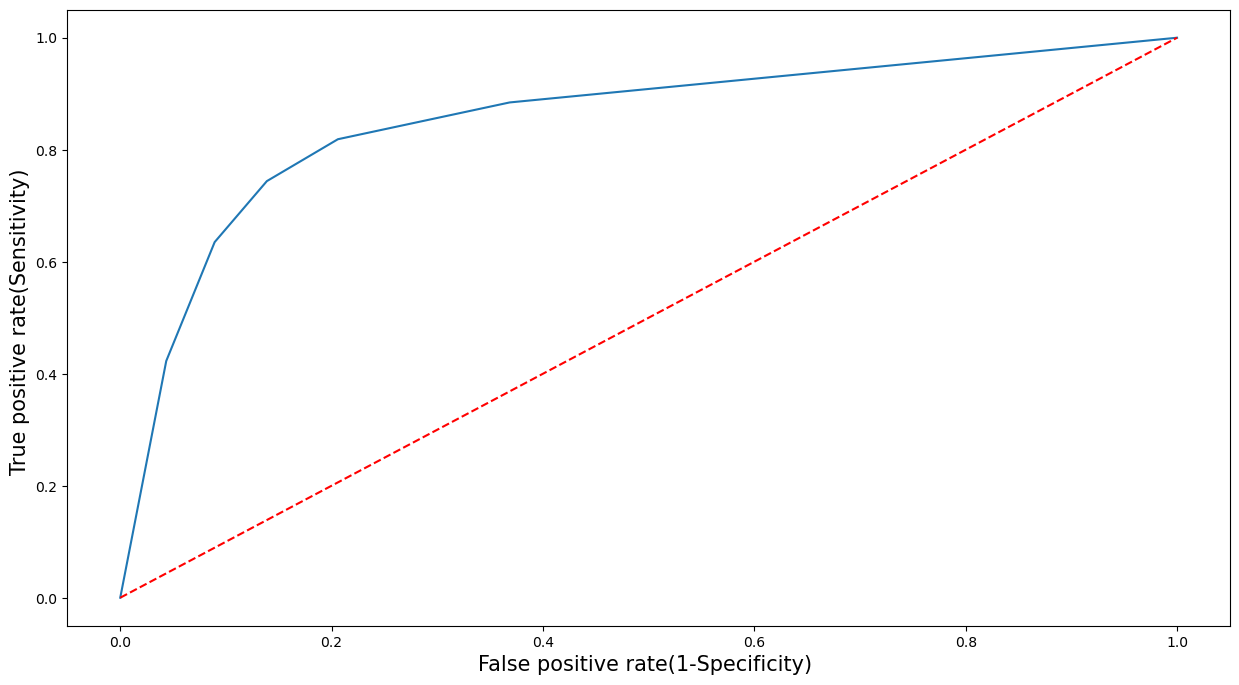

In [122]:
ypred_prob_knn = knn.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_knn)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_knn))

### Naive Baye's - GaussianNB

In [123]:
from sklearn.naive_bayes import GaussianNB

In [124]:
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)
ypred_gnb = gnb.predict(xtest)

In [125]:
print(accuracy_score(ytest, ypred_gnb))
print(classification_report(ytest, ypred_gnb))

0.8116633984141871
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10085
           1       0.41      0.75      0.53      1644

    accuracy                           0.81     11729
   macro avg       0.68      0.79      0.70     11729
weighted avg       0.88      0.81      0.83     11729



AUC Score:  0.8647479393524867


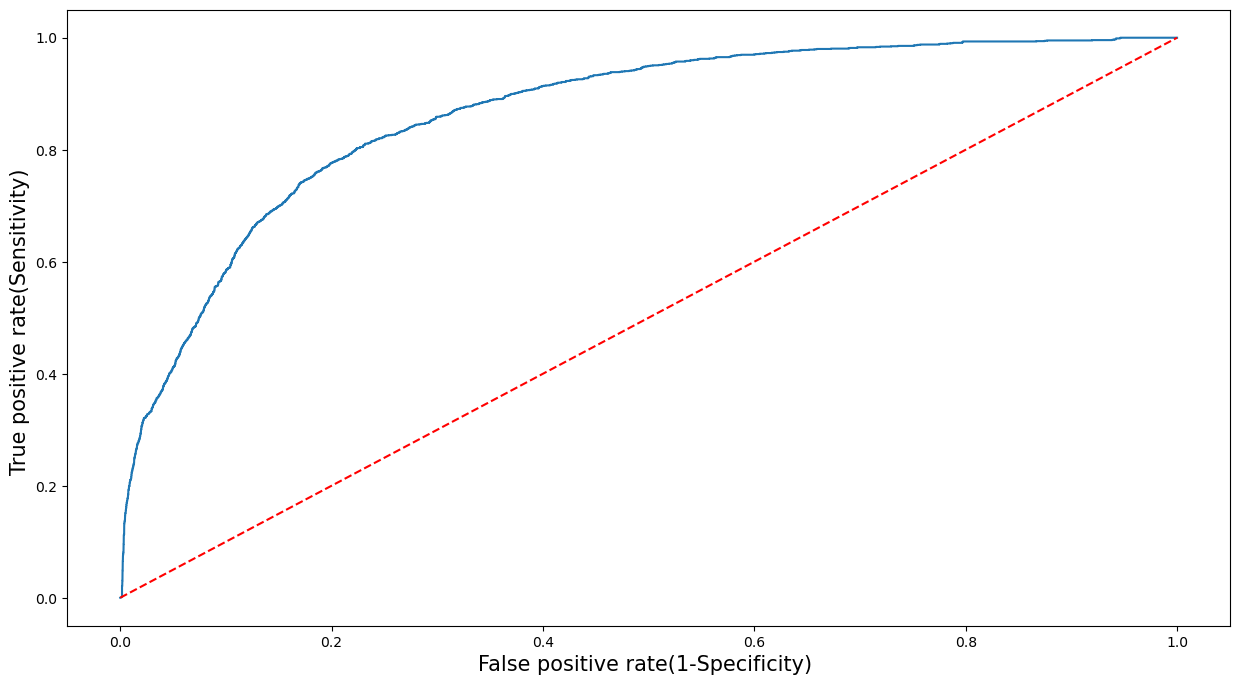

In [126]:
ypred_prob_gnb = gnb.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_gnb)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_gnb))

### Decision Tree - Gini

In [127]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=10)
dt.fit(xtrain, ytrain)
ypred_dt = dt.predict(xtest)

In [128]:
print(confusion_matrix(ytest, ypred_dt))
print(accuracy_score(ytest, ypred_dt))
print(classification_report(ytest, ypred_dt))

[[9539  546]
 [ 464 1180]]
0.913888652058999
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10085
           1       0.68      0.72      0.70      1644

    accuracy                           0.91     11729
   macro avg       0.82      0.83      0.83     11729
weighted avg       0.92      0.91      0.91     11729



In [129]:
print("Training Accuracy: ", dt.score(xtrain, ytrain))
print("Test Accuracy: ", dt.score(xtest, ytest))

Training Accuracy:  1.0
Test Accuracy:  0.913888652058999


AUC Score:  0.8318108727881136


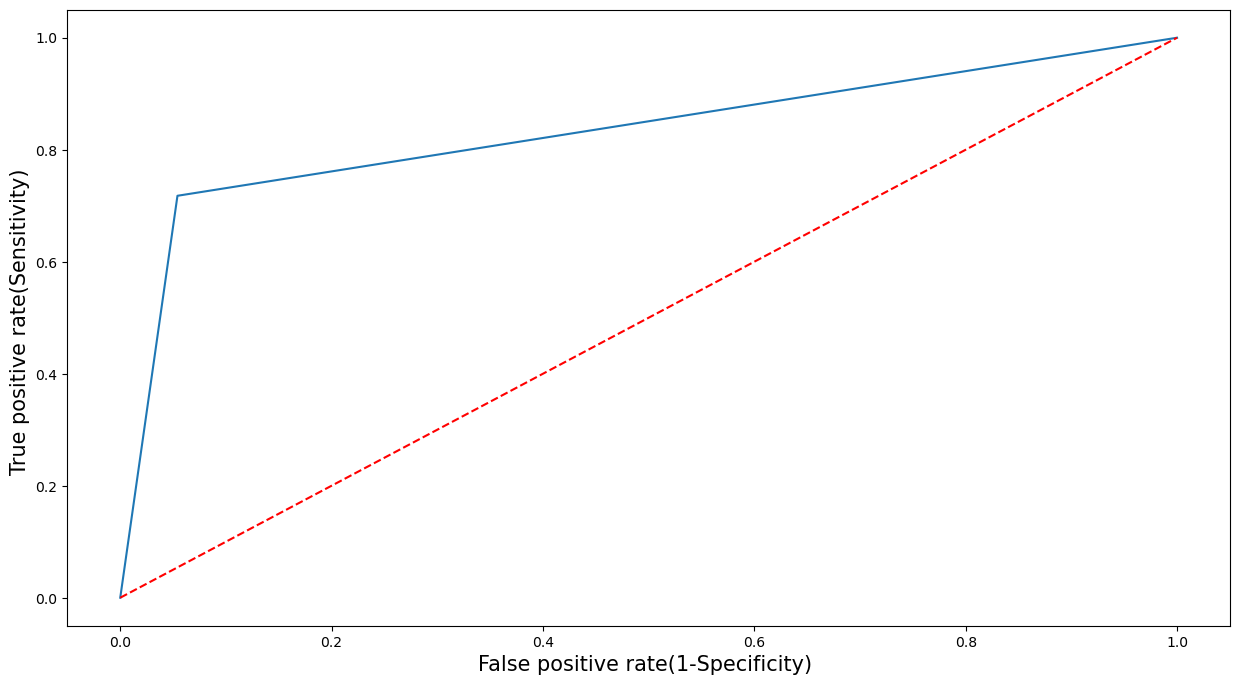

In [130]:
ypred_prob_dt = dt.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_dt)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_dt))

## Ensemble Learning

### Random Forest

In [131]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(xtrain, ytrain)
ypred_rf = rf.predict(xtest)

In [132]:
print(accuracy_score(ytest, ypred_rf))
print(classification_report(ytest, ypred_rf))

0.9485889675164123
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10085
           1       0.91      0.70      0.79      1644

    accuracy                           0.95     11729
   macro avg       0.93      0.84      0.88     11729
weighted avg       0.95      0.95      0.95     11729



In [133]:
print("Training Accuracy: ", rf.score(xtrain, ytrain))
print("Test Accuracy: ", rf.score(xtest, ytest))

Training Accuracy:  0.9999573706198311
Test Accuracy:  0.9485889675164123


AUC Score:  0.9364356437435086


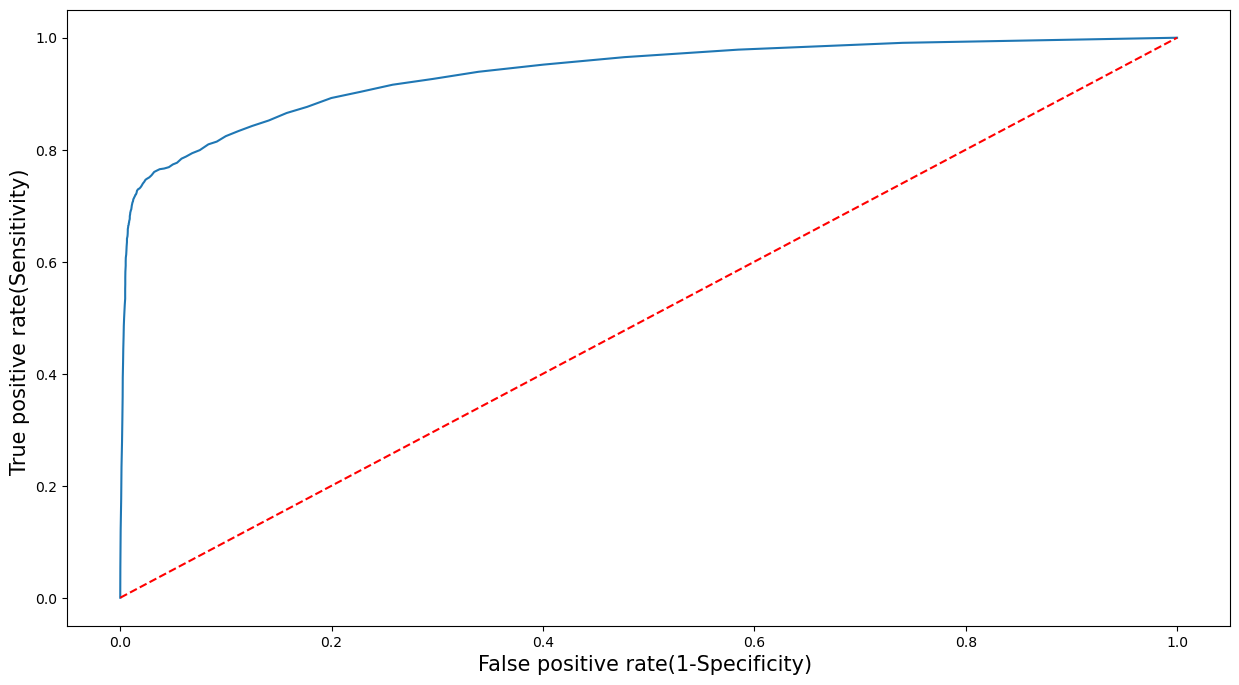

In [134]:
ypred_prob_rf = rf.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_rf)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_rf))

In [135]:
feature_rf = pd.DataFrame()
feature_rf['Feature'] = xtrain.columns
feature_rf['Importances'] = rf.feature_importances_
feature_rf = feature_rf.sort_values('Importances', ascending=False)
feature_rf

Feature  Importances
5          loan_percent_income     0.233769
4                loan_int_rate     0.134732
7                   loan_grade     0.124250
1                person_income     0.113667
3                    loan_amnt     0.077699
2            person_emp_length     0.059313
17              ownership_RENT     0.051658
0                   person_age     0.046289
6   cb_person_cred_hist_length     0.036098
14          ownership_MORTGAGE     0.026631
11              intent_MEDICAL     0.016342
10      intent_HOMEIMPROVEMENT     0.016232
16               ownership_OWN     0.014543
9             intent_EDUCATION     0.013680
12             intent_PERSONAL     0.012636
13              intent_VENTURE     0.011305
8    cb_person_default_on_file     0.010649
15             ownership_OTHER     0.000507

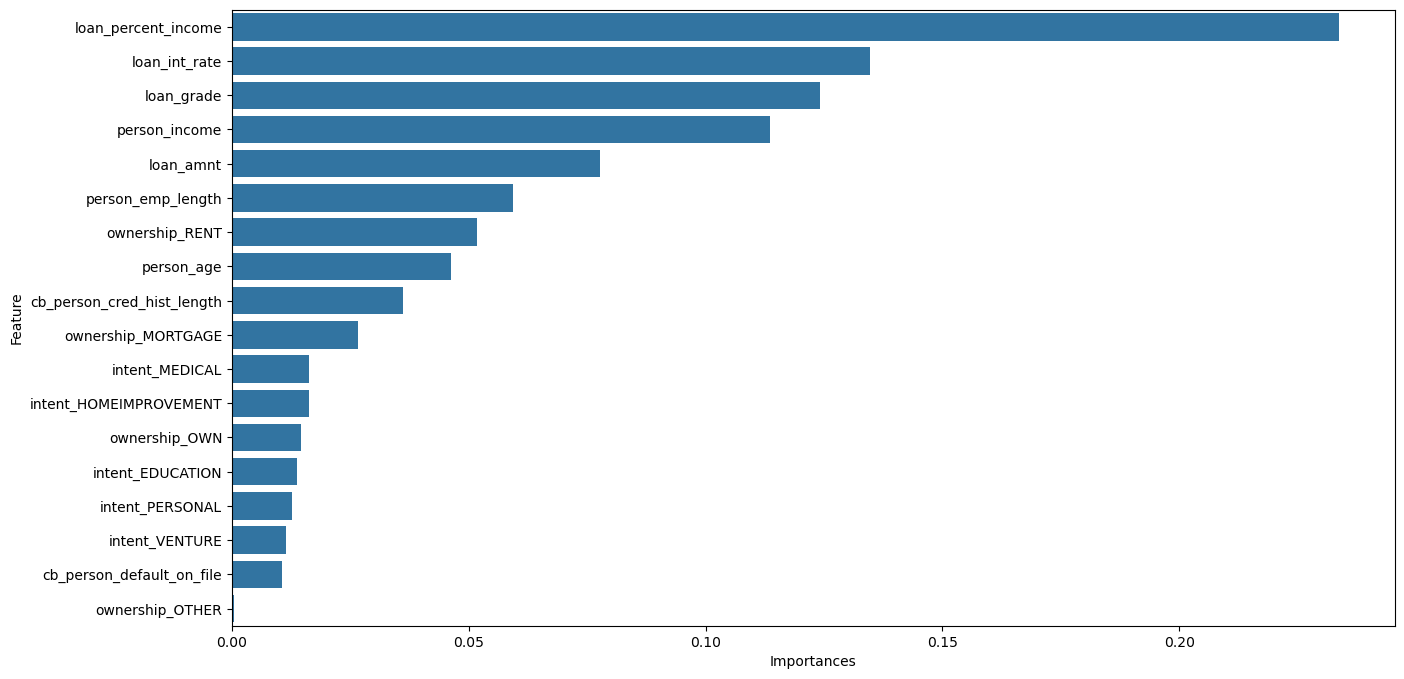

In [136]:
sns.barplot(x='Importances', y='Feature', data=feature_rf)
plt.show()

In [137]:
parameters = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees in the forest, more trees can improve performance
    'max_depth': [5, 10, 15, 20, None],  # Depth of trees, 'None' means nodes are expanded until all leaves are pure
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
}
rf11 = RandomForestClassifier(random_state=10)

rfcv = GridSearchCV(rf11, parameters, cv=3, scoring="accuracy")
rfcv.fit(xtrain, ytrain)
print(rfcv.best_params_)
print(rfcv.best_score_)

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}
0.9513385475003364


In [138]:
rf2 = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=20, random_state=10)
rf2.fit(xtrain, ytrain)
ypred_rf2 = rf2.predict(xtest)

In [139]:
print(accuracy_score(ytest, ypred_rf2))

0.9485889675164123


### Bagging Classifier

In [140]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier(random_state=10)

bc.fit(xtrain, ytrain)
ypred_bc=bc.predict(xtest)

In [141]:
print(confusion_matrix(ytest, ypred_bc))
print(accuracy_score(ytest, ypred_bc))
print(classification_report(ytest, ypred_bc))

[[9943  142]
 [ 478 1166]]
0.9471395685906727
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10085
           1       0.89      0.71      0.79      1644

    accuracy                           0.95     11729
   macro avg       0.92      0.85      0.88     11729
weighted avg       0.95      0.95      0.94     11729



AUC Score:  0.909710104018519


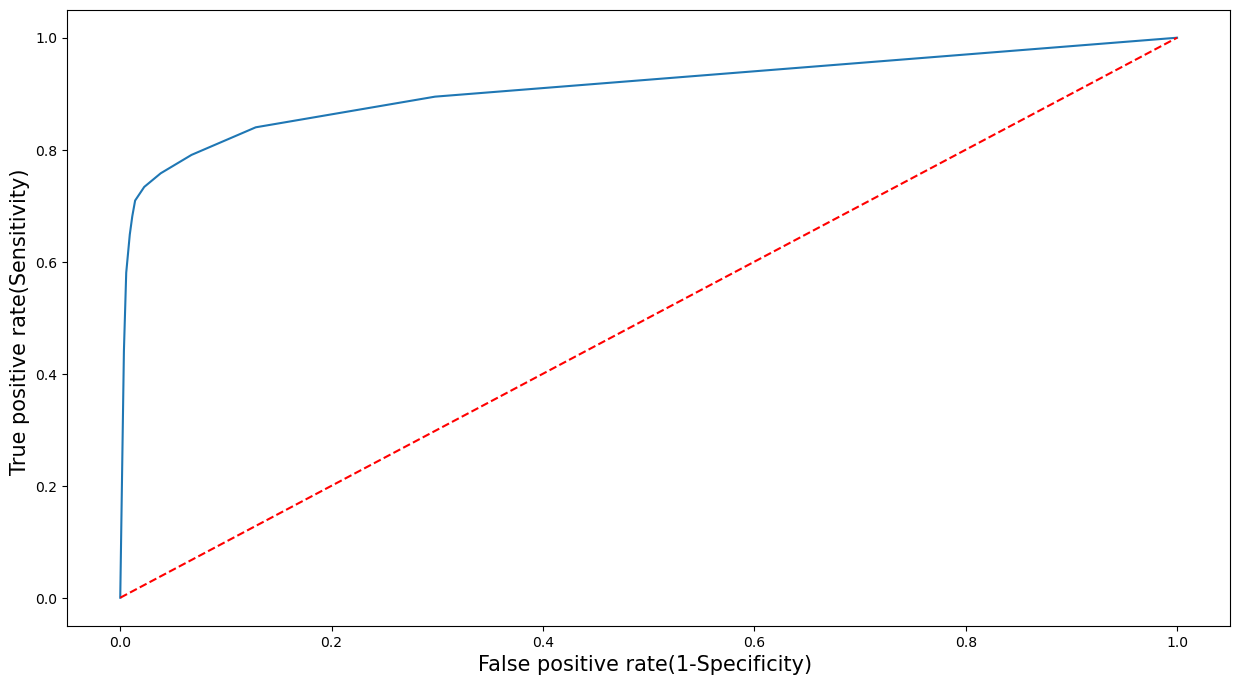

In [142]:
ypred_prob_bc = bc.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_bc)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_bc))

## Boosting

### AdaBoost

In [143]:
from sklearn.ensemble import AdaBoostClassifier
abcl=AdaBoostClassifier(random_state=10)

abcl.fit(xtrain,ytrain)
ypred_abcl = abcl.predict(xtest)

In [144]:
print(classification_report(ytest, ypred_abcl))
print(accuracy_score(ytest, ypred_abcl))
print(confusion_matrix(ytest, ypred_abcl))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10085
           1       0.81      0.63      0.71      1644

    accuracy                           0.93     11729
   macro avg       0.88      0.80      0.83     11729
weighted avg       0.92      0.93      0.92     11729

0.9270185011509933
[[9842  243]
 [ 613 1031]]


In [145]:
print("Training Accuracy ", abcl.score(xtrain, ytrain))
print("Testing Accuracy ", abcl.score(xtest, ytest))

Training Accuracy  0.9271890186716685
Testing Accuracy  0.9270185011509933


AUC Score:  0.923905953893125


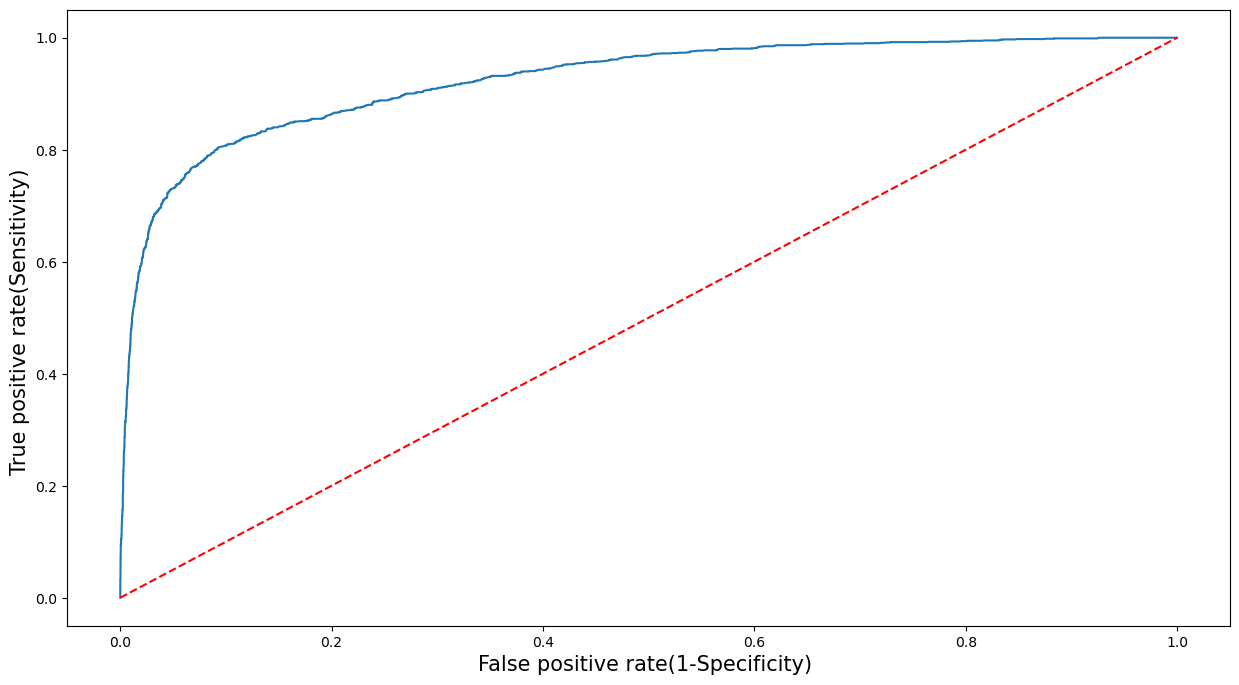

In [146]:
ypred_prob_abcl = abcl.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_abcl)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_abcl))

### Gradient Boosting

In [147]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl=GradientBoostingClassifier(random_state=10)

gbcl.fit(xtrain,ytrain)
ypred_gbcl = gbcl.predict(xtest)

In [148]:
print("Training Accuracy ", gbcl.score(xtrain, ytrain))
print("Testing Accuracy ", gbcl.score(xtest, ytest))

Training Accuracy  0.9479282121237957
Testing Accuracy  0.9439849944581806


AUC Score:  0.9424867036515651


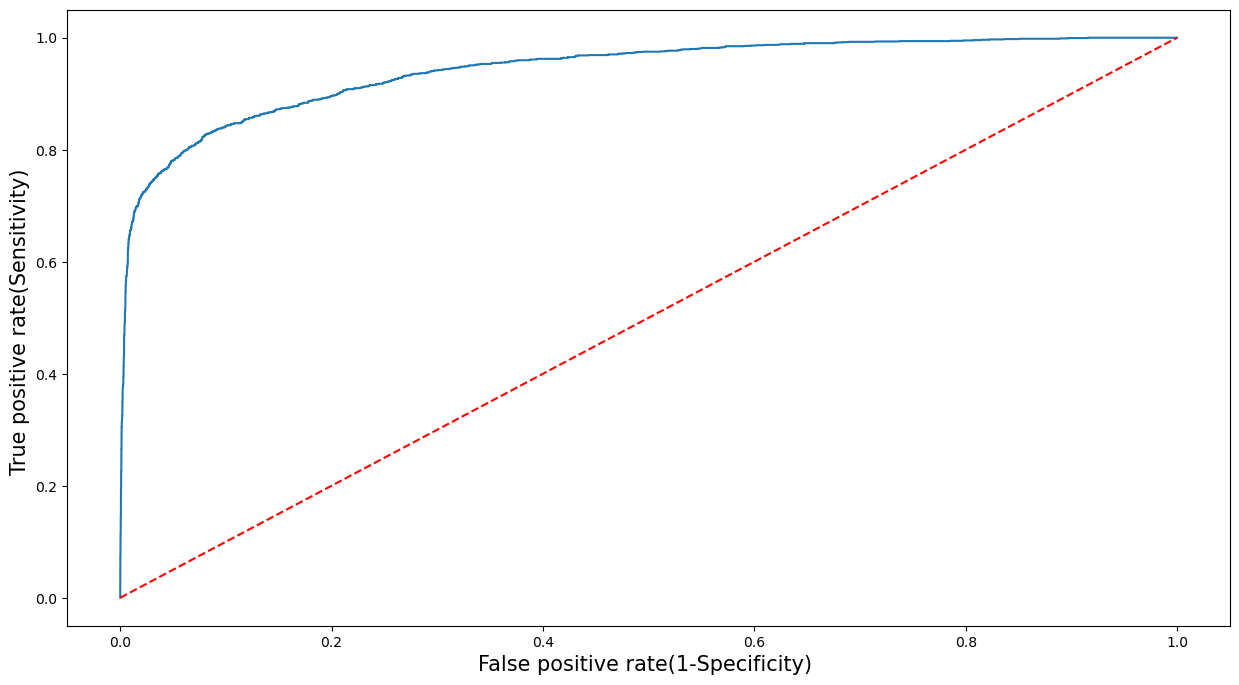

In [149]:
ypred_prob_gbcl = gbcl.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_gbcl)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_gbcl))

## XGBoost

In [150]:
from xgboost import XGBClassifier

In [151]:
xgb = XGBClassifier(random_state=10)
xgb.fit(xtrain, ytrain)
ypred_xgb = xgb.predict(xtest)

In [152]:
print("Training Accuracy ", xgb.score(xtrain, ytrain))
print("Testing Accuracy ", xgb.score(xtest, ytest))

Training Accuracy  0.9657472930343592
Testing Accuracy  0.95046466024384


AUC Score:  0.9526284489382825


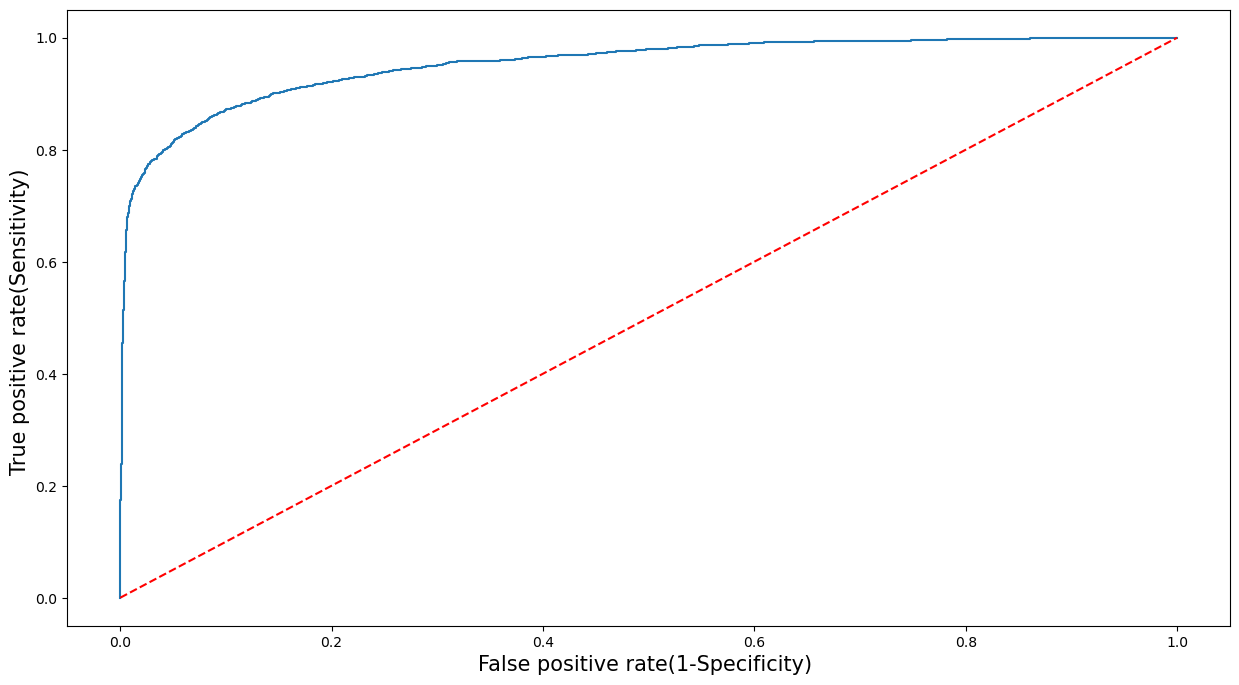

In [153]:
ypred_prob_xgb = xgb.predict_proba(xtest)[:,1]

fpr,tpr, thresholds = roc_curve(ytest, ypred_prob_xgb)

plt.plot(fpr,tpr)
plt.xlabel("False positive rate(1-Specificity) ", fontsize=15)
plt.ylabel("True positive rate(Sensitivity) ", fontsize=15)
plt.plot([0,1], [0,1], 'r--')
print("AUC Score: ", roc_auc_score(ytest, ypred_prob_xgb))

#### Tunned - XGBoost

In [154]:
parameters = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage, lower values tend to give better results
    'max_depth': [3, 4, 5, 6, 7],  # Depth of trees, higher depth can lead to overfitting
    'gamma': [0, 0.1, 0.5, 1, 2],  # Minimum loss reduction for further partitioning, helps control complexity
}

xgb1=XGBClassifier()
xgbcv=GridSearchCV(xgb1, parameters, cv=3, scoring='accuracy')

xgbcv.fit(xtrain, ytrain)
print(xgbcv.best_params_)
print(xgbcv.best_score_)

{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7}
0.9525748004350066


In [155]:
xgb1 = XGBClassifier(max_depth=7, learning_rate=0.2, gamma=1, random_state=10)
xgb1.fit(xtrain, ytrain)
ypred_xgb1 = xgb1.predict(xtest)

In [156]:
print(classification_report(ytest, ypred_xgb1))
print(accuracy_score(ytest, ypred_xgb1))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10085
           1       0.91      0.72      0.80      1644

    accuracy                           0.95     11729
   macro avg       0.93      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729

0.95046466024384


In [157]:
print("Training Accuracy ", xgb1.score(xtrain, ytrain))
print("Testing Accuracy ", xgb1.score(xtest, ytest))

Training Accuracy  0.959224997868531
Testing Accuracy  0.95046466024384


### Predictions using XGBoost classifier

In [173]:
predictions = xgb.predict(validate_data)

In [176]:
validate = pd.read_csv("test.csv")
validate.head()

id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                           2  
1                 0.10                         Y                           4  
2                 0.13                         Y                           2  
3                 0.14                         N                           7  
4                 0.15                         Y                           4

In [177]:
results = pd.DataFrame({
    'id': validate['id'],
    'predicted_values': predictions
})

In [178]:
results.to_csv('predictions.csv', index=False)

In [158]:
# create an empty dataframe to store the scores for various algorithms
score_card = pd.DataFrame(columns=['Model Name', 'Train Accuracy Score','Test Accuracy Score','f1-micro',
                                       'f1-macro', 'f1-weighted'])

# append the result table for all performance scores
# performance measures considered for model comparision are 'AUC Score', 'Recall Score','Accuracy Score',
# 'Kappa Score','f1-score' and roc auc score
# compile the required information in a user defined function 
def update_score_card(model_name,model,X_train,X_test,y_train,y_test):
    from sklearn import metrics
    y_pred_train = model.predict(X_train)
    # let 'y_pred' be the predicted values of y
    y_pred = model.predict(X_test)
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card=pd.concat([score_card,pd.DataFrame({'Model Name':[model_name],
                                    'Train Accuracy Score': [metrics.accuracy_score(y_train, y_pred_train)],
                                    'Test Accuracy Score': [metrics.accuracy_score(y_test, y_pred)],
                                    'f1-micro':[metrics.f1_score(y_test,y_pred,average='micro')],
                                    'f1-macro':[metrics.f1_score(y_test,y_pred,average='macro')],
                                    'f1-weighted':[metrics.f1_score(y_test,y_pred,average='weighted')]})])
    score_card = score_card.reset_index(drop=True)
    return score_card

In [159]:
def Classification_report_method(model,X_train,y_train,X_test,y_test):
    # model get predicted value for y_train
    y_train_pred = model.predict(X_train)
    
    # model get predicted value for y_train
    y_test_pred = model.predict(X_test)
    print('Classification Report for Train Data:')
    # classification report
    print(classification_report(y_train,y_train_pred))
    print()
    print('Classification Report for Test Data:')
    # classification report
    print(classification_report(y_test,y_test_pred))

In [160]:
update_score_card("Logistic Regression", lr, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  Test Accuracy Score  f1-micro  \
0  Logistic Regression              0.895537             0.895558  0.895558   

   f1-macro  f1-weighted  
0   0.73479     0.883393

In [161]:
update_score_card("K neighbor classifier", knn, xtrain_sc, xtest_sc, ytrain, ytest)

Model Name  Train Accuracy Score  Test Accuracy Score  f1-micro  \
0    Logistic Regression              0.895537             0.895558  0.895558   
1  K neighbor classifier              0.944667             0.926251  0.926251   

   f1-macro  f1-weighted  
0  0.734790     0.883393  
1  0.824001     0.920544

In [162]:
update_score_card("Naive Baye's classifier", gnb, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  Test Accuracy Score  \
0      Logistic Regression              0.895537             0.895558   
1    K neighbor classifier              0.944667             0.926251   
2  Naive Baye's classifier              0.815884             0.811663   

   f1-micro  f1-macro  f1-weighted  
0  0.895558  0.734790     0.883393  
1  0.926251  0.824001     0.920544  
2  0.811663  0.704655     0.832595

In [163]:
update_score_card("Decision Tree", dt, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  Test Accuracy Score  \
0      Logistic Regression              0.895537             0.895558   
1    K neighbor classifier              0.944667             0.926251   
2  Naive Baye's classifier              0.815884             0.811663   
3            Decision Tree              1.000000             0.913889   

   f1-micro  f1-macro  f1-weighted  
0  0.895558  0.734790     0.883393  
1  0.926251  0.824001     0.920544  
2  0.811663  0.704655     0.832595  
3  0.913889  0.825009     0.914761

In [164]:
update_score_card("Random Forest Classifier", rf, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  Test Accuracy Score  \
0       Logistic Regression              0.895537             0.895558   
1     K neighbor classifier              0.944667             0.926251   
2   Naive Baye's classifier              0.815884             0.811663   
3             Decision Tree              1.000000             0.913889   
4  Random Forest Classifier              0.999957             0.948589   

   f1-micro  f1-macro  f1-weighted  
0  0.895558  0.734790     0.883393  
1  0.926251  0.824001     0.920544  
2  0.811663  0.704655     0.832595  
3  0.913889  0.825009     0.914761  
4  0.948589  0.881544     0.945679

In [165]:
update_score_card("Random Forest Classifier - Tunned", rf2, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                Logistic Regression              0.895537   
1              K neighbor classifier              0.944667   
2            Naive Baye's classifier              0.815884   
3                      Decision Tree              1.000000   
4           Random Forest Classifier              0.999957   
5  Random Forest Classifier - Tunned              0.983673   

   Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0             0.895558  0.895558  0.734790     0.883393  
1             0.926251  0.926251  0.824001     0.920544  
2             0.811663  0.811663  0.704655     0.832595  
3             0.913889  0.913889  0.825009     0.914761  
4             0.948589  0.948589  0.881544     0.945679  
5             0.948589  0.948589  0.881051     0.945555

In [166]:
update_score_card("Bagging Classifier", bc, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                Logistic Regression              0.895537   
1              K neighbor classifier              0.944667   
2            Naive Baye's classifier              0.815884   
3                      Decision Tree              1.000000   
4           Random Forest Classifier              0.999957   
5  Random Forest Classifier - Tunned              0.983673   
6                 Bagging Classifier              0.992796   

   Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0             0.895558  0.895558  0.734790     0.883393  
1             0.926251  0.926251  0.824001     0.920544  
2             0.811663  0.811663  0.704655     0.832595  
3             0.913889  0.913889  0.825009     0.914761  
4             0.948589  0.948589  0.881544     0.945679  
5             0.948589  0.948589  0.881051     0.945555  
6             0.947140  0.947140  0.879869     0.944564

In [167]:
update_score_card("AdaBoost Classifier", abcl, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                Logistic Regression              0.895537   
1              K neighbor classifier              0.944667   
2            Naive Baye's classifier              0.815884   
3                      Decision Tree              1.000000   
4           Random Forest Classifier              0.999957   
5  Random Forest Classifier - Tunned              0.983673   
6                 Bagging Classifier              0.992796   
7                AdaBoost Classifier              0.927189   

   Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0             0.895558  0.895558  0.734790     0.883393  
1             0.926251  0.926251  0.824001     0.920544  
2             0.811663  0.811663  0.704655     0.832595  
3             0.913889  0.913889  0.825009     0.914761  
4             0.948589  0.948589  0.881544     0.945679  
5             0.948589  0.948589  0.881051     0.945555  
6             0.947140  0.947140  0.879869     0.944564  
7             0.927019  0.927019  0.832487     0.923049

In [168]:
update_score_card("Gradient Boosting Classifier", gbcl, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                Logistic Regression              0.895537   
1              K neighbor classifier              0.944667   
2            Naive Baye's classifier              0.815884   
3                      Decision Tree              1.000000   
4           Random Forest Classifier              0.999957   
5  Random Forest Classifier - Tunned              0.983673   
6                 Bagging Classifier              0.992796   
7                AdaBoost Classifier              0.927189   
8       Gradient Boosting Classifier              0.947928   

   Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0             0.895558  0.895558  0.734790     0.883393  
1             0.926251  0.926251  0.824001     0.920544  
2             0.811663  0.811663  0.704655     0.832595  
3             0.913889  0.913889  0.825009     0.914761  
4             0.948589  0.948589  0.881544     0.945679  
5             0.948589  0.948589  0.881051     0.945555  
6             0.947140  0.947140  0.879869     0.944564  
7             0.927019  0.927019  0.832487     0.923049  
8             0.943985  0.943985  0.870090     0.940602

In [169]:
update_score_card("XGBoost Classifier", xgb, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                Logistic Regression              0.895537   
1              K neighbor classifier              0.944667   
2            Naive Baye's classifier              0.815884   
3                      Decision Tree              1.000000   
4           Random Forest Classifier              0.999957   
5  Random Forest Classifier - Tunned              0.983673   
6                 Bagging Classifier              0.992796   
7                AdaBoost Classifier              0.927189   
8       Gradient Boosting Classifier              0.947928   
9                 XGBoost Classifier              0.965747   

   Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0             0.895558  0.895558  0.734790     0.883393  
1             0.926251  0.926251  0.824001     0.920544  
2             0.811663  0.811663  0.704655     0.832595  
3             0.913889  0.913889  0.825009     0.914761  
4             0.948589  0.948589  0.881544     0.945679  
5             0.948589  0.948589  0.881051     0.945555  
6             0.947140  0.947140  0.879869     0.944564  
7             0.927019  0.927019  0.832487     0.923049  
8             0.943985  0.943985  0.870090     0.940602  
9             0.950465  0.950465  0.888170     0.948237

In [170]:
update_score_card("XGBoost Classifier - Tunned", xgb1, xtrain, xtest, ytrain, ytest)

Model Name  Train Accuracy Score  \
0                 Logistic Regression              0.895537   
1               K neighbor classifier              0.944667   
2             Naive Baye's classifier              0.815884   
3                       Decision Tree              1.000000   
4            Random Forest Classifier              0.999957   
5   Random Forest Classifier - Tunned              0.983673   
6                  Bagging Classifier              0.992796   
7                 AdaBoost Classifier              0.927189   
8        Gradient Boosting Classifier              0.947928   
9                  XGBoost Classifier              0.965747   
10        XGBoost Classifier - Tunned              0.959225   

    Test Accuracy Score  f1-micro  f1-macro  f1-weighted  
0              0.895558  0.895558  0.734790     0.883393  
1              0.926251  0.926251  0.824001     0.920544  
2              0.811663  0.811663  0.704655     0.832595  
3              0.913889  0.913889  0.825009     0.914761  
4              0.948589  0.948589  0.881544     0.945679  
5              0.948589  0.948589  0.881051     0.945555  
6              0.947140  0.947140  0.879869     0.944564  
7              0.927019  0.927019  0.832487     0.923049  
8              0.943985  0.943985  0.870090     0.940602  
9              0.950465  0.950465  0.888170     0.948237  
10             0.950465  0.950465  0.886933     0.947928

**Analysis of the Dataset Using the XGBoost Classifier Model:**

* High Accuracy: The XGBoost Classifier model achieved a commendable accuracy of 95.05%, indicating that it correctly classifies approximately 95.05% of the instances in the dataset. This high level of accuracy demonstrates the model’s strong performance in predicting the target classes.

* Balanced F1 Score (Weighted): The weighted F1 score of 94.82% suggests that the model maintains a good balance between precision and recall. This score indicates that the model is effectively capturing both positive and negative instances. The slight difference between the accuracy and F1 score may imply potential class imbalance in the dataset, where one class may have a significantly higher representation than the other. This highlights the importance of investigating class distribution further and possibly applying techniques to handle any imbalances.

* Model Selection: While the XGBoost Classifier shows excellent results, it is essential to compare its performance with other models to ensure it is the best choice for this problem. For instance:

        Tuned XGBoost Classifier: Accuracy – 95.05%, Weighted F1 Score – 94.79%
        Random Forest Classifier: Accuracy – 94.86%, Weighted F1 Score – 94.57%
        K Neighbor Classifier: Accuracy – 92.63%, Weighted F1 Score – 92.05%

* The results indicate that XGBoost and its tuned version are strong candidates, but the Random Forest Classifier also performs competitively. A thorough comparison is essential to confirm the superiority of these models for this specific problem.

* Hyperparameter Tuning: The current results are promising, but the performance of the models could potentially be improved through more refined hyperparameter tuning. Revisiting the GridSearchCV process and exploring a broader range of hyperparameters might lead to enhancements in both accuracy and the weighted F1 score.

* Business Impact: The business implications of the model’s performance are significant for financial institutions seeking to predict loan default status. The relative importance of accuracy and the weighted F1 score hinges on the model's ability to minimize the risks associated with lending. Accurate predictions can help institutions identify high-risk loans, thereby reducing the cost of defaults and enhancing overall portfolio performance. Evaluating the trade-offs between false positives (incorrectly classifying a non-defaulting loan as a default) and false negatives (failing to identify a defaulting loan) is crucial. Understanding these costs will enable organizations to align the model’s predictions with their risk management strategies and business objectives, ultimately leading to more informed lending decisions.

**Conclusion:**
Achieving an accuracy of 95.05% and a weighted F1 score of 94.79% is an impressive outcome for predicting loan default status. These results indicate that the model is effective in distinguishing between high-risk and low-risk loans, which is critical for financial institutions. However, further analysis, including a thorough comparison with other models and a deep dive into the business implications, is essential to ensure that the model meets the specific needs of the lending process. Understanding how the model's predictions align with organizational objectives will provide insights into its practical applicability, enabling informed decision-making in mitigating potential losses and enhancing overall lending strategies.